# Library install & import

In [2]:
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
from PIL import Image
from transformers import AutoImageProcessor, Trainer, ViTForImageClassification, TrainingArguments, TrainerCallback, ResNetForImageClassification
from torchvision import transforms
from torchvision.datasets import ImageFolder
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix
from peft import LoraConfig, get_peft_model

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
matplotlib.rcParams['font.family'] = 'Roboto Condensed'

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data exploration

In [ ]:
def count_files_in_subfolders(base_folder):
    """
    Counts and prints the number of files in each subfolder of the specified base folder.

    Parameters:
    base_folder (str): The path to the base folder containing subfolders.

    This function iterates through each subfolder within the base folder,
    counts the number of files in each subfolder, and prints the result.
    It only considers directories within the base folder.
    """
    
    # Get a list of paths for all subdirectories in the base folder
    subfolders = [f.path for f in os.scandir(base_folder) if f.is_dir()]
    
    # Iterate through each subfolder
    for subfolder in subfolders:
        # Count the number of files in the current subfolder
        num_files = len(os.listdir(subfolder))
        
        # Print the number of files in the current subfolder
        print(f"Folder {subfolder} contains {num_files} files")

In [3]:
count_files_in_subfolders('data')

Folder data\test contains 2 files
Folder data\train contains 2 files
Folder data\valid contains 2 files


In [4]:
count_files_in_subfolders('data/test')

Folder data/test\fake contains 10000 files
Folder data/test\real contains 10000 files


In [5]:
count_files_in_subfolders('data/valid')

Folder data/valid\fake contains 10000 files
Folder data/valid\real contains 10000 files


In [6]:
count_files_in_subfolders('data/train')

Folder data/train\fake contains 50000 files
Folder data/train\real contains 50000 files


In [7]:
# Function to load the first N images from a given directory
def load_sample_images(base_folder, num_images=4):
    """
    Loads the first N image files from a specified directory.

    Parameters:
    base_folder (str): The path to the directory containing images.
    num_images (int): The number of images to load from the directory (default is 4).

    Returns:
    list: A list of paths to the first N image files found in the directory.
    If the directory does not exist or contains fewer than N images, returns a list with fewer images or an empty list.
    """
    # Check if the specified directory exists
    if not os.path.exists(base_folder):
        print(f"Directory {base_folder} does not exist.")
        return []
    
    # Get a list of image files in the base folder that match the specified formats
    images = [os.path.join(base_folder, img) for img in os.listdir(base_folder) 
              if img.lower().endswith(('png', 'jpg', 'jpeg'))]
    
    # Return the first num_images from the list of images
    return images[:num_images]  # Return the first num_images


# Function to display images
def display_images(images, labels):
    """
    Displays a set of images with corresponding labels.

    Parameters:
    images (list): A list of image file paths to be displayed.
    labels (list): A list of labels corresponding to each image for display.

    This function creates a grid layout to display images using Matplotlib,
    with titles for each image based on the provided labels. If an image fails to load,
    an error message is printed.
    """
    plt.figure(figsize=(12, 6))  # Set the figure size for the plot
    for i, (img_path, label) in enumerate(zip(images, labels)):
        try:
            img = Image.open(img_path)  # Open the image file
            plt.subplot(2, 4, i + 1)  # Create a subplot for each image
            plt.imshow(img)  # Display the image
            plt.title(label, fontsize=12)  # Set the title to the corresponding label
            plt.axis('off')  # Hide the axis for a cleaner look
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")  # Print error message if the image fails to load
    plt.tight_layout()  # Adjust the layout to prevent overlap
    plt.show()  # Display the figure

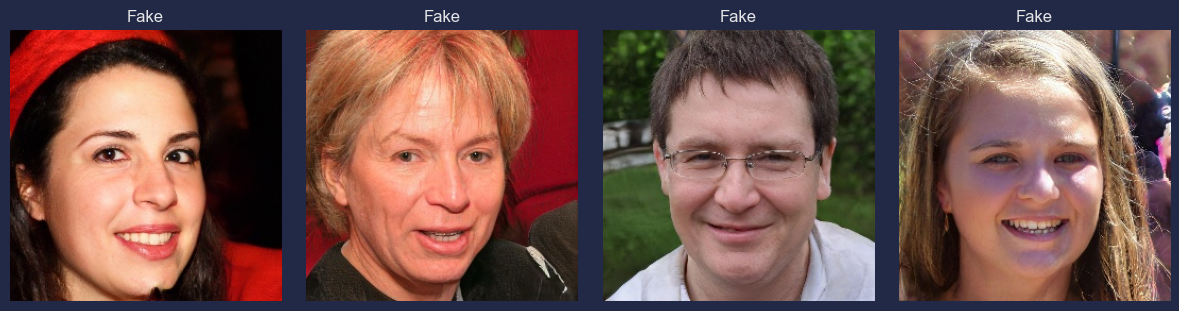

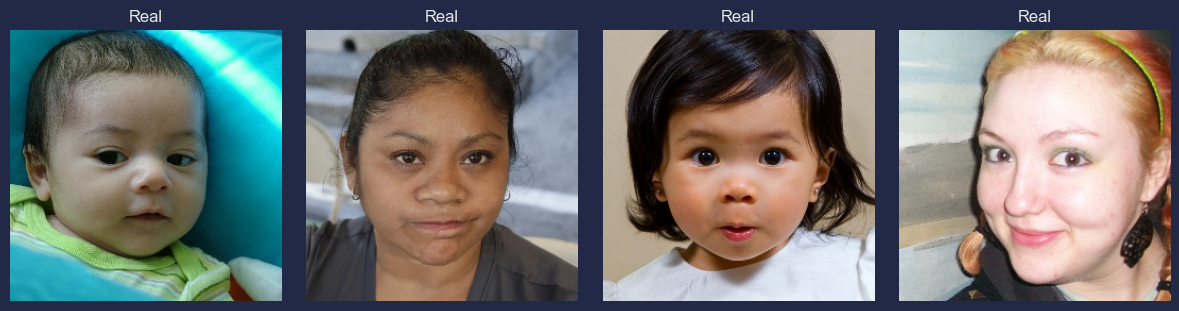

In [8]:
# Define base folders for fake and real data
base_folder_fake = 'data/train/fake'
base_folder_real = 'data/train/real'

# Load the first 4 images
fake_images = load_sample_images(base_folder_fake, num_images=4)
real_images = load_sample_images(base_folder_real, num_images=4)

# Display images
if fake_images:  # Check if any fake images were loaded
    display_images(fake_images, ['Fake'] * len(fake_images))
if real_images:  # Check if any real images were loaded
    display_images(real_images, ['Real'] * len(real_images))

# Data preprocessing & augmentation

In [2]:
base_vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=2, ignore_mismatched_sizes=True)
vit_model  = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=2, ignore_mismatched_sizes=True)
vit_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
vit_processor

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-st

ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [3]:
base_rn_model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50", num_labels=2, ignore_mismatched_sizes=True)
rn_model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50", num_labels=2, ignore_mismatched_sizes=True)
rn_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
rn_processor

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-

ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [4]:
# Shared augmentation pipeline
augmentation_pipeline = transforms.Compose([
    transforms.RandomHorizontalFlip(),              # Random horizontal flip
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2), # Color jitter
])

# Define the combined transform for ViT
train_vit_combined_transforms = transforms.Compose([
    augmentation_pipeline,  # Apply augmentations
    transforms.Lambda(lambda img: vit_processor(images=img, return_tensors="pt")['pixel_values'].squeeze(0))
])

val_test_vit_combined_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: vit_processor(images=img, return_tensors="pt")['pixel_values'].squeeze(0))
])

# Define the combined transform for ResNet
train_resnet_combined_transforms = transforms.Compose([
    augmentation_pipeline,  # Apply augmentations
    transforms.Lambda(lambda img: rn_processor(images=img, return_tensors="pt")['pixel_values'].squeeze(0))
])

val_test_resnet_combined_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: rn_processor(images=img, return_tensors="pt")['pixel_values'].squeeze(0))
])

In [5]:
# Load the dataset
dataset = ImageFolder(root='data/test')

In [68]:
print(f"Training set size: {len(dataset)}")

Training set size: 20000


In [6]:
class CustomDataset(torch.utils.data.Dataset):
    """
    A custom dataset class for handling image data and corresponding labels.
    This class wraps a given dataset and applies transformations to the images.

    Parameters:
        dataset (torch.utils.data.Dataset): The dataset containing the images and labels.
        transform (callable, optional): A function/transform to apply to the images.
    """

    def __init__(self, dataset, transform=None):
        # Store the dataset and the optional transformations
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.dataset)

    def __getitem__(self, idx):
        # Retrieve the image and label for the given index
        img, label = self.dataset[idx]

        # Apply transformations if specified
        if self.transform:
            img = self.transform(img)

        # Return a dictionary containing the processed image and label
        return {"pixel_values": img, "labels": label}

# Wrap the datasets with the appropriate transforms
vit_train_dataset = CustomDataset(dataset, transform=val_test_vit_combined_transforms)

# Wrap the datasets with the appropriate transforms
rn_train_dataset = CustomDataset(dataset, transform=val_test_resnet_combined_transforms)

# Data after preprocessing

In [18]:
# Function to fetch images by specific indices
def get_images_by_index(dataset, real_indices, fake_indices):
    """
    Fetches images from the dataset based on specified indices for real and fake classes.

    Parameters:
    - dataset: The complete dataset containing both real and fake images.
    - real_indices: List of indices to retrieve real images from the dataset.
    - fake_indices: List of indices to retrieve fake images from the dataset.

    Returns:
    - real_images: List of real images fetched from the dataset.
    - fake_images: List of fake images fetched from the dataset.
    """
    # Fetch real and fake images using the provided indices
    real_images = [dataset[i] for i in real_indices]
    fake_images = [dataset[i] for i in fake_indices]
    return real_images, fake_images


# Function to visualize images
def visualize_images(real_images, fake_images):
    """
    Visualizes a selection of real and fake images in a 2x4 grid.

    Parameters:
    - real_images: List of images labeled as 'real'.
    - fake_images: List of images labeled as 'fake'.
    """
    plt.figure(figsize=(16, 8))  # Set figure size for display

    # Visualize real images
    for i, sample in enumerate(real_images):
        img = sample['pixel_values']  # Extract pixel values from the sample
        plt.subplot(2, 4, i + 1)  # Position real images in the first row
        plt.imshow(img.permute(1, 2, 0).numpy())  # Convert tensor to array format for plotting
        plt.title('real')  # Label the image as 'real'
        plt.axis('off')  # Hide axis for a cleaner display

    # Visualize fake images
    for i, sample in enumerate(fake_images):
        img = sample['pixel_values']  # Extract pixel values from the sample
        plt.subplot(2, 4, i + 5)  # Position fake images in the second row
        plt.imshow(img.permute(1, 2, 0).numpy())
        plt.title('fake')  # Label the image as 'fake'
        plt.axis('off')  # Hide axis for a cleaner display

    plt.show()  # Display the plotted images

In [ ]:
# Specify the indices for real and fake images
fake_indices = [0, 1, 2, 3]  
real_indices = [10000, 10001, 10002, 10003]

# Get images from vit_train_dataset
vit_real_images, vit_fake_images = get_images_by_index(vit_train_dataset, real_indices, fake_indices)

# Get images from rn_train_dataset
rn_real_images, rn_fake_images = get_images_by_index(rn_train_dataset, real_indices, fake_indices)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8666667..0.8039216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.36470592].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49019605..0.7882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..0.62352943]

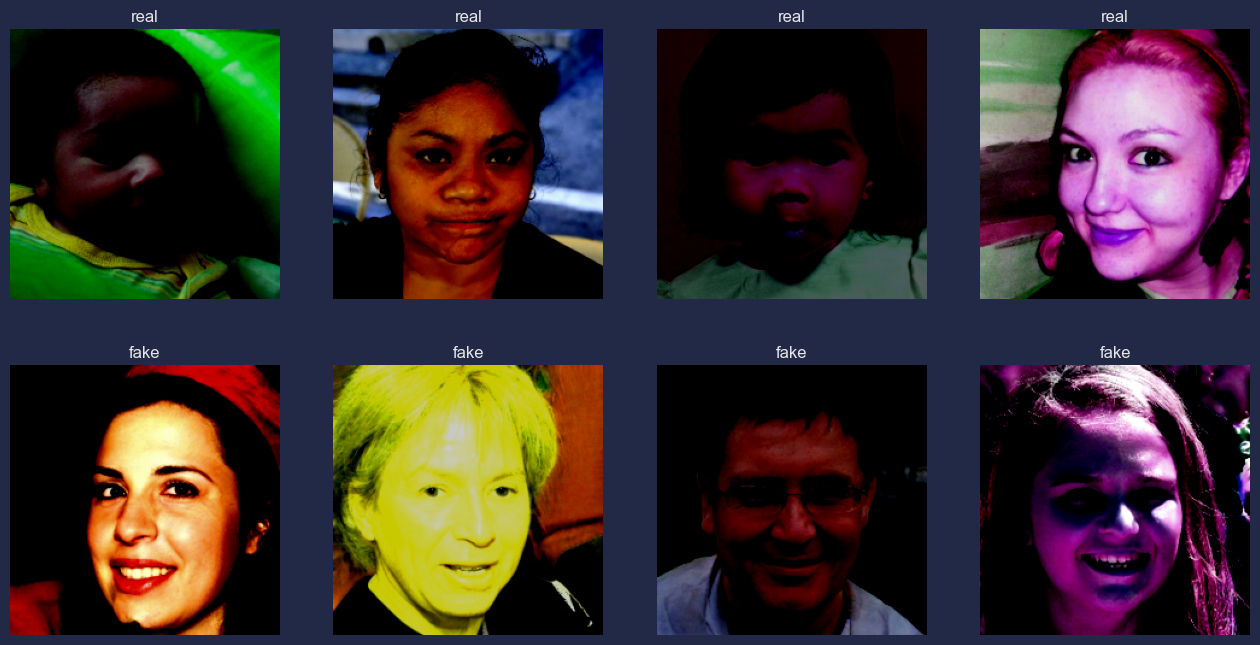

In [17]:
# Visualize vit_train_dataset
visualize_images(vit_real_images, vit_fake_images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6041614..1.4722441].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0904187..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6465361].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.9754903].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5455182..2.64].
Clip

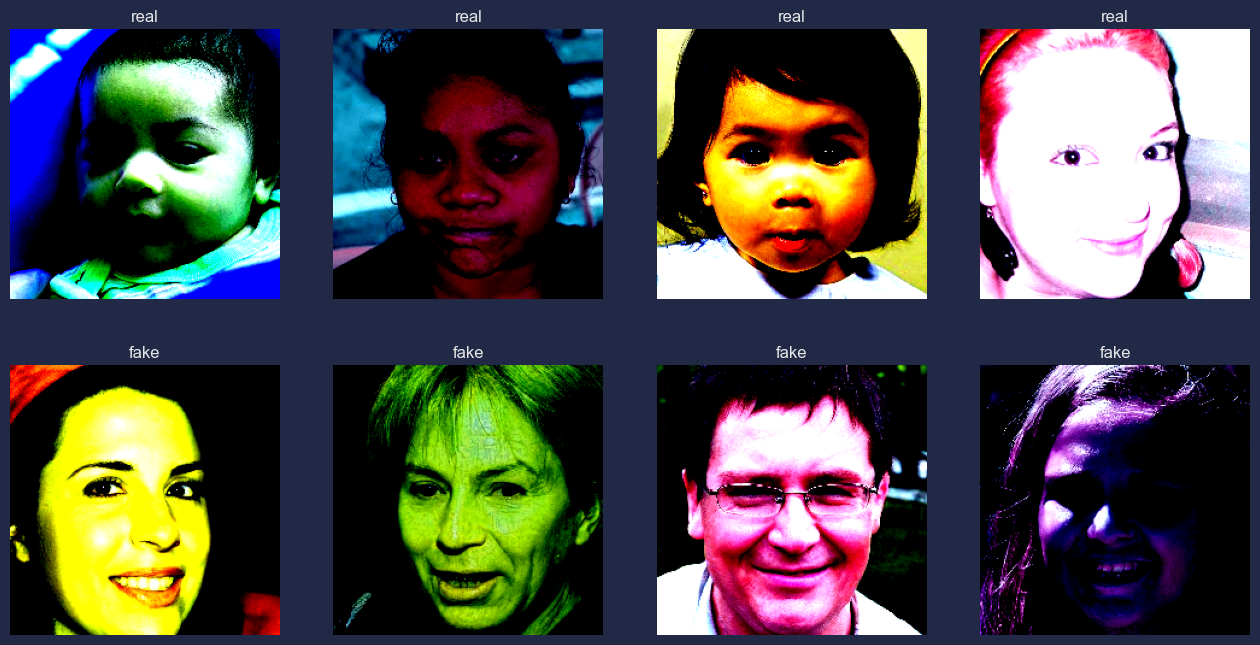

In [18]:
# Visualize rn_train_dataset
visualize_images(rn_real_images, rn_fake_images)

# Model overview

In [7]:
vit_model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [20]:
rn_model

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

In [7]:
# Function to print the total and trainable parameters in a model
def print_trainable_parameters(model):
    """
    Prints the count of trainable and total parameters in the model, along with
    the percentage of parameters that are trainable.

    Parameters:
    - model: The neural network model containing layers with parameters.

    Prints:
    - Total number of trainable parameters.
    - Total number of all parameters.
    - Percentage of trainable parameters out of all parameters.
    """
    trainable_params = 0  # Initialize counter for trainable parameters
    all_param = 0  # Initialize counter for all parameters

    # Loop through each parameter in the model
    for _, param in model.named_parameters():
        all_param += param.numel()  # Count all parameters
        if param.requires_grad:  # Check if the parameter is trainable
            trainable_params += param.numel()  # Count trainable parameters

    # Print the summary of trainable vs. all parameters
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )


# Function to count and print trainable parameters for large layers
def count_trainable_parameters(model):
    """
    Prints the number of trainable parameters for each layer that has more than 10,000 trainable parameters.

    Parameters:
    - model: The neural network model containing layers with parameters.

    Prints:
    - Layer name and number of trainable parameters for each layer with > 10,000 trainable parameters.
    """
    # Loop through each parameter in the model
    for name, param in model.named_parameters():
        # Check if the parameter is trainable and has more than 10,000 elements
        if param.requires_grad and param.numel():
            # Print the layer name and the number of trainable parameters
            print(f"Layer: {name} | Trainable parameters: {param.numel()}")

In [ ]:
print_trainable_parameters(vit_model)

trainable params: 85800194 || all params: 85800194 || trainable%: 100.00


In [ ]:
print_trainable_parameters(rn_model)

trainable params: 23512130 || all params: 23512130 || trainable%: 100.00


In [11]:
count_trainable_parameters(vit_model)

Layer: vit.embeddings.cls_token | Trainable parameters: 768
Layer: vit.embeddings.position_embeddings | Trainable parameters: 151296
Layer: vit.embeddings.patch_embeddings.projection.weight | Trainable parameters: 589824
Layer: vit.embeddings.patch_embeddings.projection.bias | Trainable parameters: 768
Layer: vit.encoder.layer.0.attention.attention.query.weight | Trainable parameters: 589824
Layer: vit.encoder.layer.0.attention.attention.query.bias | Trainable parameters: 768
Layer: vit.encoder.layer.0.attention.attention.key.weight | Trainable parameters: 589824
Layer: vit.encoder.layer.0.attention.attention.key.bias | Trainable parameters: 768
Layer: vit.encoder.layer.0.attention.attention.value.weight | Trainable parameters: 589824
Layer: vit.encoder.layer.0.attention.attention.value.bias | Trainable parameters: 768
Layer: vit.encoder.layer.0.attention.output.dense.weight | Trainable parameters: 589824
Layer: vit.encoder.layer.0.attention.output.dense.bias | Trainable parameters: 76

In [12]:
count_trainable_parameters(rn_model)

Layer: resnet.embedder.embedder.convolution.weight | Trainable parameters: 9408
Layer: resnet.embedder.embedder.normalization.weight | Trainable parameters: 64
Layer: resnet.embedder.embedder.normalization.bias | Trainable parameters: 64
Layer: resnet.encoder.stages.0.layers.0.shortcut.convolution.weight | Trainable parameters: 16384
Layer: resnet.encoder.stages.0.layers.0.shortcut.normalization.weight | Trainable parameters: 256
Layer: resnet.encoder.stages.0.layers.0.shortcut.normalization.bias | Trainable parameters: 256
Layer: resnet.encoder.stages.0.layers.0.layer.0.convolution.weight | Trainable parameters: 4096
Layer: resnet.encoder.stages.0.layers.0.layer.0.normalization.weight | Trainable parameters: 64
Layer: resnet.encoder.stages.0.layers.0.layer.0.normalization.bias | Trainable parameters: 64
Layer: resnet.encoder.stages.0.layers.0.layer.1.convolution.weight | Trainable parameters: 36864
Layer: resnet.encoder.stages.0.layers.0.layer.1.normalization.weight | Trainable parame

In [ ]:
# First, freeze all parameters (if not already frozen)
for param in base_vit_model.parameters():
    param.requires_grad = False

# Unfreeze the classifier layer
for param in base_vit_model.classifier.parameters():
    param.requires_grad = True

# Unfreeze the query, key, and value parameters of the 12th attention layer
for name, param in base_vit_model.named_parameters():
    if ("vit.encoder.layer.11.attention.attention.query" in name or
        "vit.encoder.layer.11.attention.attention.key" in name or
        "vit.encoder.layer.11.attention.attention.value" in name):
        param.requires_grad = True

In [8]:
# Freeze all parameters
for param in base_rn_model.parameters():
    param.requires_grad = False

# Unfreeze the parameters of the classification layer
for param in base_rn_model.classifier.parameters():
    param.requires_grad = True

for name, param in base_rn_model.named_parameters():
    if ("resnet.encoder.stages.3.layers.2.layer.2" in name):
        param.requires_grad = True


In [9]:
vit_config = LoraConfig(
    r=32,
    lora_alpha=16,
    lora_dropout=0.1,
    modules_to_save=["classifier"],
    target_modules=[
        "layer.11.attention.attention.query", "layer.11.attention.attention.key", "layer.11.attention.attention.value"
    ]
)

rn_config = LoraConfig(
    r=32,
    lora_alpha=16,
    lora_dropout=0.1,
    modules_to_save=["classifier"],
    target_modules=[
        "stages.3.layers.2.layer.2.convolution"
    ]
)

vit_lora_model = get_peft_model(vit_model, vit_config)
rn_lora_model = get_peft_model(rn_model, rn_config)

In [13]:
print_trainable_parameters(base_vit_model)

trainable params: 1773314 || all params: 85800194 || trainable%: 2.07


In [14]:
print_trainable_parameters(base_rn_model)

trainable params: 1056770 || all params: 23512130 || trainable%: 4.49


In [11]:
print_trainable_parameters(vit_lora_model)

trainable params: 148994 || all params: 85949188 || trainable%: 0.17


In [12]:
print_trainable_parameters(rn_lora_model)

trainable params: 86018 || all params: 23598148 || trainable%: 0.36


# Prepare Trainer

In [10]:
def collate_fn(batch):
    """
    Custom collate function to prepare batched data for the model. This function 
    stacks image pixel values and converts labels into a single tensor for each batch.

    Parameters:
        batch (list of dict): A list of dictionaries where each dictionary contains 
                              'pixel_values' (image tensor) and 'labels' (int or tensor label).

    Returns:
        dict: A dictionary containing:
              - 'pixel_values' (tensor): A tensor of stacked images for the batch.
              - 'labels' (tensor): A tensor of corresponding labels for the batch.
    """
    
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),  # Stack images into a single tensor
        'labels': torch.tensor([x['labels'] for x in batch])              # Convert labels to a single tensor
    }

In [11]:
class CustomTrainer(Trainer):
    """
    Custom Trainer class for managing training and evaluation processes with additional metrics tracking.
    """
    
    def __init__(self, *args, **kwargs):
        """
        Initializes the CustomTrainer with additional attributes for tracking predictions, labels, and loss.
        """
        super().__init__(*args, **kwargs)  # Call the base class constructor
        self.epoch_predictions = []  # List to store predictions for each epoch
        self.epoch_labels = []  # List to store true labels for each epoch
        self.epoch_loss = []  # List to store loss values for each epoch

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Computes the loss based on the model outputs and the provided labels.
        
        Parameters:
            model: The model used for prediction.
            inputs: A dictionary of inputs to the model, which may include labels.
            return_outputs: A boolean flag to determine if the outputs should be returned alongside the loss.

        Returns:
            The computed loss, and optionally the model outputs.
        """
        labels = inputs.pop("labels", None)  # Extract labels if present
        outputs = model(**inputs)  # Forward pass

        # Compute and store predictions and labels if labels are provided
        if labels is not None:
            preds = outputs.logits.detach()
            class_preds = preds.argmax(axis=1)
            
            # Store epoch predictions and labels for metrics
            self.epoch_predictions.append(class_preds.cpu().numpy())
            self.epoch_labels.append(labels.cpu().numpy())

            # Use label smoothing if applicable
            loss = self.label_smoother(outputs, labels)
        else:
            # If labels are not present, get loss from outputs directly
            loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]

        # Store loss for epoch-level metrics
        self.epoch_loss.append(loss.item())

        # Return loss and optionally outputs
        return (loss, outputs) if return_outputs else loss


In [12]:
class CustomCallback(TrainerCallback):
    """
    Custom callback for logging metrics at the end of each epoch,
    including a classification report, confusion matrix, and GPU memory usage.
    Additionally, it logs GPU usage at specified intervals (e.g. every 20% of total steps).
    """
    
    def __init__(self, trainer, log_fraction=0.2) -> None:
        super().__init__()
        self._trainer = trainer
        self.log_fraction = log_fraction
        self.next_threshold = log_fraction  # next fraction to log at

    def on_step_end(self, args, state, control, **kwargs):
        # Only proceed if max_steps is available and the current step is divisible by 16 and 79.
        if state.max_steps and (state.global_step % 16 == 0 or state.global_step % 79 == 0):
            allocated = torch.cuda.memory_allocated(0) / (1024 ** 2)  # MB
            max_allocated = torch.cuda.max_memory_allocated(0) / (1024 ** 2)  # MB
            print(f"Step {state.global_step}: "
                f"GPU memory allocated: {allocated:.2f} MB, "
                f"Peak: {max_allocated:.2f} MB")
        return control

    def on_epoch_end(self, args, state, control, **kwargs):
        """
        This function is triggered at the end of each epoch.
        It generates a classification report, confusion matrix, logs mean loss,
        and clears epoch-level data for the next epoch.
        """
        # Concatenate predictions and labels from the epoch
        epoch_predictions = np.concatenate(self._trainer.epoch_predictions)
        epoch_labels = np.concatenate(self._trainer.epoch_labels)

        # Compute mean loss for the epoch
        mean_loss = np.mean(self._trainer.epoch_loss)

        # Generate a classification report and confusion matrix
        report = classification_report(epoch_labels, epoch_predictions)
        cm = confusion_matrix(epoch_labels, epoch_predictions)

        # Print epoch metrics
        print(f"Mean Loss: {mean_loss:.4f}")
        print("Classification Report:\n", report)
        print("Confusion Matrix:\n", cm)

        # Clear stored epoch-level data for the next epoch
        self._trainer.epoch_predictions = []
        self._trainer.epoch_labels = []
        self._trainer.epoch_loss = []

# Training

## First epoch

### First subdataset

In [13]:
# Train the model
base_rn_training_args = TrainingArguments(
    output_dir='Model/rn/base',
    per_device_train_batch_size=256,
    num_train_epochs=1,
    save_strategy="epoch",
    fp16='True',
    logging_dir='logs',
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy='epoch'
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train()

 20%|██        | 16/79 [03:34<12:57, 12.35s/it]

Step 16 (20.3%): GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 41%|████      | 32/79 [05:39<06:08,  7.85s/it]

Step 32 (40.5%): GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 61%|██████    | 48/79 [07:43<04:00,  7.75s/it]

Step 48 (60.8%): GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 81%|████████  | 64/79 [09:47<01:50,  7.34s/it]

Step 64 (81.0%): GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


100%|██████████| 79/79 [11:33<00:00,  4.88s/it]

Step 79 (100.0%): GPU memory allocated: 132.62 MB, Peak: 1732.50 MB


100%|██████████| 79/79 [11:33<00:00,  4.88s/it]

Mean Loss: 0.6078
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.67      0.70     10000
           1       0.70      0.76      0.72     10000

    accuracy                           0.71     20000
   macro avg       0.71      0.71      0.71     20000
weighted avg       0.71      0.71      0.71     20000

Confusion Matrix:
 [[6682 3318]
 [2433 7567]]
{'loss': 0.6078, 'grad_norm': 0.39517924189567566, 'learning_rate': 0.0, 'epoch': 1.0}


100%|██████████| 79/79 [11:34<00:00,  8.79s/it]

{'train_runtime': 694.0607, 'train_samples_per_second': 28.816, 'train_steps_per_second': 0.114, 'train_loss': 0.6077517738825158, 'epoch': 1.0}


TrainOutput(global_step=79, training_loss=0.6077517738825158, metrics={'train_runtime': 694.0607, 'train_samples_per_second': 28.816, 'train_steps_per_second': 0.114, 'total_flos': 4.247080685568e+17, 'train_loss': 0.6077517738825158, 'epoch': 1.0})

In [13]:
# Train the model
base_vit_training_args = TrainingArguments(
    output_dir='Model/vit/base',
    per_device_train_batch_size=256,
    num_train_epochs=1,      
    save_strategy="epoch",     
    logging_dir='logs',        
    fp16='True',
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy='epoch'
)

base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train()

 20%|██        | 16/79 [07:16<28:37, 27.26s/it]

Step 16 (20.3%): GPU memory allocated: 505.71 MB, Peak: 2374.98 MB


 41%|████      | 32/79 [14:32<21:05, 26.92s/it]

Step 32 (40.5%): GPU memory allocated: 505.71 MB, Peak: 2374.98 MB


 61%|██████    | 48/79 [21:50<14:03, 27.21s/it]

Step 48 (60.8%): GPU memory allocated: 505.71 MB, Peak: 2374.98 MB


 81%|████████  | 64/79 [29:04<06:45, 27.03s/it]

Step 64 (81.0%): GPU memory allocated: 505.71 MB, Peak: 2374.98 MB


100%|██████████| 79/79 [35:23<00:00, 19.05s/it]

Step 79 (100.0%): GPU memory allocated: 376.09 MB, Peak: 2374.98 MB


100%|██████████| 79/79 [35:25<00:00, 19.05s/it]

Mean Loss: 0.3855
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.89      0.88     10000
           1       0.89      0.87      0.88     10000

    accuracy                           0.88     20000
   macro avg       0.88      0.88      0.88     20000
weighted avg       0.88      0.88      0.88     20000

Confusion Matrix:
 [[8910 1090]
 [1311 8689]]
{'loss': 0.3855, 'grad_norm': 0.9756765365600586, 'learning_rate': 0.0, 'epoch': 1.0}


100%|██████████| 79/79 [35:26<00:00, 26.92s/it]

{'train_runtime': 2126.2852, 'train_samples_per_second': 9.406, 'train_steps_per_second': 0.037, 'train_loss': 0.38547131985048705, 'epoch': 1.0}


TrainOutput(global_step=79, training_loss=0.38547131985048705, metrics={'train_runtime': 2126.2852, 'train_samples_per_second': 9.406, 'train_steps_per_second': 0.037, 'total_flos': 1.54983979229184e+18, 'train_loss': 0.38547131985048705, 'epoch': 1.0})

In [13]:
# Train the model
lora_rn_training_args = TrainingArguments(
    output_dir='Model/rn/lora',
    per_device_train_batch_size=256,
    num_train_epochs=1,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy='epoch'
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train()

 20%|██        | 16/79 [02:08<08:19,  7.92s/it]

Step 16 (20.3%): GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 41%|████      | 32/79 [04:11<06:01,  7.70s/it]

Step 32 (40.5%): GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 61%|██████    | 48/79 [06:18<03:59,  7.72s/it]

Step 48 (60.8%): GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 81%|████████  | 64/79 [08:23<01:55,  7.73s/it]

Step 64 (81.0%): GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


100%|██████████| 79/79 [10:10<00:00,  4.81s/it]

Step 79 (100.0%): GPU memory allocated: 125.54 MB, Peak: 1725.42 MB


100%|██████████| 79/79 [10:11<00:00,  4.81s/it]

Mean Loss: 0.6186
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.66      0.69     10000
           1       0.69      0.76      0.72     10000

    accuracy                           0.71     20000
   macro avg       0.71      0.71      0.71     20000
weighted avg       0.71      0.71      0.71     20000

Confusion Matrix:
 [[6597 3403]
 [2400 7600]]
{'loss': 0.6186, 'grad_norm': 0.39457687735557556, 'learning_rate': 0.0, 'epoch': 1.0}


100%|██████████| 79/79 [10:12<00:00,  7.75s/it]

{'train_runtime': 612.0591, 'train_samples_per_second': 32.677, 'train_steps_per_second': 0.129, 'train_loss': 0.6186096577704707, 'epoch': 1.0}


TrainOutput(global_step=79, training_loss=0.6186096577704707, metrics={'train_runtime': 612.0591, 'train_samples_per_second': 32.677, 'train_steps_per_second': 0.129, 'total_flos': 4.2626184265728e+17, 'train_loss': 0.6186096577704707, 'epoch': 1.0})

In [ ]:
# Train the model
lora_vit_training_args = TrainingArguments(
    output_dir='Model/vit/lora',
    per_device_train_batch_size=256,
    num_train_epochs=1,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy='epoch'
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train()

 20%|██        | 16/79 [07:13<27:54, 26.57s/it]

Step 16 (20.3%): GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 41%|████      | 32/79 [14:22<20:48, 26.56s/it]

Step 32 (40.5%): GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 61%|██████    | 48/79 [21:29<13:43, 26.56s/it]

Step 48 (60.8%): GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 81%|████████  | 64/79 [28:43<06:49, 27.29s/it]

Step 64 (81.0%): GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|██████████| 79/79 [35:06<00:00, 19.30s/it]

Step 79 (100.0%): GPU memory allocated: 364.26 MB, Peak: 2367.05 MB


100%|██████████| 79/79 [35:06<00:00, 19.30s/it]

Mean Loss: 0.4708
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82     10000
           1       0.82      0.80      0.81     10000

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000

Confusion Matrix:
 [[8267 1733]
 [1984 8016]]
{'loss': 0.4708, 'grad_norm': 1.0961605310440063, 'learning_rate': 0.0, 'epoch': 1.0}


100%|██████████| 79/79 [35:07<00:00, 26.67s/it]

{'train_runtime': 2107.2572, 'train_samples_per_second': 9.491, 'train_steps_per_second': 0.037, 'train_loss': 0.4707757008226612, 'epoch': 1.0}


TrainOutput(global_step=79, training_loss=0.4707757008226612, metrics={'train_runtime': 2107.2572, 'train_samples_per_second': 9.491, 'train_steps_per_second': 0.037, 'total_flos': 1.55253112455168e+18, 'train_loss': 0.4707757008226612, 'epoch': 1.0})

### Second subdataset

In [13]:
base_rn_training_args = TrainingArguments(
    output_dir='Model/rn/base',
    per_device_train_batch_size=256,
    num_train_epochs=2,
    save_strategy="epoch",
    fp16='True',
    logging_dir='logs',
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy='epoch'
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='Model/rn/base/checkpoint-79')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 80: GPU memory allocated: 262.25 MB, Peak: 1716.24 MB


 61%|██████    | 96/158 [02:03<07:23,  7.15s/it]

Step 96: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 71%|███████   | 112/158 [04:04<05:35,  7.30s/it]

Step 112: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 81%|████████  | 128/158 [06:05<03:54,  7.82s/it]

Step 128: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 91%|█████████ | 144/158 [08:07<01:43,  7.40s/it]

Step 144: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


100%|██████████| 158/158 [09:40<00:00,  4.67s/it]

Step 158: GPU memory allocated: 132.62 MB, Peak: 1732.50 MB


100%|██████████| 158/158 [09:40<00:00,  4.67s/it]

Mean Loss: 0.5587
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.73      0.74     10000
           1       0.74      0.77      0.76     10000

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000

Confusion Matrix:
 [[7279 2721]
 [2283 7717]]
{'loss': 0.5587, 'grad_norm': 0.8150417804718018, 'learning_rate': 0.0, 'epoch': 2.0}


100%|██████████| 158/158 [09:41<00:00,  3.68s/it]

{'train_runtime': 581.035, 'train_samples_per_second': 68.843, 'train_steps_per_second': 0.272, 'train_loss': 0.2793292274957971, 'epoch': 2.0}


TrainOutput(global_step=158, training_loss=0.2793292274957971, metrics={'train_runtime': 581.035, 'train_samples_per_second': 68.843, 'train_steps_per_second': 0.272, 'total_flos': 8.494161371136e+17, 'train_loss': 0.2793292274957971, 'epoch': 2.0})

In [13]:
# Train the model
base_vit_training_args = TrainingArguments(
    output_dir='Model/vit/base',
    per_device_train_batch_size=256,
    num_train_epochs=2,      
    save_strategy="epoch",     
    logging_dir='logs',        
    fp16='True',
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy='epoch'
)

base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='Model/vit/base/checkpoint-79')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 80: GPU memory allocated: 505.09 MB, Peak: 2365.97 MB


 61%|██████    | 96/158 [07:42<25:30, 24.68s/it]

Step 96: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 71%|███████   | 112/158 [14:48<20:29, 26.74s/it]

Step 112: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 81%|████████  | 128/158 [21:53<13:19, 26.64s/it]

Step 128: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 91%|█████████ | 144/158 [29:00<06:12, 26.58s/it]

Step 144: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


100%|██████████| 158/158 [34:47<00:00, 18.89s/it]

Step 158: GPU memory allocated: 375.46 MB, Peak: 2374.10 MB


100%|██████████| 158/158 [34:48<00:00, 18.89s/it]

Mean Loss: 0.2920
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95     10000
           1       0.96      0.95      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000

Confusion Matrix:
 [[9567  433]
 [ 469 9531]]
{'loss': 0.292, 'grad_norm': 1.1280419826507568, 'learning_rate': 0.0, 'epoch': 2.0}


100%|██████████| 158/158 [34:49<00:00, 13.22s/it]

{'train_runtime': 2089.3875, 'train_samples_per_second': 19.144, 'train_steps_per_second': 0.076, 'train_loss': 0.14598337004456338, 'epoch': 2.0}


TrainOutput(global_step=158, training_loss=0.14598337004456338, metrics={'train_runtime': 2089.3875, 'train_samples_per_second': 19.144, 'train_steps_per_second': 0.076, 'total_flos': 3.09967958458368e+18, 'train_loss': 0.14598337004456338, 'epoch': 2.0})

In [14]:
lora_rn_training_args = TrainingArguments(
    output_dir='Model/rn/lora',
    per_device_train_batch_size=256,
    num_train_epochs=2,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy='epoch'
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='Model/rn/lora/checkpoint-79')

  0%|          | 0/158 [00:00<?, ?it/s]c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3083: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

Step 80: GPU memory allocated: 255.17 MB, Peak: 1709.17 MB


 61%|██████    | 96/158 [02:16<08:12,  7.94s/it]

Step 96: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 71%|███████   | 112/158 [04:16<05:29,  7.15s/it]

Step 112: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 81%|████████  | 128/158 [06:15<03:47,  7.57s/it]

Step 128: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 91%|█████████ | 144/158 [08:03<01:21,  5.84s/it]

Step 144: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


100%|██████████| 158/158 [09:16<00:00,  3.95s/it]

Step 158: GPU memory allocated: 125.54 MB, Peak: 1725.42 MB


100%|██████████| 158/158 [09:17<00:00,  3.95s/it]

Mean Loss: 0.5647
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.72      0.74     10000
           1       0.73      0.77      0.75     10000

    accuracy                           0.74     20000
   macro avg       0.74      0.74      0.74     20000
weighted avg       0.74      0.74      0.74     20000

Confusion Matrix:
 [[7217 2783]
 [2333 7667]]
{'loss': 0.5647, 'grad_norm': 0.802668035030365, 'learning_rate': 0.0, 'epoch': 2.0}


100%|██████████| 158/158 [09:17<00:00,  3.53s/it]

{'train_runtime': 557.6442, 'train_samples_per_second': 71.73, 'train_steps_per_second': 0.283, 'train_loss': 0.2823369714278209, 'epoch': 2.0}


TrainOutput(global_step=158, training_loss=0.2823369714278209, metrics={'train_runtime': 557.6442, 'train_samples_per_second': 71.73, 'train_steps_per_second': 0.283, 'total_flos': 8.5252368531456e+17, 'train_loss': 0.2823369714278209, 'epoch': 2.0})

In [13]:
lora_vit_training_args = TrainingArguments(
    output_dir='Model/vit/lora',
    per_device_train_batch_size=256,
    num_train_epochs=2,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy='epoch'
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='Model/vit/lora/checkpoint-79')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 80: GPU memory allocated: 493.89 MB, Peak: 2358.93 MB


 61%|██████    | 96/158 [07:30<25:08, 24.33s/it]

Step 96: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 71%|███████   | 112/158 [14:30<20:08, 26.26s/it]

Step 112: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 81%|████████  | 128/158 [21:28<13:06, 26.21s/it]

Step 128: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 91%|█████████ | 144/158 [28:22<05:50, 25.06s/it]

Step 144: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|██████████| 158/158 [33:38<00:00, 17.59s/it]

Step 158: GPU memory allocated: 364.26 MB, Peak: 2367.05 MB


100%|██████████| 158/158 [33:39<00:00, 17.59s/it]

Mean Loss: 0.3542
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91     10000
           1       0.91      0.90      0.91     10000

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000

Confusion Matrix:
 [[9163  837]
 [ 994 9006]]
{'loss': 0.3542, 'grad_norm': 1.8184736967086792, 'learning_rate': 0.0, 'epoch': 2.0}


100%|██████████| 158/158 [33:39<00:00, 12.78s/it]

{'train_runtime': 2019.9407, 'train_samples_per_second': 19.803, 'train_steps_per_second': 0.078, 'train_loss': 0.17709346964389464, 'epoch': 2.0}


TrainOutput(global_step=158, training_loss=0.17709346964389464, metrics={'train_runtime': 2019.9407, 'train_samples_per_second': 19.803, 'train_steps_per_second': 0.078, 'total_flos': 3.10506224910336e+18, 'train_loss': 0.17709346964389464, 'epoch': 2.0})

### Third subdataset

In [13]:
base_rn_training_args = TrainingArguments(
    output_dir='Model/rn/base',
    per_device_train_batch_size=256,
    num_train_epochs=3,
    save_strategy="epoch",
    fp16='True',
    logging_dir='logs',
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy='epoch'
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='Model/rn/base/checkpoint-158')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 160: GPU memory allocated: 261.25 MB, Peak: 1731.50 MB


 74%|███████▍  | 176/237 [02:21<06:31,  6.42s/it]

Step 176: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 81%|████████  | 192/237 [04:22<05:43,  7.63s/it]

Step 192: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 88%|████████▊ | 208/237 [06:20<03:31,  7.28s/it]

Step 208: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 95%|█████████▍| 224/237 [08:15<01:32,  7.09s/it]

Step 224: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


100%|██████████| 237/237 [09:38<00:00,  4.53s/it]

Step 237: GPU memory allocated: 132.62 MB, Peak: 1732.50 MB


100%|██████████| 237/237 [09:38<00:00,  2.44s/it]

Mean Loss: 0.5447
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.74      0.76     10000
           1       0.75      0.77      0.76     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

Confusion Matrix:
 [[7442 2558]
 [2260 7740]]
{'loss': 0.5447, 'grad_norm': 0.4940152168273926, 'learning_rate': 0.0, 'epoch': 3.0}
{'train_runtime': 578.5661, 'train_samples_per_second': 103.705, 'train_steps_per_second': 0.41, 'train_loss': 0.18156795260272449, 'epoch': 3.0}


TrainOutput(global_step=237, training_loss=0.18156795260272449, metrics={'train_runtime': 578.5661, 'train_samples_per_second': 103.705, 'train_steps_per_second': 0.41, 'total_flos': 1.2741242056704e+18, 'train_loss': 0.18156795260272449, 'epoch': 3.0})

In [14]:
base_vit_training_args = TrainingArguments(
    output_dir='Model/vit/base',
    per_device_train_batch_size=256,
    num_train_epochs=3,      
    save_strategy="epoch",     
    logging_dir='logs',        
    fp16='True',
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy='epoch'
)

base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='Model/vit/base/checkpoint-158')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 160: GPU memory allocated: 605.58 MB, Peak: 2473.34 MB


 74%|███████▍  | 176/237 [08:04<24:09, 23.77s/it]

Step 176: GPU memory allocated: 605.58 MB, Peak: 2473.34 MB


 81%|████████  | 192/237 [15:13<20:12, 26.95s/it]

Step 192: GPU memory allocated: 605.58 MB, Peak: 2473.34 MB


 88%|████████▊ | 208/237 [22:21<13:09, 27.21s/it]

Step 208: GPU memory allocated: 605.58 MB, Peak: 2473.34 MB


 95%|█████████▍| 224/237 [29:28<05:46, 26.64s/it]

Step 224: GPU memory allocated: 605.58 MB, Peak: 2473.34 MB


100%|██████████| 237/237 [34:42<00:00, 18.44s/it]

Step 237: GPU memory allocated: 475.95 MB, Peak: 2473.34 MB


100%|██████████| 237/237 [34:44<00:00, 18.44s/it]

Mean Loss: 0.2751
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97     10000
           1       0.97      0.96      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000

Confusion Matrix:
 [[9690  310]
 [ 366 9634]]
{'loss': 0.2751, 'grad_norm': 0.9007164239883423, 'learning_rate': 0.0, 'epoch': 3.0}


100%|██████████| 237/237 [34:45<00:00,  8.80s/it]

{'train_runtime': 2085.3677, 'train_samples_per_second': 28.772, 'train_steps_per_second': 0.114, 'train_loss': 0.09169292047556946, 'epoch': 3.0}


TrainOutput(global_step=237, training_loss=0.09169292047556946, metrics={'train_runtime': 2085.3677, 'train_samples_per_second': 28.772, 'train_steps_per_second': 0.114, 'total_flos': 4.64951937687552e+18, 'train_loss': 0.09169292047556946, 'epoch': 3.0})

In [13]:
lora_rn_training_args = TrainingArguments(
    output_dir='Model/rn/lora',
    per_device_train_batch_size=256,
    num_train_epochs=3,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy='epoch'
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='Model/rn/lora/checkpoint-158')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 160: GPU memory allocated: 254.17 MB, Peak: 1724.42 MB


 74%|███████▍  | 176/237 [02:19<06:26,  6.34s/it]

Step 176: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 81%|████████  | 192/237 [04:17<05:29,  7.31s/it]

Step 192: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 88%|████████▊ | 208/237 [06:11<03:26,  7.14s/it]

Step 208: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 95%|█████████▍| 224/237 [08:10<01:35,  7.36s/it]

Step 224: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


100%|██████████| 237/237 [09:41<00:00,  4.63s/it]

Step 237: GPU memory allocated: 125.54 MB, Peak: 1725.42 MB


100%|██████████| 237/237 [09:42<00:00,  4.63s/it]

Mean Loss: 0.5502
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.74      0.75     10000
           1       0.75      0.77      0.76     10000

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000

Confusion Matrix:
 [[7392 2608]
 [2340 7660]]
{'loss': 0.5502, 'grad_norm': 0.49482297897338867, 'learning_rate': 0.0, 'epoch': 3.0}


100%|██████████| 237/237 [09:42<00:00,  2.46s/it]

{'train_runtime': 582.4231, 'train_samples_per_second': 103.018, 'train_steps_per_second': 0.407, 'train_loss': 0.18341515134658493, 'epoch': 3.0}


TrainOutput(global_step=237, training_loss=0.18341515134658493, metrics={'train_runtime': 582.4231, 'train_samples_per_second': 103.018, 'train_steps_per_second': 0.407, 'total_flos': 1.27878552797184e+18, 'train_loss': 0.18341515134658493, 'epoch': 3.0})

In [13]:
lora_vit_training_args = TrainingArguments(
    output_dir='Model/vit/lora',
    per_device_train_batch_size=256,
    num_train_epochs=3,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy='epoch'
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='Model/vit/lora/checkpoint-158')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 160: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 74%|███████▍  | 176/237 [09:00<26:52, 26.44s/it]

Step 176: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 81%|████████  | 192/237 [16:44<21:51, 29.14s/it]

Step 192: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 88%|████████▊ | 208/237 [24:29<13:55, 28.81s/it]

Step 208: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 95%|█████████▍| 224/237 [32:06<06:10, 28.53s/it]

Step 224: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|██████████| 237/237 [37:55<00:00, 20.92s/it]

Step 237: GPU memory allocated: 364.26 MB, Peak: 2367.05 MB


100%|██████████| 237/237 [37:56<00:00, 20.92s/it]

Mean Loss: 0.3288
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93     10000
           1       0.93      0.92      0.93     10000

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000

Confusion Matrix:
 [[9335  665]
 [ 767 9233]]
{'loss': 0.3288, 'grad_norm': 1.0601859092712402, 'learning_rate': 0.0, 'epoch': 3.0}


100%|██████████| 237/237 [37:56<00:00,  9.60s/it]

{'train_runtime': 2276.3804, 'train_samples_per_second': 26.358, 'train_steps_per_second': 0.104, 'train_loss': 0.10960582942399294, 'epoch': 3.0}


TrainOutput(global_step=237, training_loss=0.10960582942399294, metrics={'train_runtime': 2276.3804, 'train_samples_per_second': 26.358, 'train_steps_per_second': 0.104, 'total_flos': 4.65759337365504e+18, 'train_loss': 0.10960582942399294, 'epoch': 3.0})

### Fourth subdataset

In [13]:
base_rn_training_args = TrainingArguments(
    output_dir='Model/rn/base',
    per_device_train_batch_size=256,
    num_train_epochs=4,
    save_strategy="epoch",
    fp16='True',
    logging_dir='logs',
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy='epoch'
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='Model/rn/base/checkpoint-237')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 240: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 81%|████████  | 256/316 [02:48<07:00,  7.01s/it]

Step 256: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 86%|████████▌ | 272/316 [04:56<05:47,  7.91s/it]

Step 272: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 91%|█████████ | 288/316 [07:04<03:40,  7.87s/it]

Step 288: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 96%|█████████▌| 304/316 [09:10<01:34,  7.85s/it]

Step 304: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


100%|██████████| 316/316 [10:38<00:00,  5.50s/it]

Step 316: GPU memory allocated: 132.62 MB, Peak: 1732.50 MB


100%|██████████| 316/316 [10:39<00:00,  5.50s/it]

Mean Loss: 0.5343
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.77     10000
           1       0.76      0.79      0.77     10000

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000

Confusion Matrix:
 [[7537 2463]
 [2125 7875]]
{'loss': 0.5343, 'grad_norm': 0.39964839816093445, 'learning_rate': 0.0, 'epoch': 4.0}


100%|██████████| 316/316 [10:40<00:00,  2.03s/it]

{'train_runtime': 640.6984, 'train_samples_per_second': 124.864, 'train_steps_per_second': 0.493, 'train_loss': 0.13358489169350155, 'epoch': 4.0}


TrainOutput(global_step=316, training_loss=0.13358489169350155, metrics={'train_runtime': 640.6984, 'train_samples_per_second': 124.864, 'train_steps_per_second': 0.493, 'total_flos': 1.6988322742272e+18, 'train_loss': 0.13358489169350155, 'epoch': 4.0})

In [13]:
base_vit_training_args = TrainingArguments(
    output_dir='Model/vit/base',
    per_device_train_batch_size=256,
    num_train_epochs=4,      
    save_strategy="epoch",     
    logging_dir='logs',        
    fp16='True',
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy='epoch'
)

base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='Model/vit/base/checkpoint-237')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 240: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 81%|████████  | 256/316 [09:26<27:12, 27.22s/it]

Step 256: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 86%|████████▌ | 272/316 [16:46<19:28, 26.56s/it]

Step 272: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 91%|█████████ | 288/316 [23:55<12:27, 26.69s/it]

Step 288: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 96%|█████████▌| 304/316 [31:04<05:19, 26.60s/it]

Step 304: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


100%|██████████| 316/316 [35:57<00:00, 18.97s/it]

Step 316: GPU memory allocated: 375.46 MB, Peak: 2374.10 MB


100%|██████████| 316/316 [35:58<00:00, 18.97s/it]

Mean Loss: 0.2692
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97     10000
           1       0.97      0.97      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000

Confusion Matrix:
 [[9719  281]
 [ 325 9675]]
{'loss': 0.2692, 'grad_norm': 1.2954412698745728, 'learning_rate': 0.0, 'epoch': 4.0}


100%|██████████| 316/316 [35:59<00:00,  6.83s/it]

{'train_runtime': 2159.4624, 'train_samples_per_second': 37.046, 'train_steps_per_second': 0.146, 'train_loss': 0.06728956367396101, 'epoch': 4.0}


TrainOutput(global_step=316, training_loss=0.06728956367396101, metrics={'train_runtime': 2159.4624, 'train_samples_per_second': 37.046, 'train_steps_per_second': 0.146, 'total_flos': 6.19935916916736e+18, 'train_loss': 0.06728956367396101, 'epoch': 4.0})

In [13]:
lora_rn_training_args = TrainingArguments(
    output_dir='Model/rn/lora',
    per_device_train_batch_size=256,
    num_train_epochs=4,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy='epoch'
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='Model/rn/lora/checkpoint-237')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 240: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 81%|████████  | 256/316 [02:26<06:03,  6.06s/it]

Step 256: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 86%|████████▌ | 272/316 [04:21<05:14,  7.15s/it]

Step 272: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 91%|█████████ | 288/316 [06:16<03:17,  7.05s/it]

Step 288: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 96%|█████████▌| 304/316 [08:15<01:25,  7.11s/it]

Step 304: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


100%|██████████| 316/316 [09:34<00:00,  4.71s/it]

Step 316: GPU memory allocated: 125.54 MB, Peak: 1725.42 MB


100%|██████████| 316/316 [09:35<00:00,  4.71s/it]

Mean Loss: 0.5417
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.75      0.76     10000
           1       0.76      0.78      0.77     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

Confusion Matrix:
 [[7515 2485]
 [2246 7754]]
{'loss': 0.5417, 'grad_norm': 0.4030315577983856, 'learning_rate': 0.0, 'epoch': 4.0}


100%|██████████| 316/316 [09:36<00:00,  1.82s/it]

{'train_runtime': 576.5224, 'train_samples_per_second': 138.763, 'train_steps_per_second': 0.548, 'train_loss': 0.1354185176801078, 'epoch': 4.0}


TrainOutput(global_step=316, training_loss=0.1354185176801078, metrics={'train_runtime': 576.5224, 'train_samples_per_second': 138.763, 'train_steps_per_second': 0.548, 'total_flos': 1.70504737062912e+18, 'train_loss': 0.1354185176801078, 'epoch': 4.0})

In [13]:
lora_vit_training_args = TrainingArguments(
    output_dir='Model/vit/lora',
    per_device_train_batch_size=256,
    num_train_epochs=4,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy='epoch'
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='Model/vit/lora/checkpoint-237')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 240: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 81%|████████  | 256/316 [08:36<23:45, 23.76s/it]

Step 256: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 86%|████████▌ | 272/316 [15:46<20:05, 27.41s/it]

Step 272: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 91%|█████████ | 288/316 [22:52<12:25, 26.62s/it]

Step 288: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 96%|█████████▌| 304/316 [29:54<05:14, 26.18s/it]

Step 304: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|██████████| 316/316 [34:44<00:00, 18.77s/it]

Step 316: GPU memory allocated: 364.26 MB, Peak: 2367.05 MB


100%|██████████| 316/316 [34:44<00:00, 18.77s/it]

Mean Loss: 0.3220
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93     10000
           1       0.94      0.93      0.93     10000

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000

Confusion Matrix:
 [[9352  648]
 [ 672 9328]]
{'loss': 0.322, 'grad_norm': 1.8429489135742188, 'learning_rate': 0.0, 'epoch': 4.0}


100%|██████████| 316/316 [34:45<00:00,  6.60s/it]

{'train_runtime': 2085.5046, 'train_samples_per_second': 38.36, 'train_steps_per_second': 0.152, 'train_loss': 0.08050127270855481, 'epoch': 4.0}


TrainOutput(global_step=316, training_loss=0.08050127270855481, metrics={'train_runtime': 2085.5046, 'train_samples_per_second': 38.36, 'train_steps_per_second': 0.152, 'total_flos': 6.21012449820672e+18, 'train_loss': 0.08050127270855481, 'epoch': 4.0})

### Fifth subdataset

In [13]:
base_rn_training_args = TrainingArguments(
    output_dir='Model/rn/base',
    per_device_train_batch_size=256,
    num_train_epochs=5,
    save_strategy="epoch",
    fp16='True',
    logging_dir='logs',
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy='epoch'
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='Model/rn/base/checkpoint-316')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 320: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 85%|████████▌ | 336/395 [02:37<06:05,  6.20s/it]

Step 336: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 89%|████████▉ | 352/395 [04:34<05:18,  7.42s/it]

Step 352: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 93%|█████████▎| 368/395 [06:31<03:20,  7.42s/it]

Step 368: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 97%|█████████▋| 384/395 [08:40<01:26,  7.84s/it]

Step 384: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


100%|██████████| 395/395 [09:52<00:00,  4.81s/it]

Step 395: GPU memory allocated: 132.62 MB, Peak: 1732.50 MB


100%|██████████| 395/395 [09:53<00:00,  4.81s/it]

Mean Loss: 0.5368
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.75      0.76     10000
           1       0.76      0.78      0.77     10000

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000

Confusion Matrix:
 [[7521 2479]
 [2217 7783]]
{'loss': 0.5368, 'grad_norm': 0.41881200671195984, 'learning_rate': 0.0, 'epoch': 5.0}


100%|██████████| 395/395 [09:53<00:00,  1.50s/it]

{'train_runtime': 593.3846, 'train_samples_per_second': 168.525, 'train_steps_per_second': 0.666, 'train_loss': 0.10735581796380538, 'epoch': 5.0}


TrainOutput(global_step=395, training_loss=0.10735581796380538, metrics={'train_runtime': 593.3846, 'train_samples_per_second': 168.525, 'train_steps_per_second': 0.666, 'total_flos': 2.123540342784e+18, 'train_loss': 0.10735581796380538, 'epoch': 5.0})

In [ ]:
base_vit_training_args = TrainingArguments(
    output_dir="Model/vit/base",
    per_device_train_batch_size=256,
    num_train_epochs=5,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))

base_vit_trainer.train(resume_from_checkpoint="Model/vit/base/checkpoint-316")

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 320: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 85%|████████▌ | 336/395 [09:05<23:49, 24.23s/it]

Step 336: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 89%|████████▉ | 352/395 [16:22<19:12, 26.81s/it]

Step 352: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 93%|█████████▎| 368/395 [23:48<12:14, 27.19s/it]

Step 368: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 97%|█████████▋| 384/395 [31:04<05:00, 27.30s/it]

Step 384: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


100%|██████████| 395/395 [35:40<00:00, 19.51s/it]

Step 395: GPU memory allocated: 375.46 MB, Peak: 2374.10 MB


100%|██████████| 395/395 [35:56<00:00, 19.51s/it]

Mean Loss: 0.2625
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97     10000
           1       0.98      0.97      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000

Confusion Matrix:
 [[9765  235]
 [ 296 9704]]
{'loss': 0.2625, 'grad_norm': 0.5751901268959045, 'learning_rate': 0.0, 'epoch': 5.0}


100%|██████████| 395/395 [35:58<00:00,  5.47s/it]

{'train_runtime': 2158.9702, 'train_samples_per_second': 46.318, 'train_steps_per_second': 0.183, 'train_loss': 0.052496849736080896, 'epoch': 5.0}


TrainOutput(global_step=395, training_loss=0.052496849736080896, metrics={'train_runtime': 2158.9702, 'train_samples_per_second': 46.318, 'train_steps_per_second': 0.183, 'total_flos': 7.7491989614592e+18, 'train_loss': 0.052496849736080896, 'epoch': 5.0})

In [13]:
lora_rn_training_args = TrainingArguments(
    output_dir="Model/rn/lora",
    per_device_train_batch_size=256,
    num_train_epochs=5,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))

lora_rn_trainer.train(resume_from_checkpoint="Model/rn/lora/checkpoint-316")

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 320: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 85%|████████▌ | 336/395 [02:39<06:14,  6.34s/it]

Step 336: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 89%|████████▉ | 352/395 [04:37<05:14,  7.32s/it]

Step 352: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 93%|█████████▎| 368/395 [06:36<03:27,  7.67s/it]

Step 368: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 97%|█████████▋| 384/395 [08:34<01:19,  7.23s/it]

Step 384: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


100%|██████████| 395/395 [09:43<00:00,  4.59s/it]

Step 395: GPU memory allocated: 125.54 MB, Peak: 1725.42 MB


100%|██████████| 395/395 [09:43<00:00,  4.59s/it]

Mean Loss: 0.5454
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.74      0.75     10000
           1       0.75      0.76      0.76     10000

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000

Confusion Matrix:
 [[7438 2562]
 [2367 7633]]
{'loss': 0.5454, 'grad_norm': 0.4180252254009247, 'learning_rate': 0.0, 'epoch': 5.0}


100%|██████████| 395/395 [09:44<00:00,  1.48s/it]

{'train_runtime': 584.0645, 'train_samples_per_second': 171.214, 'train_steps_per_second': 0.676, 'train_loss': 0.10907351336901701, 'epoch': 5.0}


TrainOutput(global_step=395, training_loss=0.10907351336901701, metrics={'train_runtime': 584.0645, 'train_samples_per_second': 171.214, 'train_steps_per_second': 0.676, 'total_flos': 2.1313092132864e+18, 'train_loss': 0.10907351336901701, 'epoch': 5.0})

In [13]:
lora_vit_training_args = TrainingArguments(
    output_dir="Model/vit/lora",
    per_device_train_batch_size=256,
    num_train_epochs=5,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))

lora_vit_trainer.train(resume_from_checkpoint='Model/vit/lora/checkpoint-316')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 320: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 85%|████████▌ | 336/395 [09:06<23:43, 24.13s/it]

Step 336: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 89%|████████▉ | 352/395 [16:12<18:57, 26.47s/it]

Step 352: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 93%|█████████▎| 368/395 [23:27<12:02, 26.76s/it]

Step 368: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 97%|█████████▋| 384/395 [30:41<04:59, 27.24s/it]

Step 384: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|██████████| 395/395 [35:18<00:00, 19.43s/it]

Step 395: GPU memory allocated: 364.26 MB, Peak: 2367.05 MB


100%|██████████| 395/395 [35:19<00:00, 19.43s/it]

Mean Loss: 0.3142
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94     10000
           1       0.95      0.94      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000

Confusion Matrix:
 [[9458  542]
 [ 627 9373]]
{'loss': 0.3142, 'grad_norm': 1.3426475524902344, 'learning_rate': 0.0, 'epoch': 5.0}


100%|██████████| 395/395 [35:19<00:00,  5.37s/it]

{'train_runtime': 2119.6238, 'train_samples_per_second': 47.178, 'train_steps_per_second': 0.186, 'train_loss': 0.06284903997107397, 'epoch': 5.0}


TrainOutput(global_step=395, training_loss=0.06284903997107397, metrics={'train_runtime': 2119.6238, 'train_samples_per_second': 47.178, 'train_steps_per_second': 0.186, 'total_flos': 7.7626556227584e+18, 'train_loss': 0.06284903997107397, 'epoch': 5.0})

## Second epoch

### First subdataset

In [13]:
base_rn_training_args = TrainingArguments(
    output_dir="Model/rn/base",
    per_device_train_batch_size=256,
    num_train_epochs=6,
    save_strategy="epoch",
    fp16="True",
    logging_dir="logs",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='Model/rn/base/checkpoint-395')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 400: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 88%|████████▊ | 416/474 [03:12<07:28,  7.74s/it]

Step 416: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 91%|█████████ | 432/474 [05:26<05:51,  8.37s/it]

Step 432: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 95%|█████████▍| 448/474 [07:42<03:46,  8.72s/it]

Step 448: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 98%|█████████▊| 464/474 [10:02<01:29,  8.99s/it]

Step 464: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


100%|██████████| 474/474 [11:16<00:00,  5.26s/it]

Step 474: GPU memory allocated: 132.62 MB, Peak: 1732.50 MB


100%|██████████| 474/474 [11:16<00:00,  5.26s/it]

Mean Loss: 0.5498
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.74      0.75     10000
           1       0.75      0.76      0.76     10000

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000

Confusion Matrix:
 [[7426 2574]
 [2352 7648]]
{'loss': 0.5498, 'grad_norm': 0.7465165853500366, 'learning_rate': 0.0, 'epoch': 6.0}


100%|██████████| 474/474 [11:17<00:00,  1.43s/it]

{'train_runtime': 677.1604, 'train_samples_per_second': 177.211, 'train_steps_per_second': 0.7, 'train_loss': 0.09162808671782288, 'epoch': 6.0}


TrainOutput(global_step=474, training_loss=0.09162808671782288, metrics={'train_runtime': 677.1604, 'train_samples_per_second': 177.211, 'train_steps_per_second': 0.7, 'total_flos': 2.5482484113408e+18, 'train_loss': 0.09162808671782288, 'epoch': 6.0})

In [13]:
base_vit_training_args = TrainingArguments(
    output_dir="Model/vit/base",
    per_device_train_batch_size=256,
    num_train_epochs=6,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='Model/vit/base/checkpoint-395')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 400: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 88%|████████▊ | 416/474 [10:04<25:24, 26.28s/it]

Step 416: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 91%|█████████ | 432/474 [17:42<19:58, 28.53s/it]

Step 432: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 95%|█████████▍| 448/474 [25:15<12:07, 28.00s/it]

Step 448: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 98%|█████████▊| 464/474 [32:41<04:38, 27.85s/it]

Step 464: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


100%|██████████| 474/474 [36:51<00:00, 19.56s/it]

Step 474: GPU memory allocated: 375.46 MB, Peak: 2374.10 MB


100%|██████████| 474/474 [36:52<00:00, 19.56s/it]

Mean Loss: 0.3328
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.92     10000
           1       0.92      0.92      0.92     10000

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000

Confusion Matrix:
 [[9253  747]
 [ 815 9185]]
{'loss': 0.3328, 'grad_norm': 1.4961180686950684, 'learning_rate': 0.0, 'epoch': 6.0}


100%|██████████| 474/474 [36:53<00:00,  4.67s/it]

{'train_runtime': 2213.5042, 'train_samples_per_second': 54.213, 'train_steps_per_second': 0.214, 'train_loss': 0.05545917543177866, 'epoch': 6.0}


TrainOutput(global_step=474, training_loss=0.05545917543177866, metrics={'train_runtime': 2213.5042, 'train_samples_per_second': 54.213, 'train_steps_per_second': 0.214, 'total_flos': 9.29903875375104e+18, 'train_loss': 0.05545917543177866, 'epoch': 6.0})

In [13]:
lora_rn_training_args = TrainingArguments(
    output_dir="Model/rn/lora",
    per_device_train_batch_size=256,
    num_train_epochs=6,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='Model/rn/lora/checkpoint-395')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 400: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 88%|████████▊ | 416/474 [02:59<06:53,  7.12s/it]

Step 416: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 91%|█████████ | 432/474 [05:07<05:35,  7.98s/it]

Step 432: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 95%|█████████▍| 448/474 [07:25<03:45,  8.68s/it]

Step 448: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 98%|█████████▊| 464/474 [09:43<01:27,  8.74s/it]

Step 464: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


100%|██████████| 474/474 [10:56<00:00,  5.36s/it]

Step 474: GPU memory allocated: 125.54 MB, Peak: 1725.42 MB


100%|██████████| 474/474 [10:57<00:00,  5.36s/it]

Mean Loss: 0.5590
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.73      0.74     10000
           1       0.74      0.75      0.74     10000

    accuracy                           0.74     20000
   macro avg       0.74      0.74      0.74     20000
weighted avg       0.74      0.74      0.74     20000

Confusion Matrix:
 [[7342 2658]
 [2501 7499]]
{'loss': 0.559, 'grad_norm': 0.7316685914993286, 'learning_rate': 0.0, 'epoch': 6.0}


100%|██████████| 474/474 [10:57<00:00,  1.39s/it]

{'train_runtime': 657.9037, 'train_samples_per_second': 182.398, 'train_steps_per_second': 0.72, 'train_loss': 0.09316420253319076, 'epoch': 6.0}


TrainOutput(global_step=474, training_loss=0.09316420253319076, metrics={'train_runtime': 657.9037, 'train_samples_per_second': 182.398, 'train_steps_per_second': 0.72, 'total_flos': 2.55757105594368e+18, 'train_loss': 0.09316420253319076, 'epoch': 6.0})

In [13]:
lora_vit_training_args = TrainingArguments(
    output_dir="Model/vit/lora",
    per_device_train_batch_size=256,
    num_train_epochs=6,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint="Model/vit/lora/checkpoint-395")

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 400: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 88%|████████▊ | 416/474 [09:45<24:34, 25.42s/it]

Step 416: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 91%|█████████ | 432/474 [17:18<20:03, 28.65s/it]

Step 432: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 95%|█████████▍| 448/474 [24:46<12:06, 27.93s/it]

Step 448: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 98%|█████████▊| 464/474 [32:20<04:41, 28.18s/it]

Step 464: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|██████████| 474/474 [36:32<00:00, 19.59s/it]

Step 474: GPU memory allocated: 364.26 MB, Peak: 2367.05 MB


100%|██████████| 474/474 [36:33<00:00, 19.59s/it]

Mean Loss: 0.3877
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.89     10000
           1       0.89      0.88      0.88     10000

    accuracy                           0.88     20000
   macro avg       0.88      0.88      0.88     20000
weighted avg       0.88      0.88      0.88     20000

Confusion Matrix:
 [[8882 1118]
 [1190 8810]]
{'loss': 0.3877, 'grad_norm': 1.738749384880066, 'learning_rate': 0.0, 'epoch': 6.0}


100%|██████████| 474/474 [36:33<00:00,  4.63s/it]

{'train_runtime': 2193.6863, 'train_samples_per_second': 54.702, 'train_steps_per_second': 0.216, 'train_loss': 0.06462018701094616, 'epoch': 6.0}


TrainOutput(global_step=474, training_loss=0.06462018701094616, metrics={'train_runtime': 2193.6863, 'train_samples_per_second': 54.702, 'train_steps_per_second': 0.216, 'total_flos': 9.31518674731008e+18, 'train_loss': 0.06462018701094616, 'epoch': 6.0})

### Second subdataset

In [13]:
base_rn_training_args = TrainingArguments(
    output_dir="Model/rn/base",
    per_device_train_batch_size=256,
    num_train_epochs=7,
    save_strategy="epoch",
    fp16="True",
    logging_dir="logs",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint="Model/rn/base/checkpoint-474")

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 480: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 90%|████████▉ | 496/553 [03:03<06:49,  7.18s/it]

Step 496: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 93%|█████████▎| 512/553 [05:16<05:52,  8.59s/it]

Step 512: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 95%|█████████▌| 528/553 [07:27<03:21,  8.06s/it]

Step 528: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 98%|█████████▊| 544/553 [09:42<01:13,  8.17s/it]

Step 544: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


100%|██████████| 553/553 [10:47<00:00,  5.38s/it]

Step 553: GPU memory allocated: 132.62 MB, Peak: 1732.50 MB


100%|██████████| 553/553 [10:48<00:00,  5.38s/it]

Mean Loss: 0.5447
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.76      0.76     10000
           1       0.76      0.76      0.76     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

Confusion Matrix:
 [[7562 2438]
 [2439 7561]]
{'loss': 0.5447, 'grad_norm': 0.6251813769340515, 'learning_rate': 0.0, 'epoch': 7.0}


100%|██████████| 553/553 [10:48<00:00,  1.17s/it]

{'train_runtime': 648.4243, 'train_samples_per_second': 215.908, 'train_steps_per_second': 0.853, 'train_loss': 0.0778147126623778, 'epoch': 7.0}


TrainOutput(global_step=553, training_loss=0.0778147126623778, metrics={'train_runtime': 648.4243, 'train_samples_per_second': 215.908, 'train_steps_per_second': 0.853, 'total_flos': 2.9729564798976e+18, 'train_loss': 0.0778147126623778, 'epoch': 7.0})

In [13]:
base_vit_training_args = TrainingArguments(
    output_dir="Model/vit/base",
    per_device_train_batch_size=256,
    num_train_epochs=7,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='Model/vit/base/checkpoint-474')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 480: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 90%|████████▉ | 496/553 [11:06<26:24, 27.80s/it]

Step 496: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 93%|█████████▎| 512/553 [18:49<20:01, 29.31s/it]

Step 512: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 95%|█████████▌| 528/553 [26:32<11:59, 28.79s/it]

Step 528: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 98%|█████████▊| 544/553 [34:22<04:25, 29.54s/it]

Step 544: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


100%|██████████| 553/553 [38:24<00:00, 21.16s/it]

Step 553: GPU memory allocated: 375.46 MB, Peak: 2374.10 MB


100%|██████████| 553/553 [38:25<00:00, 21.16s/it]

Mean Loss: 0.3084
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94     10000
           1       0.94      0.94      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000

Confusion Matrix:
 [[9425  575]
 [ 641 9359]]
{'loss': 0.3084, 'grad_norm': 0.7203961610794067, 'learning_rate': 0.0, 'epoch': 7.0}


100%|██████████| 553/553 [38:25<00:00,  4.17s/it]

{'train_runtime': 2305.9554, 'train_samples_per_second': 60.712, 'train_steps_per_second': 0.24, 'train_loss': 0.0440603294165613, 'epoch': 7.0}


TrainOutput(global_step=553, training_loss=0.0440603294165613, metrics={'train_runtime': 2305.9554, 'train_samples_per_second': 60.712, 'train_steps_per_second': 0.24, 'total_flos': 1.084887854604288e+19, 'train_loss': 0.0440603294165613, 'epoch': 7.0})

In [13]:
lora_rn_training_args = TrainingArguments(
    output_dir="Model/rn/lora",
    per_device_train_batch_size=256,
    num_train_epochs=7,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='Model/rn/lora/checkpoint-474')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 480: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 90%|████████▉ | 496/553 [03:31<07:35,  7.98s/it]

Step 496: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 93%|█████████▎| 512/553 [06:01<06:24,  9.37s/it]

Step 512: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 95%|█████████▌| 528/553 [08:28<03:46,  9.07s/it]

Step 528: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 98%|█████████▊| 544/553 [11:04<01:30, 10.02s/it]

Step 544: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


100%|██████████| 553/553 [12:13<00:00,  5.72s/it]

Step 553: GPU memory allocated: 125.54 MB, Peak: 1725.42 MB


100%|██████████| 553/553 [12:14<00:00,  5.72s/it]

Mean Loss: 0.5543
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75     10000
           1       0.75      0.75      0.75     10000

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000

Confusion Matrix:
 [[7480 2520]
 [2538 7462]]
{'loss': 0.5543, 'grad_norm': 0.6398506164550781, 'learning_rate': 0.0, 'epoch': 7.0}


100%|██████████| 553/553 [12:14<00:00,  1.33s/it]

{'train_runtime': 734.9709, 'train_samples_per_second': 190.484, 'train_steps_per_second': 0.752, 'train_loss': 0.07918623084401136, 'epoch': 7.0}


TrainOutput(global_step=553, training_loss=0.07918623084401136, metrics={'train_runtime': 734.9709, 'train_samples_per_second': 190.484, 'train_steps_per_second': 0.752, 'total_flos': 2.98383289860096e+18, 'train_loss': 0.07918623084401136, 'epoch': 7.0})

In [ ]:
lora_vit_training_args = TrainingArguments(
    output_dir="Model/vit/lora",
    per_device_train_batch_size=256,
    num_train_epochs=7,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='Model/vit/lora/checkpoint-474')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 480: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 90%|████████▉ | 496/553 [10:46<24:59, 26.31s/it]

Step 496: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 93%|█████████▎| 512/553 [18:27<20:24, 29.86s/it]

Step 512: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 95%|█████████▌| 528/553 [26:52<12:25, 29.81s/it]

Step 528: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 98%|█████████▊| 544/553 [34:41<04:23, 29.23s/it]

Step 544: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|██████████| 553/553 [38:31<00:00, 20.21s/it]

Step 553: GPU memory allocated: 364.26 MB, Peak: 2367.05 MB


100%|██████████| 553/553 [38:32<00:00, 20.21s/it]

Mean Loss: 0.3674
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.90     10000
           1       0.90      0.89      0.90     10000

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000

Confusion Matrix:
 [[9019  981]
 [1062 8938]]
{'loss': 0.3674, 'grad_norm': 1.4978076219558716, 'learning_rate': 0.0, 'epoch': 7.0}


100%|██████████| 553/553 [38:33<00:00,  4.18s/it]

{'train_runtime': 2313.3262, 'train_samples_per_second': 60.519, 'train_steps_per_second': 0.239, 'train_loss': 0.05249236591470177, 'epoch': 7.0}


TrainOutput(global_step=553, training_loss=0.05249236591470177, metrics={'train_runtime': 2313.3262, 'train_samples_per_second': 60.519, 'train_steps_per_second': 0.239, 'total_flos': 1.086771787186176e+19, 'train_loss': 0.05249236591470177, 'epoch': 7.0})

### Third subdataset

In [14]:
base_rn_training_args = TrainingArguments(
    output_dir="Model/rn/base",
    per_device_train_batch_size=256,
    num_train_epochs=8,
    save_strategy="epoch",
    fp16="True",
    logging_dir="logs",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='Model/rn/base/checkpoint-553')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 560: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 91%|█████████ | 576/632 [03:20<07:34,  8.11s/it]

Step 576: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 94%|█████████▎| 592/632 [05:31<05:32,  8.30s/it]

Step 592: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 96%|█████████▌| 608/632 [07:46<03:11,  7.98s/it]

Step 608: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 99%|█████████▊| 624/632 [09:52<01:03,  7.91s/it]

Step 624: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


100%|██████████| 632/632 [10:45<00:00,  5.02s/it]

Step 632: GPU memory allocated: 132.62 MB, Peak: 1732.50 MB


100%|██████████| 632/632 [10:45<00:00,  5.02s/it]

Mean Loss: 0.5391
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.76      0.76     10000
           1       0.76      0.76      0.76     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

Confusion Matrix:
 [[7567 2433]
 [2358 7642]]
{'loss': 0.5391, 'grad_norm': 0.5978288054466248, 'learning_rate': 0.0, 'epoch': 8.0}


100%|██████████| 632/632 [10:45<00:00,  1.02s/it]

{'train_runtime': 645.799, 'train_samples_per_second': 247.755, 'train_steps_per_second': 0.979, 'train_loss': 0.06739281400849548, 'epoch': 8.0}


TrainOutput(global_step=632, training_loss=0.06739281400849548, metrics={'train_runtime': 645.799, 'train_samples_per_second': 247.755, 'train_steps_per_second': 0.979, 'total_flos': 3.3976645484544e+18, 'train_loss': 0.06739281400849548, 'epoch': 8.0})

In [13]:
base_vit_training_args = TrainingArguments(
    output_dir="Model/vit/base",
    per_device_train_batch_size=256,
    num_train_epochs=8,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint="Model/vit/base/checkpoint-553")

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 560: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 91%|█████████ | 576/632 [10:53<24:15, 26.00s/it]

Step 576: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 94%|█████████▎| 592/632 [18:16<18:33, 27.85s/it]

Step 592: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 96%|█████████▌| 608/632 [25:40<11:04, 27.68s/it]

Step 608: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 99%|█████████▊| 624/632 [32:59<03:41, 27.66s/it]

Step 624: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


100%|██████████| 632/632 [36:14<00:00, 19.66s/it]

Step 632: GPU memory allocated: 375.46 MB, Peak: 2374.10 MB


100%|██████████| 632/632 [36:15<00:00, 19.66s/it]

Mean Loss: 0.3087
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94     10000
           1       0.94      0.94      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000

Confusion Matrix:
 [[9403  597]
 [ 625 9375]]
{'loss': 0.3087, 'grad_norm': 1.4582618474960327, 'learning_rate': 0.0, 'epoch': 8.0}


100%|██████████| 632/632 [36:16<00:00,  3.44s/it]

{'train_runtime': 2176.7758, 'train_samples_per_second': 73.503, 'train_steps_per_second': 0.29, 'train_loss': 0.038583284691919253, 'epoch': 8.0}


TrainOutput(global_step=632, training_loss=0.038583284691919253, metrics={'train_runtime': 2176.7758, 'train_samples_per_second': 73.503, 'train_steps_per_second': 0.29, 'total_flos': 1.239871833833472e+19, 'train_loss': 0.038583284691919253, 'epoch': 8.0})

In [13]:
lora_rn_training_args = TrainingArguments(
    output_dir="Model/rn/lora",
    per_device_train_batch_size=256,
    num_train_epochs=8,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint="Model/rn/lora/checkpoint-553")

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 560: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 91%|█████████ | 576/632 [03:33<10:02, 10.76s/it]

Step 576: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 94%|█████████▎| 592/632 [05:55<05:28,  8.22s/it]

Step 592: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 96%|█████████▌| 608/632 [08:09<03:29,  8.73s/it]

Step 608: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 99%|█████████▊| 624/632 [10:18<01:04,  8.07s/it]

Step 624: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


100%|██████████| 632/632 [11:13<00:00,  5.10s/it]

Step 632: GPU memory allocated: 125.54 MB, Peak: 1725.42 MB


100%|██████████| 632/632 [11:14<00:00,  5.10s/it]

Mean Loss: 0.5495
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75     10000
           1       0.75      0.75      0.75     10000

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000

Confusion Matrix:
 [[7486 2514]
 [2458 7542]]
{'loss': 0.5495, 'grad_norm': 0.5900887846946716, 'learning_rate': 0.0, 'epoch': 8.0}


100%|██████████| 632/632 [11:15<00:00,  1.07s/it]

{'train_runtime': 675.3007, 'train_samples_per_second': 236.931, 'train_steps_per_second': 0.936, 'train_loss': 0.06868920748746848, 'epoch': 8.0}


TrainOutput(global_step=632, training_loss=0.06868920748746848, metrics={'train_runtime': 675.3007, 'train_samples_per_second': 236.931, 'train_steps_per_second': 0.936, 'total_flos': 3.41009474125824e+18, 'train_loss': 0.06868920748746848, 'epoch': 8.0})

In [13]:
lora_vit_training_args = TrainingArguments(
    output_dir="Model/vit/lora",
    per_device_train_batch_size=256,
    num_train_epochs=8,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))

lora_vit_trainer.train(resume_from_checkpoint='Model/vit/lora/checkpoint-553')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 560: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 91%|█████████ | 576/632 [10:49<24:33, 26.32s/it]

Step 576: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 94%|█████████▎| 592/632 [18:20<18:43, 28.08s/it]

Step 592: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 96%|█████████▌| 608/632 [25:45<11:08, 27.85s/it]

Step 608: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 99%|█████████▊| 624/632 [33:05<03:41, 27.67s/it]

Step 624: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|██████████| 632/632 [36:16<00:00, 19.22s/it]

Step 632: GPU memory allocated: 364.26 MB, Peak: 2367.05 MB


100%|██████████| 632/632 [36:17<00:00, 19.22s/it]

Mean Loss: 0.3681
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90     10000
           1       0.90      0.90      0.90     10000

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000

Confusion Matrix:
 [[9010  990]
 [1033 8967]]
{'loss': 0.3681, 'grad_norm': 1.5225582122802734, 'learning_rate': 0.0, 'epoch': 8.0}


100%|██████████| 632/632 [36:18<00:00,  3.45s/it]

{'train_runtime': 2178.0554, 'train_samples_per_second': 73.46, 'train_steps_per_second': 0.29, 'train_loss': 0.046009015433395965, 'epoch': 8.0}


TrainOutput(global_step=632, training_loss=0.046009015433395965, metrics={'train_runtime': 2178.0554, 'train_samples_per_second': 73.46, 'train_steps_per_second': 0.29, 'total_flos': 1.242024899641344e+19, 'train_loss': 0.046009015433395965, 'epoch': 8.0})

### Fourth subdataset

In [13]:
base_rn_training_args = TrainingArguments(
    output_dir="Model/rn/base",
    per_device_train_batch_size=256,
    num_train_epochs=9,
    save_strategy="epoch",
    fp16="True",
    logging_dir="logs",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))

base_rn_trainer.train(resume_from_checkpoint='Model/rn/base/checkpoint-632')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 640: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 92%|█████████▏| 656/711 [03:36<07:27,  8.14s/it]

Step 656: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 95%|█████████▍| 672/711 [05:57<05:40,  8.73s/it]

Step 672: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 97%|█████████▋| 688/711 [08:10<03:11,  8.33s/it]

Step 688: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 99%|█████████▉| 704/711 [10:30<01:00,  8.71s/it]

Step 704: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


100%|██████████| 711/711 [11:18<00:00,  5.42s/it]

Step 711: GPU memory allocated: 132.62 MB, Peak: 1732.50 MB


100%|██████████| 711/711 [11:19<00:00,  5.42s/it]

Mean Loss: 0.5316
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.76      0.77     10000
           1       0.77      0.78      0.77     10000

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000

Confusion Matrix:
 [[7604 2396]
 [2179 7821]]
{'loss': 0.5316, 'grad_norm': 0.47107911109924316, 'learning_rate': 0.0, 'epoch': 9.0}


100%|██████████| 711/711 [11:19<00:00,  1.05it/s]

{'train_runtime': 679.7309, 'train_samples_per_second': 264.811, 'train_steps_per_second': 1.046, 'train_loss': 0.05906116576805061, 'epoch': 9.0}


TrainOutput(global_step=711, training_loss=0.05906116576805061, metrics={'train_runtime': 679.7309, 'train_samples_per_second': 264.811, 'train_steps_per_second': 1.046, 'total_flos': 3.8223726170112e+18, 'train_loss': 0.05906116576805061, 'epoch': 9.0})

In [13]:
base_vit_training_args = TrainingArguments(
    output_dir="Model/vit/base",
    per_device_train_batch_size=256,
    num_train_epochs=9,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))

base_vit_trainer.train(resume_from_checkpoint='Model/vit/base/checkpoint-632')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 640: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 92%|█████████▏| 656/711 [11:25<24:08, 26.35s/it]

Step 656: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 95%|█████████▍| 672/711 [18:48<17:58, 27.65s/it]

Step 672: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 97%|█████████▋| 688/711 [26:13<10:36, 27.68s/it]

Step 688: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 99%|█████████▉| 704/711 [33:45<03:16, 28.13s/it]

Step 704: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


100%|██████████| 711/711 [36:33<00:00, 19.90s/it]

Step 711: GPU memory allocated: 375.46 MB, Peak: 2374.10 MB


100%|██████████| 711/711 [36:34<00:00, 19.90s/it]

Mean Loss: 0.3043
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94     10000
           1       0.94      0.94      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000

Confusion Matrix:
 [[9450  550]
 [ 579 9421]]
{'loss': 0.3043, 'grad_norm': 0.979385256767273, 'learning_rate': 0.0, 'epoch': 9.0}


100%|██████████| 711/711 [36:35<00:00,  3.09s/it]

{'train_runtime': 2195.8675, 'train_samples_per_second': 81.972, 'train_steps_per_second': 0.324, 'train_loss': 0.0338149681037656, 'epoch': 9.0}


TrainOutput(global_step=711, training_loss=0.0338149681037656, metrics={'train_runtime': 2195.8675, 'train_samples_per_second': 81.972, 'train_steps_per_second': 0.324, 'total_flos': 1.394855813062656e+19, 'train_loss': 0.0338149681037656, 'epoch': 9.0})

In [14]:
lora_rn_training_args = TrainingArguments(
    output_dir="Model/rn/lora",
    per_device_train_batch_size=256,
    num_train_epochs=9,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))

lora_rn_trainer.train(resume_from_checkpoint='Model/rn/lora/checkpoint-632')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 640: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 92%|█████████▏| 656/711 [03:34<07:05,  7.74s/it]

Step 656: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 95%|█████████▍| 672/711 [05:50<05:19,  8.19s/it]

Step 672: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 97%|█████████▋| 688/711 [08:01<03:13,  8.39s/it]

Step 688: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 99%|█████████▉| 704/711 [10:15<00:56,  8.05s/it]

Step 704: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


100%|██████████| 711/711 [11:01<00:00,  5.11s/it]

Step 711: GPU memory allocated: 125.54 MB, Peak: 1725.42 MB


100%|██████████| 711/711 [11:02<00:00,  5.11s/it]

Mean Loss: 0.5424
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.75      0.76     10000
           1       0.76      0.77      0.77     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

Confusion Matrix:
 [[7518 2482]
 [2262 7738]]
{'loss': 0.5424, 'grad_norm': 0.45027148723602295, 'learning_rate': 0.0, 'epoch': 9.0}


100%|██████████| 711/711 [11:02<00:00,  1.07it/s]

{'train_runtime': 662.6022, 'train_samples_per_second': 271.656, 'train_steps_per_second': 1.073, 'train_loss': 0.0602658321418172, 'epoch': 9.0}


TrainOutput(global_step=711, training_loss=0.0602658321418172, metrics={'train_runtime': 662.6022, 'train_samples_per_second': 271.656, 'train_steps_per_second': 1.073, 'total_flos': 3.83635658391552e+18, 'train_loss': 0.0602658321418172, 'epoch': 9.0})

In [13]:
lora_vit_training_args = TrainingArguments(
    output_dir="Model/vit/lora",
    per_device_train_batch_size=256,
    num_train_epochs=9,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))

lora_vit_trainer.train(resume_from_checkpoint='Model/vit/lora/checkpoint-632')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 640: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 92%|█████████▏| 656/711 [11:25<25:08, 27.43s/it]

Step 656: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 95%|█████████▍| 672/711 [19:03<18:40, 28.73s/it]

Step 672: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 97%|█████████▋| 688/711 [26:35<10:50, 28.26s/it]

Step 688: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 99%|█████████▉| 704/711 [34:04<03:14, 27.72s/it]

Step 704: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|██████████| 711/711 [36:52<00:00, 19.70s/it]

Step 711: GPU memory allocated: 364.26 MB, Peak: 2367.05 MB


100%|██████████| 711/711 [36:53<00:00, 19.70s/it]

Mean Loss: 0.3621
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90     10000
           1       0.91      0.90      0.90     10000

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000

Confusion Matrix:
 [[9063  937]
 [1028 8972]]
{'loss': 0.3621, 'grad_norm': 1.3046070337295532, 'learning_rate': 0.0, 'epoch': 9.0}


100%|██████████| 711/711 [36:53<00:00,  3.11s/it]

{'train_runtime': 2213.9557, 'train_samples_per_second': 81.302, 'train_steps_per_second': 0.321, 'train_loss': 0.04023853200062082, 'epoch': 9.0}


TrainOutput(global_step=711, training_loss=0.04023853200062082, metrics={'train_runtime': 2213.9557, 'train_samples_per_second': 81.302, 'train_steps_per_second': 0.321, 'total_flos': 1.397278012096512e+19, 'train_loss': 0.04023853200062082, 'epoch': 9.0})

### Fifth subdataset

In [13]:
base_rn_training_args = TrainingArguments(
    output_dir="Model/rn/base",
    per_device_train_batch_size=256,
    num_train_epochs=10,
    save_strategy="epoch",
    fp16="True",
    logging_dir="logs",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))

base_rn_trainer.train(resume_from_checkpoint='Model/rn/base/checkpoint-711')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 720: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 93%|█████████▎| 736/790 [03:50<07:25,  8.25s/it]

Step 736: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 95%|█████████▌| 752/790 [06:07<05:17,  8.34s/it]

Step 752: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 97%|█████████▋| 768/790 [08:26<03:08,  8.56s/it]

Step 768: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 99%|█████████▉| 784/790 [10:45<00:50,  8.48s/it]

Step 784: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


100%|██████████| 790/790 [11:24<00:00,  5.28s/it]

Step 790: GPU memory allocated: 132.62 MB, Peak: 1732.50 MB


100%|██████████| 790/790 [11:24<00:00,  5.28s/it]

Mean Loss: 0.5374
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.76      0.76     10000
           1       0.76      0.77      0.77     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

Confusion Matrix:
 [[7624 2376]
 [2331 7669]]
{'loss': 0.5374, 'grad_norm': 0.46270114183425903, 'learning_rate': 0.0, 'epoch': 10.0}


100%|██████████| 790/790 [11:25<00:00,  1.15it/s]

{'train_runtime': 685.1616, 'train_samples_per_second': 291.902, 'train_steps_per_second': 1.153, 'train_loss': 0.05373826811585245, 'epoch': 10.0}


TrainOutput(global_step=790, training_loss=0.05373826811585245, metrics={'train_runtime': 685.1616, 'train_samples_per_second': 291.902, 'train_steps_per_second': 1.153, 'total_flos': 4.247080685568e+18, 'train_loss': 0.05373826811585245, 'epoch': 10.0})

In [13]:
base_vit_training_args = TrainingArguments(
    output_dir="Model/vit/base",
    per_device_train_batch_size=256,
    num_train_epochs=10,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))

base_vit_trainer.train(resume_from_checkpoint='Model/vit/base/checkpoint-711')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 720: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 93%|█████████▎| 736/790 [12:00<24:11, 26.89s/it]

Step 736: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 95%|█████████▌| 752/790 [19:26<17:32, 27.71s/it]

Step 752: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 97%|█████████▋| 768/790 [27:00<10:26, 28.47s/it]

Step 768: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 99%|█████████▉| 784/790 [34:32<02:50, 28.34s/it]

Step 784: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


100%|██████████| 790/790 [36:56<00:00, 20.17s/it]

Step 790: GPU memory allocated: 375.46 MB, Peak: 2374.10 MB


100%|██████████| 790/790 [36:58<00:00, 20.17s/it]

Mean Loss: 0.3026
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94     10000
           1       0.95      0.94      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000

Confusion Matrix:
 [[9469  531]
 [ 579 9421]]
{'loss': 0.3026, 'grad_norm': 1.4280940294265747, 'learning_rate': 0.0, 'epoch': 10.0}


100%|██████████| 790/790 [36:59<00:00,  2.81s/it]

{'train_runtime': 2219.5149, 'train_samples_per_second': 90.11, 'train_steps_per_second': 0.356, 'train_loss': 0.030264468132695066, 'epoch': 10.0}


TrainOutput(global_step=790, training_loss=0.030264468132695066, metrics={'train_runtime': 2219.5149, 'train_samples_per_second': 90.11, 'train_steps_per_second': 0.356, 'total_flos': 1.54983979229184e+19, 'train_loss': 0.030264468132695066, 'epoch': 10.0})

In [13]:
lora_rn_training_args = TrainingArguments(
    output_dir="Model/rn/lora",
    per_device_train_batch_size=256,
    num_train_epochs=10,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))

lora_rn_trainer.train(resume_from_checkpoint='Model/rn/lora/checkpoint-711')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 720: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 93%|█████████▎| 736/790 [03:42<07:27,  8.28s/it]

Step 736: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 95%|█████████▌| 752/790 [05:57<05:12,  8.23s/it]

Step 752: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 97%|█████████▋| 768/790 [08:12<03:04,  8.40s/it]

Step 768: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 99%|█████████▉| 784/790 [10:29<00:50,  8.44s/it]

Step 784: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


100%|██████████| 790/790 [11:09<00:00,  5.38s/it]

Step 790: GPU memory allocated: 125.54 MB, Peak: 1725.42 MB


100%|██████████| 790/790 [11:12<00:00,  5.38s/it]

Mean Loss: 0.5491
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75     10000
           1       0.75      0.76      0.75     10000

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000

Confusion Matrix:
 [[7489 2511]
 [2440 7560]]
{'loss': 0.5491, 'grad_norm': 0.4603005647659302, 'learning_rate': 0.0, 'epoch': 10.0}


100%|██████████| 790/790 [11:12<00:00,  1.17it/s]

{'train_runtime': 672.371, 'train_samples_per_second': 297.455, 'train_steps_per_second': 1.175, 'train_loss': 0.0549108529392677, 'epoch': 10.0}


TrainOutput(global_step=790, training_loss=0.0549108529392677, metrics={'train_runtime': 672.371, 'train_samples_per_second': 297.455, 'train_steps_per_second': 1.175, 'total_flos': 4.2626184265728e+18, 'train_loss': 0.0549108529392677, 'epoch': 10.0})

In [13]:
lora_vit_training_args = TrainingArguments(
    output_dir="Model/vit/lora",
    per_device_train_batch_size=256,
    num_train_epochs=10,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))

lora_vit_trainer.train(resume_from_checkpoint='Model/vit/lora/checkpoint-711')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 720: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 93%|█████████▎| 736/790 [11:46<23:56, 26.60s/it]

Step 736: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 95%|█████████▌| 752/790 [19:14<17:52, 28.23s/it]

Step 752: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 97%|█████████▋| 768/790 [26:47<10:28, 28.56s/it]

Step 768: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 99%|█████████▉| 784/790 [34:21<02:48, 28.08s/it]

Step 784: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|██████████| 790/790 [36:40<00:00, 19.57s/it]

Step 790: GPU memory allocated: 364.26 MB, Peak: 2367.05 MB


100%|██████████| 790/790 [36:40<00:00, 19.57s/it]

Mean Loss: 0.3650
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90     10000
           1       0.90      0.90      0.90     10000

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000

Confusion Matrix:
 [[9047  953]
 [ 985 9015]]
{'loss': 0.365, 'grad_norm': 1.8717716932296753, 'learning_rate': 0.0, 'epoch': 10.0}


100%|██████████| 790/790 [36:41<00:00,  2.79s/it]

{'train_runtime': 2201.257, 'train_samples_per_second': 90.857, 'train_steps_per_second': 0.359, 'train_loss': 0.03650305301328249, 'epoch': 10.0}


TrainOutput(global_step=790, training_loss=0.03650305301328249, metrics={'train_runtime': 2201.257, 'train_samples_per_second': 90.857, 'train_steps_per_second': 0.359, 'total_flos': 1.55253112455168e+19, 'train_loss': 0.03650305301328249, 'epoch': 10.0})

## Third epoch

### First subdataset

In [13]:
base_rn_training_args = TrainingArguments(
    output_dir="Model/rn/base",
    per_device_train_batch_size=256,
    num_train_epochs=11,
    save_strategy="epoch",
    fp16="True",
    logging_dir="logs",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='Model/rn/base/checkpoint-790')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 800: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 94%|█████████▍| 816/869 [04:10<07:28,  8.46s/it]

Step 816: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 96%|█████████▌| 832/869 [06:48<05:40,  9.21s/it]

Step 832: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 98%|█████████▊| 848/869 [09:02<02:59,  8.54s/it]

Step 848: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 99%|█████████▉| 864/869 [11:27<00:41,  8.25s/it]

Step 864: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


100%|██████████| 869/869 [11:56<00:00,  5.01s/it]

Step 869: GPU memory allocated: 132.62 MB, Peak: 1732.50 MB


100%|██████████| 869/869 [11:56<00:00,  5.01s/it]

Mean Loss: 0.5370
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.76      0.76     10000
           1       0.76      0.77      0.77     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

Confusion Matrix:
 [[7588 2412]
 [2307 7693]]
{'loss': 0.537, 'grad_norm': 0.4441244900226593, 'learning_rate': 0.0, 'epoch': 11.0}


100%|██████████| 869/869 [11:56<00:00,  1.21it/s]

{'train_runtime': 716.8643, 'train_samples_per_second': 306.892, 'train_steps_per_second': 1.212, 'train_loss': 0.04881816025570429, 'epoch': 11.0}


TrainOutput(global_step=869, training_loss=0.04881816025570429, metrics={'train_runtime': 716.8643, 'train_samples_per_second': 306.892, 'train_steps_per_second': 1.212, 'total_flos': 4.6717887541248e+18, 'train_loss': 0.04881816025570429, 'epoch': 11.0})

In [15]:
base_vit_training_args = TrainingArguments(
    output_dir="Model/vit/base",
    per_device_train_batch_size=256,
    num_train_epochs=11,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='Model/vit/base/checkpoint-790')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 800: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 94%|█████████▍| 816/869 [12:34<24:24, 27.63s/it]

Step 816: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 96%|█████████▌| 832/869 [20:19<17:38, 28.60s/it]

Step 832: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 98%|█████████▊| 848/869 [28:07<10:08, 28.97s/it]

Step 848: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 99%|█████████▉| 864/869 [36:10<02:48, 33.79s/it]

Step 864: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


100%|██████████| 869/869 [38:08<00:00, 21.69s/it]

Step 869: GPU memory allocated: 375.46 MB, Peak: 2374.10 MB


100%|██████████| 869/869 [38:10<00:00, 21.69s/it]

Mean Loss: 0.2960
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95     10000
           1       0.95      0.94      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000

Confusion Matrix:
 [[9529  471]
 [ 569 9431]]
{'loss': 0.296, 'grad_norm': 1.3067439794540405, 'learning_rate': 0.0, 'epoch': 11.0}


100%|██████████| 869/869 [38:11<00:00,  2.64s/it]

{'train_runtime': 2291.2421, 'train_samples_per_second': 96.018, 'train_steps_per_second': 0.379, 'train_loss': 0.02690766293928456, 'epoch': 11.0}


TrainOutput(global_step=869, training_loss=0.02690766293928456, metrics={'train_runtime': 2291.2421, 'train_samples_per_second': 96.018, 'train_steps_per_second': 0.379, 'total_flos': 1.704823771521024e+19, 'train_loss': 0.02690766293928456, 'epoch': 11.0})

In [13]:
lora_rn_training_args = TrainingArguments(
    output_dir="Model/rn/lora",
    per_device_train_batch_size=256,
    num_train_epochs=11,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='Model/rn/lora/checkpoint-790')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 800: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 94%|█████████▍| 816/869 [04:06<07:43,  8.75s/it]

Step 816: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 96%|█████████▌| 832/869 [07:10<06:41, 10.86s/it]

Step 832: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 98%|█████████▊| 848/869 [09:55<03:48, 10.86s/it]

Step 848: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 99%|█████████▉| 864/869 [12:23<00:45,  9.20s/it]

Step 864: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


100%|██████████| 869/869 [12:57<00:00,  5.76s/it]

Step 869: GPU memory allocated: 125.54 MB, Peak: 1725.42 MB


100%|██████████| 869/869 [12:57<00:00,  5.76s/it]

Mean Loss: 0.5496
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75     10000
           1       0.75      0.75      0.75     10000

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000

Confusion Matrix:
 [[7483 2517]
 [2463 7537]]
{'loss': 0.5496, 'grad_norm': 0.4571956396102905, 'learning_rate': 0.0, 'epoch': 11.0}


100%|██████████| 869/869 [12:57<00:00,  1.12it/s]

{'train_runtime': 777.8581, 'train_samples_per_second': 282.828, 'train_steps_per_second': 1.117, 'train_loss': 0.04996299524164584, 'epoch': 11.0}


TrainOutput(global_step=869, training_loss=0.04996299524164584, metrics={'train_runtime': 777.8581, 'train_samples_per_second': 282.828, 'train_steps_per_second': 1.117, 'total_flos': 4.68888026923008e+18, 'train_loss': 0.04996299524164584, 'epoch': 11.0})

In [13]:
lora_vit_training_args = TrainingArguments(
    output_dir="Model/vit/lora",
    per_device_train_batch_size=256,
    num_train_epochs=11,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='Model/vit/lora/checkpoint-790')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 800: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 94%|█████████▍| 816/869 [13:43<25:45, 29.15s/it]

Step 816: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 96%|█████████▌| 832/869 [21:26<18:01, 29.23s/it]

Step 832: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 98%|█████████▊| 848/869 [29:01<09:56, 28.42s/it]

Step 848: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 99%|█████████▉| 864/869 [36:52<02:29, 29.93s/it]

Step 864: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|██████████| 869/869 [38:50<00:00, 20.89s/it]

Step 869: GPU memory allocated: 364.26 MB, Peak: 2367.05 MB


100%|██████████| 869/869 [38:55<00:00, 20.89s/it]

Mean Loss: 0.3603
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90     10000
           1       0.91      0.90      0.90     10000

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000

Confusion Matrix:
 [[9083  917]
 [1014 8986]]
{'loss': 0.3603, 'grad_norm': 1.4956433773040771, 'learning_rate': 0.0, 'epoch': 11.0}


100%|██████████| 869/869 [38:55<00:00,  2.69s/it]

{'train_runtime': 2335.746, 'train_samples_per_second': 94.188, 'train_steps_per_second': 0.372, 'train_loss': 0.032755170236111235, 'epoch': 11.0}


TrainOutput(global_step=869, training_loss=0.032755170236111235, metrics={'train_runtime': 2335.746, 'train_samples_per_second': 94.188, 'train_steps_per_second': 0.372, 'total_flos': 1.707784237006848e+19, 'train_loss': 0.032755170236111235, 'epoch': 11.0})

### Second subdataset

In [13]:
base_rn_training_args = TrainingArguments(
    output_dir="Model/rn/base",
    per_device_train_batch_size=256,
    num_train_epochs=12,
    save_strategy="epoch",
    fp16="True",
    logging_dir="logs",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='Model/rn/base/checkpoint-869')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 880: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 95%|█████████▍| 896/948 [04:59<09:26, 10.89s/it]

Step 896: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 96%|█████████▌| 912/948 [07:37<04:58,  8.30s/it]

Step 912: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 98%|█████████▊| 928/948 [10:26<04:57, 14.87s/it]

Step 928: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


100%|█████████▉| 944/948 [13:12<00:46, 11.51s/it]

Step 944: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


100%|██████████| 948/948 [13:41<00:00,  6.73s/it]

Step 948: GPU memory allocated: 132.62 MB, Peak: 1732.50 MB


100%|██████████| 948/948 [13:42<00:00,  6.73s/it]

Mean Loss: 0.5344
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.76      0.77     10000
           1       0.77      0.78      0.77     10000

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000

Confusion Matrix:
 [[7628 2372]
 [2236 7764]]
{'loss': 0.5344, 'grad_norm': 0.6758744716644287, 'learning_rate': 0.0, 'epoch': 12.0}


100%|██████████| 948/948 [13:42<00:00,  1.15it/s]

{'train_runtime': 822.312, 'train_samples_per_second': 291.86, 'train_steps_per_second': 1.153, 'train_loss': 0.044536248541079494, 'epoch': 12.0}


TrainOutput(global_step=948, training_loss=0.044536248541079494, metrics={'train_runtime': 822.312, 'train_samples_per_second': 291.86, 'train_steps_per_second': 1.153, 'total_flos': 5.0964968226816e+18, 'train_loss': 0.044536248541079494, 'epoch': 12.0})

In [13]:
base_vit_training_args = TrainingArguments(
    output_dir="Model/vit/base",
    per_device_train_batch_size=256,
    num_train_epochs=12,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='Model/vit/base/checkpoint-869')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 880: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 95%|█████████▍| 896/948 [14:58<24:27, 28.23s/it]

Step 896: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 96%|█████████▌| 912/948 [22:35<16:48, 28.01s/it]

Step 912: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 98%|█████████▊| 928/948 [30:09<09:52, 29.64s/it]

Step 928: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


100%|█████████▉| 944/948 [37:58<01:56, 29.14s/it]

Step 944: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


100%|██████████| 948/948 [39:24<00:00, 20.23s/it]

Step 948: GPU memory allocated: 375.46 MB, Peak: 2374.10 MB


100%|██████████| 948/948 [39:26<00:00, 20.23s/it]

Mean Loss: 0.2925
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95     10000
           1       0.95      0.95      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000

Confusion Matrix:
 [[9527  473]
 [ 509 9491]]
{'loss': 0.2925, 'grad_norm': 2.134343147277832, 'learning_rate': 0.0, 'epoch': 12.0}


100%|██████████| 948/948 [39:27<00:00,  2.50s/it]

{'train_runtime': 2367.3228, 'train_samples_per_second': 101.38, 'train_steps_per_second': 0.4, 'train_loss': 0.024376774639016968, 'epoch': 12.0}


TrainOutput(global_step=948, training_loss=0.024376774639016968, metrics={'train_runtime': 2367.3228, 'train_samples_per_second': 101.38, 'train_steps_per_second': 0.4, 'total_flos': 1.859807750750208e+19, 'train_loss': 0.024376774639016968, 'epoch': 12.0})

In [13]:
lora_rn_training_args = TrainingArguments(
    output_dir="Model/rn/lora",
    per_device_train_batch_size=256,
    num_train_epochs=12,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='Model/rn/lora/checkpoint-869')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 880: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 95%|█████████▍| 896/948 [03:42<06:37,  7.64s/it]

Step 896: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 96%|█████████▌| 912/948 [05:51<04:46,  7.96s/it]

Step 912: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 98%|█████████▊| 928/948 [08:13<03:01,  9.08s/it]

Step 928: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


100%|█████████▉| 944/948 [10:35<00:35,  8.84s/it]

Step 944: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


100%|██████████| 948/948 [10:58<00:00,  5.54s/it]

Step 948: GPU memory allocated: 125.54 MB, Peak: 1725.42 MB


100%|██████████| 948/948 [10:59<00:00,  5.54s/it]

Mean Loss: 0.5468
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.75      0.76     10000
           1       0.75      0.76      0.76     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

Confusion Matrix:
 [[7495 2505]
 [2351 7649]]
{'loss': 0.5468, 'grad_norm': 0.6323407888412476, 'learning_rate': 0.0, 'epoch': 12.0}


100%|██████████| 948/948 [11:00<00:00,  1.44it/s]

{'train_runtime': 660.4022, 'train_samples_per_second': 363.415, 'train_steps_per_second': 1.435, 'train_loss': 0.04556976591987449, 'epoch': 12.0}


TrainOutput(global_step=948, training_loss=0.04556976591987449, metrics={'train_runtime': 660.4022, 'train_samples_per_second': 363.415, 'train_steps_per_second': 1.435, 'total_flos': 5.11514211188736e+18, 'train_loss': 0.04556976591987449, 'epoch': 12.0})

In [13]:
lora_vit_training_args = TrainingArguments(
    output_dir="Model/vit/lora",
    per_device_train_batch_size=256,
    num_train_epochs=12,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='Model/vit/lora/checkpoint-869')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 880: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 95%|█████████▍| 896/948 [12:52<23:59, 27.68s/it]

Step 896: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 96%|█████████▌| 912/948 [20:28<16:51, 28.10s/it]

Step 912: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 98%|█████████▊| 928/948 [27:58<09:16, 27.83s/it]

Step 928: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|█████████▉| 944/948 [35:35<01:55, 28.92s/it]

Step 944: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|██████████| 948/948 [37:02<00:00, 20.48s/it]

Step 948: GPU memory allocated: 364.26 MB, Peak: 2367.05 MB


100%|██████████| 948/948 [37:03<00:00, 20.48s/it]

Mean Loss: 0.3547
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91     10000
           1       0.91      0.91      0.91     10000

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000

Confusion Matrix:
 [[9115  885]
 [ 940 9060]]
{'loss': 0.3547, 'grad_norm': 2.8265163898468018, 'learning_rate': 0.0, 'epoch': 12.0}


100%|██████████| 948/948 [37:04<00:00,  2.35s/it]

{'train_runtime': 2224.3378, 'train_samples_per_second': 107.897, 'train_steps_per_second': 0.426, 'train_loss': 0.029561141372229982, 'epoch': 12.0}


TrainOutput(global_step=948, training_loss=0.029561141372229982, metrics={'train_runtime': 2224.3378, 'train_samples_per_second': 107.897, 'train_steps_per_second': 0.426, 'total_flos': 1.863037349462016e+19, 'train_loss': 0.029561141372229982, 'epoch': 12.0})

### Third subdataset

In [13]:
base_rn_training_args = TrainingArguments(
    output_dir="Model/rn/base",
    per_device_train_batch_size=256,
    num_train_epochs=13,
    save_strategy="epoch",
    fp16="True",
    logging_dir="logs",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='Model/rn/base/checkpoint-948')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 960: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 95%|█████████▌| 976/1027 [04:03<06:35,  7.75s/it]

Step 976: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 97%|█████████▋| 992/1027 [06:16<05:18,  9.10s/it]

Step 992: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 98%|█████████▊| 1008/1027 [08:38<02:50,  8.98s/it]

Step 1008: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


100%|█████████▉| 1024/1027 [11:04<00:27,  9.08s/it]

Step 1024: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


100%|██████████| 1027/1027 [11:17<00:00,  5.43s/it]

Step 1027: GPU memory allocated: 132.62 MB, Peak: 1732.50 MB


100%|██████████| 1027/1027 [11:18<00:00,  5.43s/it]

Mean Loss: 0.5321
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.77      0.77     10000
           1       0.77      0.77      0.77     10000

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000

Confusion Matrix:
 [[7689 2311]
 [2271 7729]]
{'loss': 0.5321, 'grad_norm': 0.4569184482097626, 'learning_rate': 0.0, 'epoch': 13.0}


100%|██████████| 1027/1027 [11:18<00:00,  1.51it/s]

{'train_runtime': 678.3426, 'train_samples_per_second': 383.287, 'train_steps_per_second': 1.514, 'train_loss': 0.040931697945748004, 'epoch': 13.0}


TrainOutput(global_step=1027, training_loss=0.040931697945748004, metrics={'train_runtime': 678.3426, 'train_samples_per_second': 383.287, 'train_steps_per_second': 1.514, 'total_flos': 5.5212048912384e+18, 'train_loss': 0.040931697945748004, 'epoch': 13.0})

In [13]:
base_vit_training_args = TrainingArguments(
    output_dir="Model/vit/base",
    per_device_train_batch_size=256,
    num_train_epochs=13,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='Model/vit/base/checkpoint-948')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 960: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 95%|█████████▌| 976/1027 [13:34<23:25, 27.56s/it]

Step 976: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 97%|█████████▋| 992/1027 [21:14<17:15, 29.60s/it]

Step 992: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 98%|█████████▊| 1008/1027 [28:43<08:47, 27.79s/it]

Step 1008: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


100%|█████████▉| 1024/1027 [36:12<01:23, 27.98s/it]

Step 1024: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


100%|██████████| 1027/1027 [37:10<00:00, 20.33s/it]

Step 1027: GPU memory allocated: 375.46 MB, Peak: 2374.10 MB


100%|██████████| 1027/1027 [37:12<00:00, 20.33s/it]

Mean Loss: 0.2901
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95     10000
           1       0.95      0.95      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000

Confusion Matrix:
 [[9526  474]
 [ 519 9481]]
{'loss': 0.2901, 'grad_norm': 1.0842331647872925, 'learning_rate': 0.0, 'epoch': 13.0}


100%|██████████| 1027/1027 [37:13<00:00,  2.18s/it]

{'train_runtime': 2233.7289, 'train_samples_per_second': 116.397, 'train_steps_per_second': 0.46, 'train_loss': 0.022318655235045375, 'epoch': 13.0}


TrainOutput(global_step=1027, training_loss=0.022318655235045375, metrics={'train_runtime': 2233.7289, 'train_samples_per_second': 116.397, 'train_steps_per_second': 0.46, 'total_flos': 2.014791729979392e+19, 'train_loss': 0.022318655235045375, 'epoch': 13.0})

In [13]:
lora_rn_training_args = TrainingArguments(
    output_dir="Model/rn/lora",
    per_device_train_batch_size=256,
    num_train_epochs=13,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))

lora_rn_trainer.train(resume_from_checkpoint='Model/rn/lora/checkpoint-948')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 960: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 95%|█████████▌| 976/1027 [04:11<06:58,  8.21s/it]

Step 976: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 97%|█████████▋| 992/1027 [06:25<04:54,  8.41s/it]

Step 992: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 98%|█████████▊| 1008/1027 [08:39<02:44,  8.66s/it]

Step 1008: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


100%|█████████▉| 1024/1027 [10:56<00:24,  8.19s/it]

Step 1024: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


100%|██████████| 1027/1027 [11:09<00:00,  5.10s/it]

Step 1027: GPU memory allocated: 125.54 MB, Peak: 1725.42 MB


100%|██████████| 1027/1027 [11:12<00:00,  5.10s/it]

Mean Loss: 0.5444
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.76      0.76     10000
           1       0.76      0.76      0.76     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

Confusion Matrix:
 [[7560 2440]
 [2422 7578]]
{'loss': 0.5444, 'grad_norm': 0.4807814955711365, 'learning_rate': 0.0, 'epoch': 13.0}


100%|██████████| 1027/1027 [11:13<00:00,  1.53it/s]

{'train_runtime': 673.1507, 'train_samples_per_second': 386.243, 'train_steps_per_second': 1.526, 'train_loss': 0.041875569938800816, 'epoch': 13.0}


TrainOutput(global_step=1027, training_loss=0.041875569938800816, metrics={'train_runtime': 673.1507, 'train_samples_per_second': 386.243, 'train_steps_per_second': 1.526, 'total_flos': 5.54140395454464e+18, 'train_loss': 0.041875569938800816, 'epoch': 13.0})

In [13]:
lora_vit_training_args = TrainingArguments(
    output_dir="Model/vit/lora",
    per_device_train_batch_size=256,
    num_train_epochs=13,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='Model/vit/lora/checkpoint-948')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 960: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 95%|█████████▌| 976/1027 [13:05<23:37, 27.80s/it]

Step 976: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 97%|█████████▋| 992/1027 [20:25<16:06, 27.61s/it]

Step 992: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 98%|█████████▊| 1008/1027 [27:45<08:43, 27.58s/it]

Step 1008: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|█████████▉| 1024/1027 [35:04<01:21, 27.17s/it]

Step 1024: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|██████████| 1027/1027 [35:58<00:00, 19.29s/it]

Step 1027: GPU memory allocated: 364.26 MB, Peak: 2367.05 MB


100%|██████████| 1027/1027 [35:59<00:00, 19.29s/it]

Mean Loss: 0.3539
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.91     10000
           1       0.91      0.90      0.91     10000

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000

Confusion Matrix:
 [[9110  890]
 [ 968 9032]]
{'loss': 0.3539, 'grad_norm': 1.032058596611023, 'learning_rate': 0.0, 'epoch': 13.0}


100%|██████████| 1027/1027 [36:02<00:00,  2.11s/it]

{'train_runtime': 2162.2439, 'train_samples_per_second': 120.245, 'train_steps_per_second': 0.475, 'train_loss': 0.02722551667121508, 'epoch': 13.0}


TrainOutput(global_step=1027, training_loss=0.02722551667121508, metrics={'train_runtime': 2162.2439, 'train_samples_per_second': 120.245, 'train_steps_per_second': 0.475, 'total_flos': 2.018290461917184e+19, 'train_loss': 0.02722551667121508, 'epoch': 13.0})

### Fourth subdataset

In [13]:
base_rn_training_args = TrainingArguments(
    output_dir="Model/rn/base",
    per_device_train_batch_size=256,
    num_train_epochs=14,
    save_strategy="epoch",
    fp16="True",
    logging_dir="logs",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='Model/rn/base/checkpoint-1027')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1040: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 95%|█████████▌| 1056/1106 [04:24<07:02,  8.45s/it]

Step 1056: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 97%|█████████▋| 1072/1106 [06:37<04:42,  8.30s/it]

Step 1072: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 98%|█████████▊| 1088/1106 [08:52<02:30,  8.34s/it]

Step 1088: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


100%|█████████▉| 1104/1106 [11:06<00:16,  8.34s/it]

Step 1104: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


100%|██████████| 1106/1106 [11:11<00:00,  5.21s/it]

Step 1106: GPU memory allocated: 132.62 MB, Peak: 1732.50 MB


100%|██████████| 1106/1106 [11:11<00:00,  5.21s/it]

Mean Loss: 0.5262
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.77      0.77     10000
           1       0.77      0.78      0.78     10000

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000

Confusion Matrix:
 [[7657 2343]
 [2173 7827]]
{'loss': 0.5262, 'grad_norm': 0.5501193404197693, 'learning_rate': 0.0, 'epoch': 14.0}


100%|██████████| 1106/1106 [11:12<00:00,  1.65it/s]

{'train_runtime': 672.0724, 'train_samples_per_second': 416.622, 'train_steps_per_second': 1.646, 'train_loss': 0.03758569479419784, 'epoch': 14.0}


TrainOutput(global_step=1106, training_loss=0.03758569479419784, metrics={'train_runtime': 672.0724, 'train_samples_per_second': 416.622, 'train_steps_per_second': 1.646, 'total_flos': 5.9459129597952e+18, 'train_loss': 0.03758569479419784, 'epoch': 14.0})

In [13]:
base_vit_training_args = TrainingArguments(
    output_dir="Model/vit/base",
    per_device_train_batch_size=256,
    num_train_epochs=14,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='Model/vit/base/checkpoint-1027')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1040: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 95%|█████████▌| 1056/1106 [13:57<22:51, 27.43s/it]

Step 1056: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 97%|█████████▋| 1072/1106 [21:36<16:22, 28.89s/it]

Step 1072: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 98%|█████████▊| 1088/1106 [29:04<08:23, 27.97s/it]

Step 1088: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


100%|█████████▉| 1104/1106 [36:29<00:55, 27.87s/it]

Step 1104: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


100%|██████████| 1106/1106 [36:56<00:00, 19.61s/it]

Step 1106: GPU memory allocated: 375.46 MB, Peak: 2374.10 MB


100%|██████████| 1106/1106 [36:58<00:00, 19.61s/it]

Mean Loss: 0.2917
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95     10000
           1       0.95      0.95      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000

Confusion Matrix:
 [[9506  494]
 [ 528 9472]]
{'loss': 0.2917, 'grad_norm': 1.072119116783142, 'learning_rate': 0.0, 'epoch': 14.0}


100%|██████████| 1106/1106 [36:59<00:00,  2.01s/it]

{'train_runtime': 2219.2362, 'train_samples_per_second': 126.17, 'train_steps_per_second': 0.498, 'train_loss': 0.02083436921104169, 'epoch': 14.0}


TrainOutput(global_step=1106, training_loss=0.02083436921104169, metrics={'train_runtime': 2219.2362, 'train_samples_per_second': 126.17, 'train_steps_per_second': 0.498, 'total_flos': 2.169775709208576e+19, 'train_loss': 0.02083436921104169, 'epoch': 14.0})

In [ ]:
lora_rn_training_args = TrainingArguments(
    output_dir="Model/rn/lora",
    per_device_train_batch_size=256,
    num_train_epochs=14,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))

lora_rn_trainer.train(resume_from_checkpoint='Model/rn/lora/checkpoint-1027')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1040: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 95%|█████████▌| 1056/1106 [04:02<06:37,  7.94s/it]

Step 1056: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 97%|█████████▋| 1072/1106 [06:13<04:33,  8.05s/it]

Step 1072: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 98%|█████████▊| 1088/1106 [08:21<02:22,  7.90s/it]

Step 1088: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


100%|█████████▉| 1104/1106 [10:43<00:18,  9.40s/it]

Step 1104: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


100%|██████████| 1106/1106 [10:48<00:00,  5.75s/it]

Step 1106: GPU memory allocated: 125.54 MB, Peak: 1725.42 MB


100%|██████████| 1106/1106 [10:50<00:00,  5.75s/it]

Mean Loss: 0.5386
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.75      0.76     10000
           1       0.76      0.77      0.76     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

Confusion Matrix:
 [[7517 2483]
 [2321 7679]]
{'loss': 0.5386, 'grad_norm': 0.5368192195892334, 'learning_rate': 0.0, 'epoch': 14.0}


100%|██████████| 1106/1106 [10:51<00:00,  1.70it/s]

{'train_runtime': 651.57, 'train_samples_per_second': 429.731, 'train_steps_per_second': 1.697, 'train_loss': 0.038471746186020145, 'epoch': 14.0}


TrainOutput(global_step=1106, training_loss=0.038471746186020145, metrics={'train_runtime': 651.57, 'train_samples_per_second': 429.731, 'train_steps_per_second': 1.697, 'total_flos': 5.96766579720192e+18, 'train_loss': 0.038471746186020145, 'epoch': 14.0})

In [13]:
lora_vit_training_args = TrainingArguments(
    output_dir="Model/vit/lora",
    per_device_train_batch_size=256,
    num_train_epochs=14,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))

lora_vit_trainer.train(resume_from_checkpoint='Model/vit/lora/checkpoint-1027')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1040: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 95%|█████████▌| 1056/1106 [13:21<22:25, 26.92s/it]

Step 1056: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 97%|█████████▋| 1072/1106 [20:43<15:38, 27.61s/it]

Step 1072: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 98%|█████████▊| 1088/1106 [28:06<08:19, 27.73s/it]

Step 1088: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|█████████▉| 1104/1106 [35:28<00:55, 27.65s/it]

Step 1104: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|██████████| 1106/1106 [35:55<00:00, 19.49s/it]

Step 1106: GPU memory allocated: 364.26 MB, Peak: 2367.05 MB


100%|██████████| 1106/1106 [35:56<00:00, 19.49s/it]

Mean Loss: 0.3525
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91     10000
           1       0.91      0.91      0.91     10000

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000

Confusion Matrix:
 [[9142  858]
 [ 936 9064]]
{'loss': 0.3525, 'grad_norm': 1.3810691833496094, 'learning_rate': 0.0, 'epoch': 14.0}


100%|██████████| 1106/1106 [35:56<00:00,  1.95s/it]

{'train_runtime': 2156.9188, 'train_samples_per_second': 129.815, 'train_steps_per_second': 0.513, 'train_loss': 0.025178667865222014, 'epoch': 14.0}


TrainOutput(global_step=1106, training_loss=0.025178667865222014, metrics={'train_runtime': 2156.9188, 'train_samples_per_second': 129.815, 'train_steps_per_second': 0.513, 'total_flos': 2.173543574372352e+19, 'train_loss': 0.025178667865222014, 'epoch': 14.0})

### Fifth subdataset

In [13]:
base_rn_training_args = TrainingArguments(
    output_dir="Model/rn/base",
    per_device_train_batch_size=256,
    num_train_epochs=15,
    save_strategy="epoch",
    fp16="True",
    logging_dir="logs",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))

base_rn_trainer.train(resume_from_checkpoint='Model/rn/base/checkpoint-1106')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1120: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 96%|█████████▌| 1136/1185 [04:19<06:44,  8.25s/it]

Step 1136: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 97%|█████████▋| 1152/1185 [06:30<04:26,  8.08s/it]

Step 1152: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 99%|█████████▊| 1168/1185 [08:47<02:17,  8.09s/it]

Step 1168: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


100%|█████████▉| 1184/1185 [10:52<00:06,  6.96s/it]

Step 1184: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


100%|██████████| 1185/1185 [10:53<00:00,  5.04s/it]

Step 1185: GPU memory allocated: 132.62 MB, Peak: 1732.50 MB


100%|██████████| 1185/1185 [10:53<00:00,  5.04s/it]

Mean Loss: 0.5353
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.76      0.76     10000
           1       0.76      0.77      0.77     10000

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000

Confusion Matrix:
 [[7573 2427]
 [2271 7729]]
{'loss': 0.5353, 'grad_norm': 0.6835522651672363, 'learning_rate': 0.0, 'epoch': 15.0}


100%|██████████| 1185/1185 [10:53<00:00,  1.81it/s]

{'train_runtime': 653.9646, 'train_samples_per_second': 458.74, 'train_steps_per_second': 1.812, 'train_loss': 0.035686360934615635, 'epoch': 15.0}


TrainOutput(global_step=1185, training_loss=0.035686360934615635, metrics={'train_runtime': 653.9646, 'train_samples_per_second': 458.74, 'train_steps_per_second': 1.812, 'total_flos': 6.370621028352e+18, 'train_loss': 0.035686360934615635, 'epoch': 15.0})

In [13]:
base_vit_training_args = TrainingArguments(
    output_dir="Model/vit/base",
    per_device_train_batch_size=256,
    num_train_epochs=15,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='Model/vit/base/checkpoint-1106')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1120: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 96%|█████████▌| 1136/1185 [14:11<22:23, 27.42s/it]

Step 1136: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 97%|█████████▋| 1152/1185 [21:42<15:25, 28.03s/it]

Step 1152: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 99%|█████████▊| 1168/1185 [29:04<07:48, 27.58s/it]

Step 1168: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


100%|█████████▉| 1184/1185 [36:23<00:26, 26.50s/it]

Step 1184: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


100%|██████████| 1185/1185 [36:26<00:00, 19.47s/it]

Step 1185: GPU memory allocated: 375.46 MB, Peak: 2374.10 MB


100%|██████████| 1185/1185 [36:36<00:00, 19.47s/it]

Mean Loss: 0.2901
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95     10000
           1       0.95      0.95      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000

Confusion Matrix:
 [[9519  481]
 [ 501 9499]]
{'loss': 0.2901, 'grad_norm': 0.7403202056884766, 'learning_rate': 0.0, 'epoch': 15.0}


100%|██████████| 1185/1185 [36:37<00:00,  1.85s/it]

{'train_runtime': 2197.3262, 'train_samples_per_second': 136.53, 'train_steps_per_second': 0.539, 'train_loss': 0.019336920951489155, 'epoch': 15.0}


TrainOutput(global_step=1185, training_loss=0.019336920951489155, metrics={'train_runtime': 2197.3262, 'train_samples_per_second': 136.53, 'train_steps_per_second': 0.539, 'total_flos': 2.32475968843776e+19, 'train_loss': 0.019336920951489155, 'epoch': 15.0})

In [13]:
lora_rn_training_args = TrainingArguments(
    output_dir="Model/rn/lora",
    per_device_train_batch_size=256,
    num_train_epochs=15,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='Model/rn/lora/checkpoint-1106')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1120: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 96%|█████████▌| 1136/1185 [04:18<06:54,  8.45s/it]

Step 1136: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 97%|█████████▋| 1152/1185 [06:30<04:21,  7.94s/it]

Step 1152: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 99%|█████████▊| 1168/1185 [08:36<02:13,  7.84s/it]

Step 1168: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


100%|█████████▉| 1184/1185 [10:37<00:06,  6.79s/it]

Step 1184: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


100%|██████████| 1185/1185 [10:37<00:00,  4.93s/it]

Step 1185: GPU memory allocated: 125.54 MB, Peak: 1725.42 MB


100%|██████████| 1185/1185 [10:39<00:00,  4.93s/it]

Mean Loss: 0.5477
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.75      0.75     10000
           1       0.75      0.76      0.76     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

Confusion Matrix:
 [[7485 2515]
 [2360 7640]]
{'loss': 0.5477, 'grad_norm': 0.6698029637336731, 'learning_rate': 0.0, 'epoch': 15.0}


100%|██████████| 1185/1185 [10:42<00:00,  1.84it/s]

{'train_runtime': 642.5221, 'train_samples_per_second': 466.91, 'train_steps_per_second': 1.844, 'train_loss': 0.03651481982524888, 'epoch': 15.0}


TrainOutput(global_step=1185, training_loss=0.03651481982524888, metrics={'train_runtime': 642.5221, 'train_samples_per_second': 466.91, 'train_steps_per_second': 1.844, 'total_flos': 6.3939276398592e+18, 'train_loss': 0.03651481982524888, 'epoch': 15.0})

In [14]:
lora_vit_training_args = TrainingArguments(
    output_dir="Model/vit/lora",
    per_device_train_batch_size=256,
    num_train_epochs=15,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))

lora_vit_trainer.train(resume_from_checkpoint="Model/vit/lora/checkpoint-1106")

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1120: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 96%|█████████▌| 1136/1185 [13:55<22:32, 27.61s/it]

Step 1136: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 97%|█████████▋| 1152/1185 [21:15<15:04, 27.41s/it]

Step 1152: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 99%|█████████▊| 1168/1185 [28:33<07:46, 27.47s/it]

Step 1168: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|█████████▉| 1184/1185 [35:47<00:26, 26.17s/it]

Step 1184: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|██████████| 1185/1185 [35:50<00:00, 19.22s/it]

Step 1185: GPU memory allocated: 364.26 MB, Peak: 2367.05 MB


100%|██████████| 1185/1185 [35:51<00:00, 19.22s/it]

Mean Loss: 0.3519
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91     10000
           1       0.91      0.91      0.91     10000

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000

Confusion Matrix:
 [[9124  876]
 [ 917 9083]]
{'loss': 0.3519, 'grad_norm': 1.1456685066223145, 'learning_rate': 0.0, 'epoch': 15.0}


100%|██████████| 1185/1185 [35:51<00:00,  1.82s/it]

{'train_runtime': 2151.5375, 'train_samples_per_second': 139.435, 'train_steps_per_second': 0.551, 'train_loss': 0.02345940312252769, 'epoch': 15.0}


TrainOutput(global_step=1185, training_loss=0.02345940312252769, metrics={'train_runtime': 2151.5375, 'train_samples_per_second': 139.435, 'train_steps_per_second': 0.551, 'total_flos': 2.32879668682752e+19, 'train_loss': 0.02345940312252769, 'epoch': 15.0})

## Fourth epoch

### First subdataset

In [13]:
base_rn_training_args = TrainingArguments(
    output_dir="Model/rn/base",
    per_device_train_batch_size=256,
    num_train_epochs=16,
    save_strategy="epoch",
    fp16="True",
    logging_dir="logs",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))

base_rn_trainer.train(resume_from_checkpoint='Model/rn/base/checkpoint-1185')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1200: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 96%|█████████▌| 1216/1264 [04:51<06:37,  8.29s/it]

Step 1216: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 97%|█████████▋| 1232/1264 [07:03<04:21,  8.18s/it]

Step 1232: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 99%|█████████▊| 1248/1264 [09:14<02:11,  8.22s/it]

Step 1248: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


100%|██████████| 1264/1264 [11:12<00:00,  5.05s/it]

Step 1264: GPU memory allocated: 132.62 MB, Peak: 1732.50 MB


100%|██████████| 1264/1264 [11:12<00:00,  5.05s/it]

Mean Loss: 0.5283
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.77      0.77     10000
           1       0.77      0.77      0.77     10000

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000

Confusion Matrix:
 [[7701 2299]
 [2268 7732]]
{'loss': 0.5283, 'grad_norm': 0.2940582036972046, 'learning_rate': 0.0, 'epoch': 16.0}


100%|██████████| 1264/1264 [11:12<00:00,  1.88it/s]

{'train_runtime': 672.6197, 'train_samples_per_second': 475.752, 'train_steps_per_second': 1.879, 'train_loss': 0.03301800655413278, 'epoch': 16.0}


TrainOutput(global_step=1264, training_loss=0.03301800655413278, metrics={'train_runtime': 672.6197, 'train_samples_per_second': 475.752, 'train_steps_per_second': 1.879, 'total_flos': 6.7953290969088e+18, 'train_loss': 0.03301800655413278, 'epoch': 16.0})

In [13]:
base_vit_training_args = TrainingArguments(
    output_dir="Model/vit/base",
    per_device_train_batch_size=256,
    num_train_epochs=16,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))

base_vit_trainer.train(resume_from_checkpoint='Model/vit/base/checkpoint-1185')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1200: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 96%|█████████▌| 1216/1264 [14:35<21:57, 27.44s/it]

Step 1216: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 97%|█████████▋| 1232/1264 [22:00<14:53, 27.91s/it]

Step 1232: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 99%|█████████▊| 1248/1264 [29:29<07:27, 27.95s/it]

Step 1248: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


100%|██████████| 1264/1264 [36:28<00:00, 19.82s/it]

Step 1264: GPU memory allocated: 375.46 MB, Peak: 2374.10 MB


100%|██████████| 1264/1264 [36:30<00:00, 19.82s/it]

Mean Loss: 0.2833
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96     10000
           1       0.96      0.95      0.96     10000

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000

Confusion Matrix:
 [[9579  421]
 [ 458 9542]]
{'loss': 0.2833, 'grad_norm': 1.4070082902908325, 'learning_rate': 0.0, 'epoch': 16.0}


100%|██████████| 1264/1264 [36:31<00:00,  1.73s/it]

{'train_runtime': 2191.0131, 'train_samples_per_second': 146.051, 'train_steps_per_second': 0.577, 'train_loss': 0.017708058598675306, 'epoch': 16.0}


TrainOutput(global_step=1264, training_loss=0.017708058598675306, metrics={'train_runtime': 2191.0131, 'train_samples_per_second': 146.051, 'train_steps_per_second': 0.577, 'total_flos': 2.479743667666944e+19, 'train_loss': 0.017708058598675306, 'epoch': 16.0})

In [13]:
lora_rn_training_args = TrainingArguments(
    output_dir="Model/rn/lora",
    per_device_train_batch_size=256,
    num_train_epochs=16,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))

lora_rn_trainer.train(resume_from_checkpoint='Model/rn/lora/checkpoint-1185')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1200: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 96%|█████████▌| 1216/1264 [04:34<06:58,  8.71s/it]

Step 1216: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 97%|█████████▋| 1232/1264 [06:49<04:31,  8.49s/it]

Step 1232: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 99%|█████████▊| 1248/1264 [09:20<02:47, 10.46s/it]

Step 1248: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


100%|██████████| 1264/1264 [11:32<00:00,  5.35s/it]

Step 1264: GPU memory allocated: 125.54 MB, Peak: 1725.42 MB


100%|██████████| 1264/1264 [11:33<00:00,  5.35s/it]

Mean Loss: 0.5418
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.76      0.76     10000
           1       0.76      0.76      0.76     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

Confusion Matrix:
 [[7588 2412]
 [2409 7591]]
{'loss': 0.5418, 'grad_norm': 0.3033580183982849, 'learning_rate': 0.0, 'epoch': 16.0}


100%|██████████| 1264/1264 [11:33<00:00,  1.82it/s]

{'train_runtime': 693.3926, 'train_samples_per_second': 461.499, 'train_steps_per_second': 1.823, 'train_loss': 0.033864066570619994, 'epoch': 16.0}


TrainOutput(global_step=1264, training_loss=0.033864066570619994, metrics={'train_runtime': 693.3926, 'train_samples_per_second': 461.499, 'train_steps_per_second': 1.823, 'total_flos': 6.82018948251648e+18, 'train_loss': 0.033864066570619994, 'epoch': 16.0})

In [13]:
lora_vit_training_args = TrainingArguments(
    output_dir="Model/vit/lora",
    per_device_train_batch_size=256,
    num_train_epochs=16,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))

lora_vit_trainer.train(resume_from_checkpoint='Model/vit/lora/checkpoint-1185')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1200: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 96%|█████████▌| 1216/1264 [14:35<22:13, 27.78s/it]

Step 1216: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 97%|█████████▋| 1232/1264 [21:56<14:37, 27.43s/it]

Step 1232: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 99%|█████████▊| 1248/1264 [29:14<07:20, 27.52s/it]

Step 1248: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|██████████| 1264/1264 [36:06<00:00, 19.35s/it]

Step 1264: GPU memory allocated: 364.26 MB, Peak: 2367.05 MB


100%|██████████| 1264/1264 [36:06<00:00, 19.35s/it]

Mean Loss: 0.3506
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.91     10000
           1       0.91      0.91      0.91     10000

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000

Confusion Matrix:
 [[9154  846]
 [ 929 9071]]
{'loss': 0.3506, 'grad_norm': 1.5824629068374634, 'learning_rate': 0.0, 'epoch': 16.0}


100%|██████████| 1264/1264 [36:07<00:00,  1.71s/it]

{'train_runtime': 2167.1265, 'train_samples_per_second': 147.661, 'train_steps_per_second': 0.583, 'train_loss': 0.021911385693127595, 'epoch': 16.0}


TrainOutput(global_step=1264, training_loss=0.021911385693127595, metrics={'train_runtime': 2167.1265, 'train_samples_per_second': 147.661, 'train_steps_per_second': 0.583, 'total_flos': 2.484049799282688e+19, 'train_loss': 0.021911385693127595, 'epoch': 16.0})

### Second subdataset

In [13]:
base_rn_training_args = TrainingArguments(
    output_dir="Model/rn/base",
    per_device_train_batch_size=256,
    num_train_epochs=17,
    save_strategy="epoch",
    fp16="True",
    logging_dir="logs",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))

base_rn_trainer.train(resume_from_checkpoint='Model/rn/base/checkpoint-1264')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1280: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 97%|█████████▋| 1296/1343 [04:34<06:32,  8.36s/it]

Step 1296: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 98%|█████████▊| 1312/1343 [06:43<04:16,  8.27s/it]

Step 1312: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 99%|█████████▉| 1328/1343 [08:54<02:01,  8.09s/it]

Step 1328: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


100%|██████████| 1343/1343 [10:51<00:00,  5.66s/it]

Step 1343: GPU memory allocated: 132.62 MB, Peak: 1732.50 MB


100%|██████████| 1343/1343 [10:52<00:00,  5.66s/it]

Mean Loss: 0.5268
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.77      0.77     10000
           1       0.77      0.78      0.78     10000

    accuracy                           0.78     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.78      0.78      0.78     20000

Confusion Matrix:
 [[7703 2297]
 [2186 7814]]
{'loss': 0.5268, 'grad_norm': 0.6915018558502197, 'learning_rate': 0.0, 'epoch': 17.0}


100%|██████████| 1343/1343 [10:52<00:00,  2.06it/s]

{'train_runtime': 652.3822, 'train_samples_per_second': 521.167, 'train_steps_per_second': 2.059, 'train_loss': 0.030990180202322228, 'epoch': 17.0}


TrainOutput(global_step=1343, training_loss=0.030990180202322228, metrics={'train_runtime': 652.3822, 'train_samples_per_second': 521.167, 'train_steps_per_second': 2.059, 'total_flos': 7.2200371654656e+18, 'train_loss': 0.030990180202322228, 'epoch': 17.0})

In [13]:
base_vit_training_args = TrainingArguments(
    output_dir="Model/vit/base",
    per_device_train_batch_size=256,
    num_train_epochs=17,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))

base_vit_trainer.train(resume_from_checkpoint='Model/vit/base/checkpoint-1264')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1280: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 97%|█████████▋| 1296/1343 [15:08<21:30, 27.45s/it]

Step 1296: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 98%|█████████▊| 1312/1343 [22:30<14:12, 27.49s/it]

Step 1312: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 99%|█████████▉| 1328/1343 [29:52<06:56, 27.78s/it]

Step 1328: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


100%|██████████| 1343/1343 [36:17<00:00, 19.44s/it]

Step 1343: GPU memory allocated: 375.46 MB, Peak: 2374.10 MB


100%|██████████| 1343/1343 [36:19<00:00, 19.44s/it]

Mean Loss: 0.2833
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95     10000
           1       0.96      0.95      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000

Confusion Matrix:
 [[9556  444]
 [ 482 9518]]
{'loss': 0.2833, 'grad_norm': 0.8713344931602478, 'learning_rate': 0.0, 'epoch': 17.0}


100%|██████████| 1343/1343 [36:19<00:00,  1.62s/it]

{'train_runtime': 2179.9353, 'train_samples_per_second': 155.968, 'train_steps_per_second': 0.616, 'train_loss': 0.016663380194668974, 'epoch': 17.0}


TrainOutput(global_step=1343, training_loss=0.016663380194668974, metrics={'train_runtime': 2179.9353, 'train_samples_per_second': 155.968, 'train_steps_per_second': 0.616, 'total_flos': 2.634727646896128e+19, 'train_loss': 0.016663380194668974, 'epoch': 17.0})

In [13]:
lora_rn_training_args = TrainingArguments(
    output_dir="Model/rn/lora",
    per_device_train_batch_size=256,
    num_train_epochs=17,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))

lora_rn_trainer.train(resume_from_checkpoint='Model/rn/lora/checkpoint-1264')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1280: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 97%|█████████▋| 1296/1343 [04:35<06:22,  8.14s/it]

Step 1296: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 98%|█████████▊| 1312/1343 [06:50<04:15,  8.23s/it]

Step 1312: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 99%|█████████▉| 1328/1343 [09:01<02:03,  8.26s/it]

Step 1328: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


100%|██████████| 1343/1343 [10:53<00:00,  5.18s/it]

Step 1343: GPU memory allocated: 125.54 MB, Peak: 1725.42 MB


100%|██████████| 1343/1343 [10:54<00:00,  5.18s/it]

Mean Loss: 0.5403
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.76      0.76     10000
           1       0.76      0.77      0.76     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

Confusion Matrix:
 [[7589 2411]
 [2331 7669]]
{'loss': 0.5403, 'grad_norm': 0.7282424569129944, 'learning_rate': 0.0, 'epoch': 17.0}


100%|██████████| 1343/1343 [10:55<00:00,  2.05it/s]

{'train_runtime': 655.5608, 'train_samples_per_second': 518.64, 'train_steps_per_second': 2.049, 'train_loss': 0.03178412294707366, 'epoch': 17.0}


TrainOutput(global_step=1343, training_loss=0.03178412294707366, metrics={'train_runtime': 655.5608, 'train_samples_per_second': 518.64, 'train_steps_per_second': 2.049, 'total_flos': 7.24645132517376e+18, 'train_loss': 0.03178412294707366, 'epoch': 17.0})

In [13]:
lora_vit_training_args = TrainingArguments(
    output_dir="Model/vit/lora",
    per_device_train_batch_size=256,
    num_train_epochs=17,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))

lora_vit_trainer.train(resume_from_checkpoint='Model/vit/lora/checkpoint-1264')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1280: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 97%|█████████▋| 1296/1343 [15:19<21:50, 27.87s/it]

Step 1296: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 98%|█████████▊| 1312/1343 [22:42<14:21, 27.78s/it]

Step 1312: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 99%|█████████▉| 1328/1343 [30:04<06:52, 27.49s/it]

Step 1328: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|██████████| 1343/1343 [36:30<00:00, 19.62s/it]

Step 1343: GPU memory allocated: 364.26 MB, Peak: 2367.05 MB


100%|██████████| 1343/1343 [36:31<00:00, 19.62s/it]

Mean Loss: 0.3454
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92     10000
           1       0.92      0.91      0.92     10000

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000

Confusion Matrix:
 [[9207  793]
 [ 871 9129]]
{'loss': 0.3454, 'grad_norm': 1.2487748861312866, 'learning_rate': 0.0, 'epoch': 17.0}


100%|██████████| 1343/1343 [36:31<00:00,  1.63s/it]

{'train_runtime': 2191.6099, 'train_samples_per_second': 155.137, 'train_steps_per_second': 0.613, 'train_loss': 0.02031687596620061, 'epoch': 17.0}


TrainOutput(global_step=1343, training_loss=0.02031687596620061, metrics={'train_runtime': 2191.6099, 'train_samples_per_second': 155.137, 'train_steps_per_second': 0.613, 'total_flos': 2.639302911737856e+19, 'train_loss': 0.02031687596620061, 'epoch': 17.0})

### Third subdataset

In [13]:
base_rn_training_args = TrainingArguments(
    output_dir="Model/rn/base",
    per_device_train_batch_size=256,
    num_train_epochs=18,
    save_strategy="epoch",
    fp16="True",
    logging_dir="logs",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))

base_rn_trainer.train(resume_from_checkpoint='Model/rn/base/checkpoint-1343')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1344: GPU memory allocated: 262.25 MB, Peak: 1716.24 MB


 96%|█████████▌| 1360/1422 [02:34<03:00,  2.91s/it]

Step 1360: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 97%|█████████▋| 1376/1422 [04:51<06:23,  8.34s/it]

Step 1376: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 98%|█████████▊| 1392/1422 [07:03<04:05,  8.20s/it]

Step 1392: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 99%|█████████▉| 1408/1422 [09:14<01:57,  8.43s/it]

Step 1408: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


100%|██████████| 1422/1422 [11:00<00:00,  5.21s/it]

Step 1422: GPU memory allocated: 132.62 MB, Peak: 1732.50 MB


100%|██████████| 1422/1422 [11:01<00:00,  5.21s/it]

Mean Loss: 0.5236
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.77      0.77     10000
           1       0.77      0.78      0.78     10000

    accuracy                           0.78     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.78      0.78      0.78     20000

Confusion Matrix:
 [[7712 2288]
 [2197 7803]]
{'loss': 0.5236, 'grad_norm': 0.4589822590351105, 'learning_rate': 0.0, 'epoch': 18.0}


100%|██████████| 1422/1422 [11:01<00:00,  2.15it/s]

{'train_runtime': 661.6856, 'train_samples_per_second': 544.065, 'train_steps_per_second': 2.149, 'train_loss': 0.029090551384390657, 'epoch': 18.0}


TrainOutput(global_step=1422, training_loss=0.029090551384390657, metrics={'train_runtime': 661.6856, 'train_samples_per_second': 544.065, 'train_steps_per_second': 2.149, 'total_flos': 7.6447452340224e+18, 'train_loss': 0.029090551384390657, 'epoch': 18.0})

In [13]:
base_vit_training_args = TrainingArguments(
    output_dir="Model/vit/base",
    per_device_train_batch_size=256,
    num_train_epochs=18,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))

base_vit_trainer.train(resume_from_checkpoint='Model/vit/base/checkpoint-1343')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1344: GPU memory allocated: 505.09 MB, Peak: 2365.97 MB


 96%|█████████▌| 1360/1422 [11:03<12:25, 12.03s/it]

Step 1360: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 97%|█████████▋| 1376/1422 [18:30<21:41, 28.29s/it]

Step 1376: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 98%|█████████▊| 1392/1422 [26:14<14:08, 28.30s/it]

Step 1392: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 99%|█████████▉| 1408/1422 [33:36<06:26, 27.60s/it]

Step 1408: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


100%|██████████| 1422/1422 [39:44<00:00, 20.78s/it]

Step 1422: GPU memory allocated: 375.46 MB, Peak: 2374.10 MB


100%|██████████| 1422/1422 [39:47<00:00, 20.78s/it]

Mean Loss: 0.2835
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95     10000
           1       0.96      0.95      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000

Confusion Matrix:
 [[9572  428]
 [ 505 9495]]
{'loss': 0.2835, 'grad_norm': 1.0264878273010254, 'learning_rate': 0.0, 'epoch': 18.0}


100%|██████████| 1422/1422 [39:47<00:00,  1.68s/it]

{'train_runtime': 2387.7422, 'train_samples_per_second': 150.77, 'train_steps_per_second': 0.596, 'train_loss': 0.01574912252305429, 'epoch': 18.0}


TrainOutput(global_step=1422, training_loss=0.01574912252305429, metrics={'train_runtime': 2387.7422, 'train_samples_per_second': 150.77, 'train_steps_per_second': 0.596, 'total_flos': 2.789711626125312e+19, 'train_loss': 0.01574912252305429, 'epoch': 18.0})

In [13]:
lora_rn_training_args = TrainingArguments(
    output_dir="Model/rn/lora",
    per_device_train_batch_size=256,
    num_train_epochs=18,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))

lora_rn_trainer.train(resume_from_checkpoint='Model/rn/lora/checkpoint-1343')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1344: GPU memory allocated: 255.17 MB, Peak: 1709.17 MB


 96%|█████████▌| 1360/1422 [02:35<02:56,  2.85s/it]

Step 1360: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 97%|█████████▋| 1376/1422 [04:48<06:19,  8.25s/it]

Step 1376: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 98%|█████████▊| 1392/1422 [07:08<04:37,  9.23s/it]

Step 1392: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 99%|█████████▉| 1408/1422 [09:21<01:53,  8.13s/it]

Step 1408: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


100%|██████████| 1422/1422 [11:08<00:00,  5.17s/it]

Step 1422: GPU memory allocated: 125.54 MB, Peak: 1725.42 MB


100%|██████████| 1422/1422 [11:09<00:00,  5.17s/it]

Mean Loss: 0.5370
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.76      0.76     10000
           1       0.76      0.77      0.77     10000

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000

Confusion Matrix:
 [[7623 2377]
 [2316 7684]]
{'loss': 0.537, 'grad_norm': 0.46380534768104553, 'learning_rate': 0.0, 'epoch': 18.0}


100%|██████████| 1422/1422 [11:09<00:00,  2.12it/s]

{'train_runtime': 669.949, 'train_samples_per_second': 537.354, 'train_steps_per_second': 2.123, 'train_loss': 0.029834873397977375, 'epoch': 18.0}


TrainOutput(global_step=1422, training_loss=0.029834873397977375, metrics={'train_runtime': 669.949, 'train_samples_per_second': 537.354, 'train_steps_per_second': 2.123, 'total_flos': 7.67271316783104e+18, 'train_loss': 0.029834873397977375, 'epoch': 18.0})

In [13]:
lora_vit_training_args = TrainingArguments(
    output_dir="Model/vit/lora",
    per_device_train_batch_size=256,
    num_train_epochs=18,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))

lora_vit_trainer.train(resume_from_checkpoint='Model/vit/lora/checkpoint-1343')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1344: GPU memory allocated: 493.89 MB, Peak: 2358.93 MB


 96%|█████████▌| 1360/1422 [07:50<12:02, 11.65s/it]

Step 1360: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 97%|█████████▋| 1376/1422 [15:05<20:45, 27.07s/it]

Step 1376: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 98%|█████████▊| 1392/1422 [22:23<13:39, 27.30s/it]

Step 1392: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 99%|█████████▉| 1408/1422 [29:50<06:38, 28.48s/it]

Step 1408: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|██████████| 1422/1422 [35:43<00:00, 19.16s/it]

Step 1422: GPU memory allocated: 364.26 MB, Peak: 2367.05 MB


100%|██████████| 1422/1422 [35:44<00:00, 19.16s/it]

Mean Loss: 0.3494
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.91     10000
           1       0.91      0.91      0.91     10000

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000

Confusion Matrix:
 [[9154  846]
 [ 920 9080]]
{'loss': 0.3494, 'grad_norm': 1.5593845844268799, 'learning_rate': 0.0, 'epoch': 18.0}


100%|██████████| 1422/1422 [35:44<00:00,  1.51s/it]

{'train_runtime': 2144.8221, 'train_samples_per_second': 167.846, 'train_steps_per_second': 0.663, 'train_loss': 0.019411218484913416, 'epoch': 18.0}


TrainOutput(global_step=1422, training_loss=0.019411218484913416, metrics={'train_runtime': 2144.8221, 'train_samples_per_second': 167.846, 'train_steps_per_second': 0.663, 'total_flos': 2.794556024193024e+19, 'train_loss': 0.019411218484913416, 'epoch': 18.0})

### Fourth subdataset

In [13]:
base_rn_training_args = TrainingArguments(
    output_dir="Model/rn/base",
    per_device_train_batch_size=256,
    num_train_epochs=19,
    save_strategy="epoch",
    fp16="True",
    logging_dir="logs",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))

base_rn_trainer.train(resume_from_checkpoint='Model/rn/base/checkpoint-1422')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1424: GPU memory allocated: 261.25 MB, Peak: 1731.50 MB


 96%|█████████▌| 1440/1501 [02:33<03:22,  3.31s/it]

Step 1440: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 97%|█████████▋| 1456/1501 [04:46<06:05,  8.12s/it]

Step 1456: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 98%|█████████▊| 1472/1501 [07:01<04:00,  8.30s/it]

Step 1472: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 99%|█████████▉| 1488/1501 [09:16<01:50,  8.46s/it]

Step 1488: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


100%|██████████| 1501/1501 [10:53<00:00,  5.32s/it]

Step 1501: GPU memory allocated: 132.62 MB, Peak: 1732.50 MB


100%|██████████| 1501/1501 [10:54<00:00,  5.32s/it]

Mean Loss: 0.5256
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.78      0.77     10000
           1       0.78      0.77      0.77     10000

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000

Confusion Matrix:
 [[7772 2228]
 [2286 7714]]
{'loss': 0.5256, 'grad_norm': 0.6995304226875305, 'learning_rate': 0.0, 'epoch': 19.0}


100%|██████████| 1501/1501 [10:54<00:00,  2.29it/s]

{'train_runtime': 654.4123, 'train_samples_per_second': 580.674, 'train_steps_per_second': 2.294, 'train_loss': 0.027662115840416286, 'epoch': 19.0}


TrainOutput(global_step=1501, training_loss=0.027662115840416286, metrics={'train_runtime': 654.4123, 'train_samples_per_second': 580.674, 'train_steps_per_second': 2.294, 'total_flos': 8.0694533025792e+18, 'train_loss': 0.027662115840416286, 'epoch': 19.0})

In [13]:
base_vit_training_args = TrainingArguments(
    output_dir="Model/vit/base",
    per_device_train_batch_size=256,
    num_train_epochs=19,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))

base_vit_trainer.train(resume_from_checkpoint="Model/vit/base/checkpoint-1422")

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1424: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 96%|█████████▌| 1440/1501 [08:34<14:16, 14.05s/it]

Step 1440: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 97%|█████████▋| 1456/1501 [16:03<21:29, 28.65s/it]

Step 1456: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 98%|█████████▊| 1472/1501 [23:51<13:55, 28.80s/it]

Step 1472: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 99%|█████████▉| 1488/1501 [31:18<06:04, 28.00s/it]

Step 1488: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


100%|██████████| 1501/1501 [36:49<00:00, 19.45s/it]

Step 1501: GPU memory allocated: 375.46 MB, Peak: 2374.10 MB


100%|██████████| 1501/1501 [36:50<00:00, 19.45s/it]

Mean Loss: 0.2827
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95     10000
           1       0.96      0.95      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000

Confusion Matrix:
 [[9555  445]
 [ 472 9528]]
{'loss': 0.2827, 'grad_norm': 0.9953609704971313, 'learning_rate': 0.0, 'epoch': 19.0}


100%|██████████| 1501/1501 [36:51<00:00,  1.47s/it]

{'train_runtime': 2211.0159, 'train_samples_per_second': 171.867, 'train_steps_per_second': 0.679, 'train_loss': 0.014878962375099542, 'epoch': 19.0}


TrainOutput(global_step=1501, training_loss=0.014878962375099542, metrics={'train_runtime': 2211.0159, 'train_samples_per_second': 171.867, 'train_steps_per_second': 0.679, 'total_flos': 2.944695605354496e+19, 'train_loss': 0.014878962375099542, 'epoch': 19.0})

In [13]:
lora_rn_training_args = TrainingArguments(
    output_dir="Model/rn/lora",
    per_device_train_batch_size=256,
    num_train_epochs=19,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))

lora_rn_trainer.train(resume_from_checkpoint='Model/rn/lora/checkpoint-1422')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1424: GPU memory allocated: 254.17 MB, Peak: 1724.42 MB


 96%|█████████▌| 1440/1501 [02:33<03:29,  3.43s/it] 

Step 1440: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 97%|█████████▋| 1456/1501 [04:41<05:53,  7.86s/it]

Step 1456: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 98%|█████████▊| 1472/1501 [06:50<03:48,  7.89s/it]

Step 1472: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 99%|█████████▉| 1488/1501 [09:05<01:48,  8.38s/it]

Step 1488: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


100%|██████████| 1501/1501 [10:39<00:00,  5.10s/it]

Step 1501: GPU memory allocated: 125.54 MB, Peak: 1725.42 MB


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\peft\utils\other.py:716: UserWarning: Unable to fetch remote file due to the following error (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: ebac4d4c-9ee2-4340-b7a6-c987a956f26b)') - silently ignoring the lookup for the file config.json in microsoft/resnet-50.
  warnings.warn(
c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\peft\utils\save_and_load.py:246: UserWarning: Could not find a config file in microsoft/resnet-50 - will assume that the vocabulary was not modified.
  warnings.warn(
100%|██████████| 1501/1501 [10:50<00:00,  5.10s/it]

Mean Loss: 0.5390
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.77      0.76     10000
           1       0.77      0.76      0.76     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

Confusion Matrix:
 [[7679 2321]
 [2407 7593]]
{'loss': 0.539, 'grad_norm': 0.6602359414100647, 'learning_rate': 0.0, 'epoch': 19.0}


100%|██████████| 1501/1501 [10:50<00:00,  2.31it/s]

{'train_runtime': 650.5695, 'train_samples_per_second': 584.104, 'train_steps_per_second': 2.307, 'train_loss': 0.02837061262543721, 'epoch': 19.0}


TrainOutput(global_step=1501, training_loss=0.02837061262543721, metrics={'train_runtime': 650.5695, 'train_samples_per_second': 584.104, 'train_steps_per_second': 2.307, 'total_flos': 8.09897501048832e+18, 'train_loss': 0.02837061262543721, 'epoch': 19.0})

In [14]:
lora_vit_training_args = TrainingArguments(
    output_dir="Model/vit/lora",
    per_device_train_batch_size=256,
    num_train_epochs=19,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))

lora_vit_trainer.train(resume_from_checkpoint='Model/vit/lora/checkpoint-1422')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1424: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 96%|█████████▌| 1440/1501 [08:27<14:13, 13.99s/it]

Step 1440: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 97%|█████████▋| 1456/1501 [16:00<20:49, 27.77s/it]

Step 1456: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 98%|█████████▊| 1472/1501 [23:30<13:25, 27.78s/it]

Step 1472: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 99%|█████████▉| 1488/1501 [31:06<06:09, 28.40s/it]

Step 1488: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|██████████| 1501/1501 [36:43<00:00, 19.77s/it]

Step 1501: GPU memory allocated: 364.26 MB, Peak: 2367.05 MB


100%|██████████| 1501/1501 [36:45<00:00, 19.77s/it]

Mean Loss: 0.3483
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92     10000
           1       0.92      0.91      0.91     10000

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000

Confusion Matrix:
 [[9182  818]
 [ 880 9120]]
{'loss': 0.3483, 'grad_norm': 1.7531219720840454, 'learning_rate': 0.0, 'epoch': 19.0}


100%|██████████| 1501/1501 [36:45<00:00,  1.47s/it]

{'train_runtime': 2205.567, 'train_samples_per_second': 172.291, 'train_steps_per_second': 0.681, 'train_loss': 0.018330841521911823, 'epoch': 19.0}


TrainOutput(global_step=1501, training_loss=0.018330841521911823, metrics={'train_runtime': 2205.567, 'train_samples_per_second': 172.291, 'train_steps_per_second': 0.681, 'total_flos': 2.949809136648192e+19, 'train_loss': 0.018330841521911823, 'epoch': 19.0})

### Fifth subdataset

In [13]:
base_rn_training_args = TrainingArguments(
    output_dir="Model/rn/base",
    per_device_train_batch_size=256,
    num_train_epochs=20,
    save_strategy="epoch",
    fp16="True",
    logging_dir="logs",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))

base_rn_trainer.train(resume_from_checkpoint='Model/rn/base/checkpoint-1501')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1504: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 96%|█████████▌| 1520/1580 [02:42<03:52,  3.87s/it]

Step 1520: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 97%|█████████▋| 1536/1580 [04:56<06:08,  8.38s/it]

Step 1536: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 98%|█████████▊| 1552/1580 [07:11<03:56,  8.43s/it]

Step 1552: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 99%|█████████▉| 1568/1580 [09:29<01:44,  8.67s/it]

Step 1568: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


100%|██████████| 1580/1580 [10:57<00:00,  5.12s/it]

Step 1580: GPU memory allocated: 132.62 MB, Peak: 1732.50 MB


100%|██████████| 1580/1580 [10:58<00:00,  5.12s/it]

Mean Loss: 0.5310
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.76      0.77     10000
           1       0.77      0.78      0.78     10000

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000

Confusion Matrix:
 [[7639 2361]
 [2166 7834]]
{'loss': 0.531, 'grad_norm': 0.5949574112892151, 'learning_rate': 0.0, 'epoch': 20.0}


100%|██████████| 1580/1580 [10:58<00:00,  2.40it/s]

{'train_runtime': 658.3703, 'train_samples_per_second': 607.561, 'train_steps_per_second': 2.4, 'train_loss': 0.026551823676386966, 'epoch': 20.0}


TrainOutput(global_step=1580, training_loss=0.026551823676386966, metrics={'train_runtime': 658.3703, 'train_samples_per_second': 607.561, 'train_steps_per_second': 2.4, 'total_flos': 8.494161371136e+18, 'train_loss': 0.026551823676386966, 'epoch': 20.0})

In [13]:
base_vit_training_args = TrainingArguments(
    output_dir="Model/vit/base",
    per_device_train_batch_size=256,
    num_train_epochs=20,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))

base_vit_trainer.train(resume_from_checkpoint='Model/vit/base/checkpoint-1501')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1504: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 96%|█████████▌| 1520/1580 [08:52<15:55, 15.92s/it]

Step 1520: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 97%|█████████▋| 1536/1580 [16:14<20:21, 27.76s/it]

Step 1536: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 98%|█████████▊| 1552/1580 [23:47<13:18, 28.52s/it]

Step 1552: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 99%|█████████▉| 1568/1580 [31:20<05:35, 27.97s/it]

Step 1568: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


100%|██████████| 1580/1580 [36:34<00:00, 20.01s/it]

Step 1580: GPU memory allocated: 375.46 MB, Peak: 2374.10 MB


100%|██████████| 1580/1580 [36:35<00:00, 20.01s/it]

Mean Loss: 0.2794
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96     10000
           1       0.96      0.95      0.96     10000

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000

Confusion Matrix:
 [[9601  399]
 [ 457 9543]]
{'loss': 0.2794, 'grad_norm': 1.1427075862884521, 'learning_rate': 0.0, 'epoch': 20.0}


100%|██████████| 1580/1580 [36:37<00:00,  1.39s/it]

{'train_runtime': 2197.0039, 'train_samples_per_second': 182.066, 'train_steps_per_second': 0.719, 'train_loss': 0.013969633850870253, 'epoch': 20.0}


TrainOutput(global_step=1580, training_loss=0.013969633850870253, metrics={'train_runtime': 2197.0039, 'train_samples_per_second': 182.066, 'train_steps_per_second': 0.719, 'total_flos': 3.09967958458368e+19, 'train_loss': 0.013969633850870253, 'epoch': 20.0})

In [13]:
lora_rn_training_args = TrainingArguments(
    output_dir="Model/rn/lora",
    per_device_train_batch_size=256,
    num_train_epochs=20,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))

lora_rn_trainer.train(resume_from_checkpoint='Model/rn/lora/checkpoint-1501')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1504: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 96%|█████████▌| 1520/1580 [02:44<04:03,  4.07s/it]

Step 1520: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 97%|█████████▋| 1536/1580 [05:00<06:00,  8.19s/it]

Step 1536: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 98%|█████████▊| 1552/1580 [07:17<03:59,  8.54s/it]

Step 1552: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 99%|█████████▉| 1568/1580 [09:32<01:43,  8.65s/it]

Step 1568: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


100%|██████████| 1580/1580 [10:59<00:00,  5.15s/it]

Step 1580: GPU memory allocated: 125.54 MB, Peak: 1725.42 MB


100%|██████████| 1580/1580 [11:00<00:00,  5.15s/it]

Mean Loss: 0.5457
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.75      0.76     10000
           1       0.75      0.77      0.76     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

Confusion Matrix:
 [[7510 2490]
 [2331 7669]]
{'loss': 0.5457, 'grad_norm': 0.5995321273803711, 'learning_rate': 0.0, 'epoch': 20.0}


100%|██████████| 1580/1580 [11:00<00:00,  2.39it/s]

{'train_runtime': 660.4777, 'train_samples_per_second': 605.622, 'train_steps_per_second': 2.392, 'train_loss': 0.02728276313105716, 'epoch': 20.0}


TrainOutput(global_step=1580, training_loss=0.02728276313105716, metrics={'train_runtime': 660.4777, 'train_samples_per_second': 605.622, 'train_steps_per_second': 2.392, 'total_flos': 8.5252368531456e+18, 'train_loss': 0.02728276313105716, 'epoch': 20.0})

In [13]:
lora_vit_training_args = TrainingArguments(
    output_dir="Model/vit/lora",
    per_device_train_batch_size=256,
    num_train_epochs=20,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))

lora_vit_trainer.train(resume_from_checkpoint='Model/vit/lora/checkpoint-1501')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1504: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 96%|█████████▌| 1520/1580 [09:01<16:06, 16.11s/it]

Step 1520: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 97%|█████████▋| 1536/1580 [16:26<20:26, 27.86s/it]

Step 1536: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 98%|█████████▊| 1552/1580 [23:53<12:56, 27.72s/it]

Step 1552: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 99%|█████████▉| 1568/1580 [31:18<05:33, 27.82s/it]

Step 1568: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|██████████| 1580/1580 [36:24<00:00, 19.60s/it]

Step 1580: GPU memory allocated: 364.26 MB, Peak: 2367.05 MB


100%|██████████| 1580/1580 [36:24<00:00, 19.60s/it]

Mean Loss: 0.3468
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92     10000
           1       0.92      0.91      0.91     10000

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000

Confusion Matrix:
 [[9174  826]
 [ 873 9127]]
{'loss': 0.3468, 'grad_norm': 1.3006272315979004, 'learning_rate': 0.0, 'epoch': 20.0}


100%|██████████| 1580/1580 [36:25<00:00,  1.38s/it]

{'train_runtime': 2185.2458, 'train_samples_per_second': 183.046, 'train_steps_per_second': 0.723, 'train_loss': 0.01734071321125272, 'epoch': 20.0}


TrainOutput(global_step=1580, training_loss=0.01734071321125272, metrics={'train_runtime': 2185.2458, 'train_samples_per_second': 183.046, 'train_steps_per_second': 0.723, 'total_flos': 3.10506224910336e+19, 'train_loss': 0.01734071321125272, 'epoch': 20.0})

## Fifth epoch

### First subdataset

In [13]:
base_rn_training_args = TrainingArguments(
    output_dir="Model/rn/base",
    per_device_train_batch_size=256,
    num_train_epochs=21,
    save_strategy="epoch",
    fp16="True",
    logging_dir="logs",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))

base_rn_trainer.train(resume_from_checkpoint='Model/rn/base/checkpoint-1580')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1584: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 96%|█████████▋| 1600/1659 [03:14<05:37,  5.71s/it]

Step 1600: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 97%|█████████▋| 1616/1659 [05:50<06:13,  8.69s/it]

Step 1616: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 98%|█████████▊| 1632/1659 [08:10<03:50,  8.55s/it]

Step 1632: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 99%|█████████▉| 1648/1659 [10:31<01:31,  8.34s/it]

Step 1648: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


100%|██████████| 1659/1659 [11:55<00:00,  5.54s/it]

Step 1659: GPU memory allocated: 132.62 MB, Peak: 1732.50 MB


100%|██████████| 1659/1659 [11:55<00:00,  5.54s/it]

Mean Loss: 0.5245
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.78      0.78     10000
           1       0.78      0.77      0.77     10000

    accuracy                           0.78     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.78      0.78      0.78     20000

Confusion Matrix:
 [[7784 2216]
 [2282 7718]]
{'loss': 0.5245, 'grad_norm': 0.3333112299442291, 'learning_rate': 0.0, 'epoch': 21.0}


100%|██████████| 1659/1659 [11:56<00:00,  2.32it/s]

{'train_runtime': 716.0915, 'train_samples_per_second': 586.517, 'train_steps_per_second': 2.317, 'train_loss': 0.02497550361913827, 'epoch': 21.0}


TrainOutput(global_step=1659, training_loss=0.02497550361913827, metrics={'train_runtime': 716.0915, 'train_samples_per_second': 586.517, 'train_steps_per_second': 2.317, 'total_flos': 8.9188694396928e+18, 'train_loss': 0.02497550361913827, 'epoch': 21.0})

In [13]:
base_vit_training_args = TrainingArguments(
    output_dir="Model/vit/base",
    per_device_train_batch_size=256,
    num_train_epochs=21,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))

base_vit_trainer.train(resume_from_checkpoint='Model/vit/base/checkpoint-1580')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1584: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 96%|█████████▋| 1600/1659 [09:25<17:53, 18.19s/it]

Step 1600: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 97%|█████████▋| 1616/1659 [16:45<19:28, 27.18s/it]

Step 1616: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 98%|█████████▊| 1632/1659 [24:01<12:16, 27.29s/it]

Step 1632: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 99%|█████████▉| 1648/1659 [31:16<04:57, 27.03s/it]

Step 1648: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


100%|██████████| 1659/1659 [35:56<00:00, 20.12s/it]

Step 1659: GPU memory allocated: 375.46 MB, Peak: 2374.10 MB


100%|██████████| 1659/1659 [35:59<00:00, 20.12s/it]

Mean Loss: 0.2816
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96     10000
           1       0.96      0.95      0.96     10000

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000

Confusion Matrix:
 [[9581  419]
 [ 466 9534]]
{'loss': 0.2816, 'grad_norm': 1.780444622039795, 'learning_rate': 0.0, 'epoch': 21.0}


100%|██████████| 1659/1659 [36:01<00:00,  1.30s/it]

{'train_runtime': 2161.2411, 'train_samples_per_second': 194.333, 'train_steps_per_second': 0.768, 'train_loss': 0.013410937290295123, 'epoch': 21.0}


TrainOutput(global_step=1659, training_loss=0.013410937290295123, metrics={'train_runtime': 2161.2411, 'train_samples_per_second': 194.333, 'train_steps_per_second': 0.768, 'total_flos': 3.254663563812864e+19, 'train_loss': 0.013410937290295123, 'epoch': 21.0})

In [13]:
lora_rn_training_args = TrainingArguments(
    output_dir="Model/rn/lora",
    per_device_train_batch_size=256,
    num_train_epochs=21,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))

lora_rn_trainer.train(resume_from_checkpoint='Model/rn/lora/checkpoint-1580')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1584: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 96%|█████████▋| 1600/1659 [02:49<03:50,  3.90s/it]

Step 1600: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 97%|█████████▋| 1616/1659 [04:55<05:38,  7.88s/it]

Step 1616: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 98%|█████████▊| 1632/1659 [06:58<03:22,  7.49s/it]

Step 1632: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 99%|█████████▉| 1648/1659 [08:47<01:14,  6.75s/it]

Step 1648: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


100%|██████████| 1659/1659 [09:59<00:00,  4.78s/it]

Step 1659: GPU memory allocated: 125.54 MB, Peak: 1725.42 MB


100%|██████████| 1659/1659 [09:59<00:00,  4.78s/it]

Mean Loss: 0.5391
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.76      0.76     10000
           1       0.76      0.76      0.76     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

Confusion Matrix:
 [[7635 2365]
 [2448 7552]]
{'loss': 0.5391, 'grad_norm': 0.3358331024646759, 'learning_rate': 0.0, 'epoch': 21.0}


100%|██████████| 1659/1659 [10:00<00:00,  2.76it/s]

{'train_runtime': 600.4661, 'train_samples_per_second': 699.457, 'train_steps_per_second': 2.763, 'train_loss': 0.02567262977200003, 'epoch': 21.0}


TrainOutput(global_step=1659, training_loss=0.02567262977200003, metrics={'train_runtime': 600.4661, 'train_samples_per_second': 699.457, 'train_steps_per_second': 2.763, 'total_flos': 8.95149869580288e+18, 'train_loss': 0.02567262977200003, 'epoch': 21.0})

In [13]:
lora_vit_training_args = TrainingArguments(
    output_dir="Model/vit/lora",
    per_device_train_batch_size=256,
    num_train_epochs=21,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))

lora_vit_trainer.train(resume_from_checkpoint='Model/vit/lora/checkpoint-1580')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1584: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 96%|█████████▋| 1600/1659 [10:11<20:13, 20.57s/it]

Step 1600: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 97%|█████████▋| 1616/1659 [18:16<21:38, 30.19s/it]

Step 1616: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 98%|█████████▊| 1632/1659 [26:21<13:36, 30.24s/it]

Step 1632: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 99%|█████████▉| 1648/1659 [33:54<05:12, 28.43s/it]

Step 1648: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|██████████| 1659/1659 [38:38<00:00, 19.89s/it]

Step 1659: GPU memory allocated: 364.26 MB, Peak: 2367.05 MB


100%|██████████| 1659/1659 [38:40<00:00, 19.89s/it]

Mean Loss: 0.3498
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91     10000
           1       0.91      0.91      0.91     10000

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000

Confusion Matrix:
 [[9123  877]
 [ 899 9101]]
{'loss': 0.3498, 'grad_norm': 1.4592621326446533, 'learning_rate': 0.0, 'epoch': 21.0}


100%|██████████| 1659/1659 [38:41<00:00,  1.40s/it]

{'train_runtime': 2321.0659, 'train_samples_per_second': 180.951, 'train_steps_per_second': 0.715, 'train_loss': 0.016658949665163854, 'epoch': 21.0}


TrainOutput(global_step=1659, training_loss=0.016658949665163854, metrics={'train_runtime': 2321.0659, 'train_samples_per_second': 180.951, 'train_steps_per_second': 0.715, 'total_flos': 3.260315361558528e+19, 'train_loss': 0.016658949665163854, 'epoch': 21.0})

### Second subdataset

In [13]:
base_rn_training_args = TrainingArguments(
    output_dir="Model/rn/base",
    per_device_train_batch_size=256,
    num_train_epochs=22,
    save_strategy="epoch",
    fp16="True",
    logging_dir="logs",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))

base_rn_trainer.train(resume_from_checkpoint='Model/rn/base/checkpoint-1659')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1664: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 97%|█████████▋| 1680/1738 [03:00<05:12,  5.38s/it]

Step 1680: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 98%|█████████▊| 1696/1738 [05:17<05:55,  8.45s/it]

Step 1696: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 99%|█████████▊| 1712/1738 [07:34<03:47,  8.74s/it]

Step 1712: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 99%|█████████▉| 1728/1738 [09:53<01:28,  8.87s/it]

Step 1728: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


100%|██████████| 1738/1738 [11:05<00:00,  5.27s/it]

Step 1738: GPU memory allocated: 132.62 MB, Peak: 1732.50 MB


100%|██████████| 1738/1738 [11:05<00:00,  5.27s/it]

Mean Loss: 0.5213
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.77      0.77     10000
           1       0.77      0.78      0.78     10000

    accuracy                           0.78     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.78      0.78      0.78     20000

Confusion Matrix:
 [[7693 2307]
 [2163 7837]]
{'loss': 0.5213, 'grad_norm': 0.34484270215034485, 'learning_rate': 0.0, 'epoch': 22.0}


100%|██████████| 1738/1738 [11:06<00:00,  2.61it/s]

{'train_runtime': 666.0122, 'train_samples_per_second': 660.649, 'train_steps_per_second': 2.61, 'train_loss': 0.023694915244713753, 'epoch': 22.0}


TrainOutput(global_step=1738, training_loss=0.023694915244713753, metrics={'train_runtime': 666.0122, 'train_samples_per_second': 660.649, 'train_steps_per_second': 2.61, 'total_flos': 9.3435775082496e+18, 'train_loss': 0.023694915244713753, 'epoch': 22.0})

In [13]:
base_vit_training_args = TrainingArguments(
    output_dir="Model/vit/base",
    per_device_train_batch_size=256,
    num_train_epochs=22,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))

base_vit_trainer.train(resume_from_checkpoint='Model/vit/base/checkpoint-1659')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1664: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 97%|█████████▋| 1680/1738 [09:55<19:26, 20.11s/it]

Step 1680: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 98%|█████████▊| 1696/1738 [17:24<19:30, 27.88s/it]

Step 1696: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 99%|█████████▊| 1712/1738 [24:55<12:10, 28.10s/it]

Step 1712: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 99%|█████████▉| 1728/1738 [32:26<04:43, 28.32s/it]

Step 1728: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


100%|██████████| 1738/1738 [36:40<00:00, 19.82s/it]

Step 1738: GPU memory allocated: 375.46 MB, Peak: 2374.10 MB


100%|██████████| 1738/1738 [36:42<00:00, 19.82s/it]

Mean Loss: 0.2788
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96     10000
           1       0.96      0.95      0.96     10000

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000

Confusion Matrix:
 [[9612  388]
 [ 471 9529]]
{'loss': 0.2788, 'grad_norm': 1.312221646308899, 'learning_rate': 0.0, 'epoch': 22.0}


100%|██████████| 1738/1738 [36:43<00:00,  1.27s/it]

{'train_runtime': 2203.3447, 'train_samples_per_second': 199.696, 'train_steps_per_second': 0.789, 'train_loss': 0.012672614173318492, 'epoch': 22.0}


TrainOutput(global_step=1738, training_loss=0.012672614173318492, metrics={'train_runtime': 2203.3447, 'train_samples_per_second': 199.696, 'train_steps_per_second': 0.789, 'total_flos': 3.409647543042048e+19, 'train_loss': 0.012672614173318492, 'epoch': 22.0})

In [13]:
lora_rn_training_args = TrainingArguments(
    output_dir="Model/rn/lora",
    per_device_train_batch_size=256,
    num_train_epochs=22,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))

lora_rn_trainer.train(resume_from_checkpoint='Model/rn/lora/checkpoint-1659')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1664: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 97%|█████████▋| 1680/1738 [03:09<05:19,  5.51s/it]

Step 1680: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 98%|█████████▊| 1696/1738 [05:26<05:51,  8.38s/it]

Step 1696: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 99%|█████████▊| 1712/1738 [07:41<03:46,  8.71s/it]

Step 1712: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 99%|█████████▉| 1728/1738 [09:56<01:26,  8.67s/it]

Step 1728: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


100%|██████████| 1738/1738 [11:09<00:00,  5.17s/it]

Step 1738: GPU memory allocated: 125.54 MB, Peak: 1725.42 MB


100%|██████████| 1738/1738 [11:10<00:00,  5.17s/it]

Mean Loss: 0.5355
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.76      0.76     10000
           1       0.76      0.77      0.77     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

Confusion Matrix:
 [[7570 2430]
 [2282 7718]]
{'loss': 0.5355, 'grad_norm': 0.34395354986190796, 'learning_rate': 0.0, 'epoch': 22.0}


100%|██████████| 1738/1738 [11:10<00:00,  2.59it/s]

{'train_runtime': 670.5775, 'train_samples_per_second': 656.151, 'train_steps_per_second': 2.592, 'train_loss': 0.024339552990174814, 'epoch': 22.0}


TrainOutput(global_step=1738, training_loss=0.024339552990174814, metrics={'train_runtime': 670.5775, 'train_samples_per_second': 656.151, 'train_steps_per_second': 2.592, 'total_flos': 9.37776053846016e+18, 'train_loss': 0.024339552990174814, 'epoch': 22.0})

In [13]:
lora_vit_training_args = TrainingArguments(
    output_dir="Model/vit/lora",
    per_device_train_batch_size=256,
    num_train_epochs=22,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))

lora_vit_trainer.train(resume_from_checkpoint='Model/vit/lora/checkpoint-1659')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1664: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 97%|█████████▋| 1680/1738 [10:01<19:26, 20.12s/it]

Step 1680: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 98%|█████████▊| 1696/1738 [17:22<19:15, 27.52s/it]

Step 1696: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 99%|█████████▊| 1712/1738 [24:54<12:17, 28.36s/it]

Step 1712: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 99%|█████████▉| 1728/1738 [32:19<04:39, 27.94s/it]

Step 1728: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|██████████| 1738/1738 [36:30<00:00, 19.78s/it]

Step 1738: GPU memory allocated: 364.26 MB, Peak: 2367.05 MB


100%|██████████| 1738/1738 [36:31<00:00, 19.78s/it]

Mean Loss: 0.3442
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92     10000
           1       0.92      0.91      0.92     10000

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000

Confusion Matrix:
 [[9239  761]
 [ 874 9126]]
{'loss': 0.3442, 'grad_norm': 1.924538016319275, 'learning_rate': 0.0, 'epoch': 22.0}


100%|██████████| 1738/1738 [36:32<00:00,  1.26s/it]

{'train_runtime': 2192.378, 'train_samples_per_second': 200.695, 'train_steps_per_second': 0.793, 'train_loss': 0.015643849608813112, 'epoch': 22.0}


TrainOutput(global_step=1738, training_loss=0.015643849608813112, metrics={'train_runtime': 2192.378, 'train_samples_per_second': 200.695, 'train_steps_per_second': 0.793, 'total_flos': 3.415568474013696e+19, 'train_loss': 0.015643849608813112, 'epoch': 22.0})

### Third subdataset

In [13]:
base_rn_training_args = TrainingArguments(
    output_dir="Model/rn/base",
    per_device_train_batch_size=256,
    num_train_epochs=23,
    save_strategy="epoch",
    fp16="True",
    logging_dir="logs",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))

base_rn_trainer.train(resume_from_checkpoint='Model/rn/base/checkpoint-1738')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1744: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 97%|█████████▋| 1760/1817 [03:53<05:55,  6.24s/it]

Step 1760: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 98%|█████████▊| 1776/1817 [06:10<05:52,  8.61s/it]

Step 1776: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 99%|█████████▊| 1792/1817 [08:20<03:23,  8.13s/it]

Step 1792: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


100%|█████████▉| 1808/1817 [10:30<01:12,  8.07s/it]

Step 1808: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


100%|██████████| 1817/1817 [11:31<00:00,  5.06s/it]

Step 1817: GPU memory allocated: 132.62 MB, Peak: 1732.50 MB


100%|██████████| 1817/1817 [11:32<00:00,  5.06s/it]

Mean Loss: 0.5250
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.77      0.77     10000
           1       0.77      0.77      0.77     10000

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000

Confusion Matrix:
 [[7743 2257]
 [2259 7741]]
{'loss': 0.525, 'grad_norm': 0.45549219846725464, 'learning_rate': 0.0, 'epoch': 23.0}


100%|██████████| 1817/1817 [11:32<00:00,  2.62it/s]

{'train_runtime': 692.6366, 'train_samples_per_second': 664.129, 'train_steps_per_second': 2.623, 'train_loss': 0.022824988105366633, 'epoch': 23.0}


TrainOutput(global_step=1817, training_loss=0.022824988105366633, metrics={'train_runtime': 692.6366, 'train_samples_per_second': 664.129, 'train_steps_per_second': 2.623, 'total_flos': 9.7682855768064e+18, 'train_loss': 0.022824988105366633, 'epoch': 23.0})

In [13]:
base_vit_training_args = TrainingArguments(
    output_dir="Model/vit/base",
    per_device_train_batch_size=256,
    num_train_epochs=23,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))

base_vit_trainer.train(resume_from_checkpoint='Model/vit/base/checkpoint-1738')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1744: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 97%|█████████▋| 1760/1817 [10:18<20:23, 21.47s/it]

Step 1760: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 98%|█████████▊| 1776/1817 [17:45<19:02, 27.88s/it]

Step 1776: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 99%|█████████▊| 1792/1817 [25:12<11:42, 28.09s/it]

Step 1792: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


100%|█████████▉| 1808/1817 [32:39<04:09, 27.67s/it]

Step 1808: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


100%|██████████| 1817/1817 [36:23<00:00, 19.87s/it]

Step 1817: GPU memory allocated: 375.46 MB, Peak: 2374.10 MB


100%|██████████| 1817/1817 [36:24<00:00, 19.87s/it]

Mean Loss: 0.2798
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96     10000
           1       0.96      0.95      0.96     10000

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000

Confusion Matrix:
 [[9605  395]
 [ 470 9530]]
{'loss': 0.2798, 'grad_norm': 0.8247040510177612, 'learning_rate': 0.0, 'epoch': 23.0}


100%|██████████| 1817/1817 [36:25<00:00,  1.20s/it]

{'train_runtime': 2185.4521, 'train_samples_per_second': 210.483, 'train_steps_per_second': 0.831, 'train_loss': 0.012165342508335985, 'epoch': 23.0}


TrainOutput(global_step=1817, training_loss=0.012165342508335985, metrics={'train_runtime': 2185.4521, 'train_samples_per_second': 210.483, 'train_steps_per_second': 0.831, 'total_flos': 3.564631522271232e+19, 'train_loss': 0.012165342508335985, 'epoch': 23.0})

In [13]:
lora_rn_training_args = TrainingArguments(
    output_dir="Model/rn/lora",
    per_device_train_batch_size=256,
    num_train_epochs=23,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))

lora_rn_trainer.train(resume_from_checkpoint='Model/rn/lora/checkpoint-1738')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1744: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 97%|█████████▋| 1760/1817 [03:09<05:28,  5.77s/it]

Step 1760: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 98%|█████████▊| 1776/1817 [05:27<06:04,  8.89s/it]

Step 1776: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 99%|█████████▊| 1792/1817 [07:42<03:22,  8.09s/it]

Step 1792: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


100%|█████████▉| 1808/1817 [09:57<01:14,  8.26s/it]

Step 1808: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


100%|██████████| 1817/1817 [11:03<00:00,  5.33s/it]

Step 1817: GPU memory allocated: 125.54 MB, Peak: 1725.42 MB


100%|██████████| 1817/1817 [11:05<00:00,  5.33s/it]

Mean Loss: 0.5401
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.76      0.76     10000
           1       0.76      0.76      0.76     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

Confusion Matrix:
 [[7620 2380]
 [2390 7610]]
{'loss': 0.5401, 'grad_norm': 0.47083476185798645, 'learning_rate': 0.0, 'epoch': 23.0}


100%|██████████| 1817/1817 [11:05<00:00,  2.73it/s]

{'train_runtime': 665.505, 'train_samples_per_second': 691.204, 'train_steps_per_second': 2.73, 'train_loss': 0.02348232111828499, 'epoch': 23.0}


TrainOutput(global_step=1817, training_loss=0.02348232111828499, metrics={'train_runtime': 665.505, 'train_samples_per_second': 691.204, 'train_steps_per_second': 2.73, 'total_flos': 9.80402238111744e+18, 'train_loss': 0.02348232111828499, 'epoch': 23.0})

In [13]:
lora_vit_training_args = TrainingArguments(
    output_dir="Model/vit/lora",
    per_device_train_batch_size=256,
    num_train_epochs=23,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))

lora_vit_trainer.train(resume_from_checkpoint='Model/vit/lora/checkpoint-1738')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1744: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 97%|█████████▋| 1760/1817 [10:16<20:08, 21.20s/it]

Step 1760: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 98%|█████████▊| 1776/1817 [17:40<18:59, 27.79s/it]

Step 1776: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 99%|█████████▊| 1792/1817 [25:01<11:30, 27.62s/it]

Step 1792: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|█████████▉| 1808/1817 [32:32<04:12, 28.03s/it]

Step 1808: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|██████████| 1817/1817 [36:18<00:00, 19.85s/it]

Step 1817: GPU memory allocated: 364.26 MB, Peak: 2367.05 MB


100%|██████████| 1817/1817 [36:19<00:00, 19.85s/it]

Mean Loss: 0.3473
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.91     10000
           1       0.92      0.91      0.91     10000

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000

Confusion Matrix:
 [[9162  838]
 [ 910 9090]]
{'loss': 0.3473, 'grad_norm': 1.2368159294128418, 'learning_rate': 0.0, 'epoch': 23.0}


100%|██████████| 1817/1817 [36:20<00:00,  1.20s/it]

{'train_runtime': 2180.3227, 'train_samples_per_second': 210.978, 'train_steps_per_second': 0.833, 'train_loss': 0.015100831833263642, 'epoch': 23.0}


TrainOutput(global_step=1817, training_loss=0.015100831833263642, metrics={'train_runtime': 2180.3227, 'train_samples_per_second': 210.978, 'train_steps_per_second': 0.833, 'total_flos': 3.570821586468864e+19, 'train_loss': 0.015100831833263642, 'epoch': 23.0})

### Fourth subdataset

In [13]:
base_rn_training_args = TrainingArguments(
    output_dir="Model/rn/base",
    per_device_train_batch_size=256,
    num_train_epochs=24,
    save_strategy="epoch",
    fp16="True",
    logging_dir="logs",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))

base_rn_trainer.train(resume_from_checkpoint='Model/rn/base/checkpoint-1817')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1824: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 97%|█████████▋| 1840/1896 [03:19<06:08,  6.58s/it]

Step 1840: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 98%|█████████▊| 1856/1896 [05:35<05:32,  8.31s/it]

Step 1856: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


 99%|█████████▊| 1872/1896 [07:50<03:25,  8.56s/it]

Step 1872: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


100%|█████████▉| 1888/1896 [10:13<01:11,  8.92s/it]

Step 1888: GPU memory allocated: 262.25 MB, Peak: 1732.50 MB


100%|██████████| 1896/1896 [11:09<00:00,  5.23s/it]

Step 1896: GPU memory allocated: 132.62 MB, Peak: 1732.50 MB


100%|██████████| 1896/1896 [11:10<00:00,  5.23s/it]

Mean Loss: 0.5205
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.78      0.78     10000
           1       0.78      0.79      0.78     10000

    accuracy                           0.78     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.78      0.78      0.78     20000

Confusion Matrix:
 [[7770 2230]
 [2132 7868]]
{'loss': 0.5205, 'grad_norm': 0.9175564646720886, 'learning_rate': 0.0, 'epoch': 24.0}


100%|██████████| 1896/1896 [11:10<00:00,  2.83it/s]

{'train_runtime': 670.5691, 'train_samples_per_second': 715.81, 'train_steps_per_second': 2.827, 'train_loss': 0.021685833669412992, 'epoch': 24.0}


TrainOutput(global_step=1896, training_loss=0.021685833669412992, metrics={'train_runtime': 670.5691, 'train_samples_per_second': 715.81, 'train_steps_per_second': 2.827, 'total_flos': 1.01929936453632e+19, 'train_loss': 0.021685833669412992, 'epoch': 24.0})

In [13]:
base_vit_training_args = TrainingArguments(
    output_dir="Model/vit/base",
    per_device_train_batch_size=256,
    num_train_epochs=24,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))

base_vit_trainer.train(resume_from_checkpoint='Model/vit/base/checkpoint-1817')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1824: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 97%|█████████▋| 1840/1896 [10:50<21:53, 23.46s/it]

Step 1840: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 98%|█████████▊| 1856/1896 [18:22<18:41, 28.03s/it]

Step 1856: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 99%|█████████▊| 1872/1896 [25:54<11:23, 28.46s/it]

Step 1872: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


100%|█████████▉| 1888/1896 [33:33<03:50, 28.80s/it]

Step 1888: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


100%|██████████| 1896/1896 [36:50<00:00, 19.74s/it]

Step 1896: GPU memory allocated: 375.46 MB, Peak: 2374.10 MB


100%|██████████| 1896/1896 [36:52<00:00, 19.74s/it]

Mean Loss: 0.2785
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96     10000
           1       0.96      0.96      0.96     10000

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000

Confusion Matrix:
 [[9583  417]
 [ 426 9574]]
{'loss': 0.2785, 'grad_norm': 0.7440870404243469, 'learning_rate': 0.0, 'epoch': 24.0}


100%|██████████| 1896/1896 [36:53<00:00,  1.17s/it]

{'train_runtime': 2213.2232, 'train_samples_per_second': 216.878, 'train_steps_per_second': 0.857, 'train_loss': 0.011602766906158834, 'epoch': 24.0}


TrainOutput(global_step=1896, training_loss=0.011602766906158834, metrics={'train_runtime': 2213.2232, 'train_samples_per_second': 216.878, 'train_steps_per_second': 0.857, 'total_flos': 3.719615501500416e+19, 'train_loss': 0.011602766906158834, 'epoch': 24.0})

In [13]:
lora_rn_training_args = TrainingArguments(
    output_dir="Model/rn/lora",
    per_device_train_batch_size=256,
    num_train_epochs=24,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))

lora_rn_trainer.train(resume_from_checkpoint='Model/rn/lora/checkpoint-1817')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1824: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 97%|█████████▋| 1840/1896 [03:32<06:57,  7.45s/it]

Step 1840: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 98%|█████████▊| 1856/1896 [05:53<05:34,  8.37s/it]

Step 1856: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


 99%|█████████▊| 1872/1896 [08:09<03:19,  8.33s/it]

Step 1872: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


100%|█████████▉| 1888/1896 [10:24<01:05,  8.23s/it]

Step 1888: GPU memory allocated: 255.17 MB, Peak: 1725.42 MB


100%|██████████| 1896/1896 [11:19<00:00,  5.14s/it]

Step 1896: GPU memory allocated: 125.54 MB, Peak: 1725.42 MB


100%|██████████| 1896/1896 [11:19<00:00,  5.14s/it]

Mean Loss: 0.5353
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.76      0.77     10000
           1       0.77      0.77      0.77     10000

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000

Confusion Matrix:
 [[7636 2364]
 [2273 7727]]
{'loss': 0.5353, 'grad_norm': 0.9152891635894775, 'learning_rate': 0.0, 'epoch': 24.0}


100%|██████████| 1896/1896 [11:20<00:00,  2.79it/s]

{'train_runtime': 680.1967, 'train_samples_per_second': 705.678, 'train_steps_per_second': 2.787, 'train_loss': 0.02230320701116248, 'epoch': 24.0}


TrainOutput(global_step=1896, training_loss=0.02230320701116248, metrics={'train_runtime': 680.1967, 'train_samples_per_second': 705.678, 'train_steps_per_second': 2.787, 'total_flos': 1.023028422377472e+19, 'train_loss': 0.02230320701116248, 'epoch': 24.0})

In [13]:
lora_vit_training_args = TrainingArguments(
    output_dir="Model/vit/lora",
    per_device_train_batch_size=256,
    num_train_epochs=24,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))

lora_vit_trainer.train(resume_from_checkpoint='Model/vit/lora/checkpoint-1817')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1824: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 97%|█████████▋| 1840/1896 [10:51<21:30, 23.05s/it]

Step 1840: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 98%|█████████▊| 1856/1896 [18:14<18:21, 27.54s/it]

Step 1856: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 99%|█████████▊| 1872/1896 [25:46<11:30, 28.76s/it]

Step 1872: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|█████████▉| 1888/1896 [33:18<03:43, 28.00s/it]

Step 1888: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|██████████| 1896/1896 [36:33<00:00, 19.70s/it]

Step 1896: GPU memory allocated: 364.26 MB, Peak: 2367.05 MB


100%|██████████| 1896/1896 [36:36<00:00, 19.70s/it]

Mean Loss: 0.3461
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91     10000
           1       0.91      0.91      0.91     10000

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000

Confusion Matrix:
 [[9148  852]
 [ 872 9128]]
{'loss': 0.3461, 'grad_norm': 1.3659180402755737, 'learning_rate': 0.0, 'epoch': 24.0}


100%|██████████| 1896/1896 [36:37<00:00,  1.16s/it]

{'train_runtime': 2197.2378, 'train_samples_per_second': 218.456, 'train_steps_per_second': 0.863, 'train_loss': 0.014421213528274987, 'epoch': 24.0}


TrainOutput(global_step=1896, training_loss=0.014421213528274987, metrics={'train_runtime': 2197.2378, 'train_samples_per_second': 218.456, 'train_steps_per_second': 0.863, 'total_flos': 3.726074698924032e+19, 'train_loss': 0.014421213528274987, 'epoch': 24.0})

### Fifth subdataset

In [14]:
base_rn_training_args = TrainingArguments(
    output_dir="Model/rn/base",
    per_device_train_batch_size=256,
    num_train_epochs=25,
    save_strategy="epoch",
    fp16="True",
    logging_dir="logs",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))

base_rn_trainer.train(resume_from_checkpoint='Model/rn/base/checkpoint-1896')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1904: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 97%|█████████▋| 1920/1975 [03:42<06:46,  7.39s/it]

Step 1920: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 98%|█████████▊| 1936/1975 [05:59<05:28,  8.42s/it]

Step 1936: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


 99%|█████████▉| 1952/1975 [08:14<03:09,  8.22s/it]

Step 1952: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


100%|█████████▉| 1968/1975 [10:32<01:01,  8.75s/it]

Step 1968: GPU memory allocated: 261.25 MB, Peak: 1732.50 MB


100%|██████████| 1975/1975 [11:21<00:00,  5.38s/it]

Step 1975: GPU memory allocated: 132.62 MB, Peak: 1732.50 MB


100%|██████████| 1975/1975 [11:21<00:00,  5.38s/it]

Mean Loss: 0.5233
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.77      0.78     10000
           1       0.78      0.78      0.78     10000

    accuracy                           0.78     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.78      0.78      0.78     20000

Confusion Matrix:
 [[7729 2271]
 [2159 7841]]
{'loss': 0.5233, 'grad_norm': 0.3851706385612488, 'learning_rate': 0.0, 'epoch': 25.0}


100%|██████████| 1975/1975 [11:22<00:00,  2.89it/s]

{'train_runtime': 682.2722, 'train_samples_per_second': 732.845, 'train_steps_per_second': 2.895, 'train_loss': 0.02093284124060522, 'epoch': 25.0}


TrainOutput(global_step=1975, training_loss=0.02093284124060522, metrics={'train_runtime': 682.2722, 'train_samples_per_second': 732.845, 'train_steps_per_second': 2.895, 'total_flos': 1.061770171392e+19, 'train_loss': 0.02093284124060522, 'epoch': 25.0})

In [ ]:
base_vit_training_args = TrainingArguments(
    output_dir="Model/vit/base",
    per_device_train_batch_size=256,
    num_train_epochs=25,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))

base_vit_trainer.train(resume_from_checkpoint='Model/vit/base/checkpoint-1896')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1904: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 97%|█████████▋| 1920/1975 [11:38<22:38, 24.71s/it]

Step 1920: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 98%|█████████▊| 1936/1975 [19:13<18:16, 28.11s/it]

Step 1936: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


 99%|█████████▉| 1952/1975 [26:47<10:53, 28.42s/it]

Step 1952: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


100%|█████████▉| 1968/1975 [34:25<03:24, 29.23s/it]

Step 1968: GPU memory allocated: 505.09 MB, Peak: 2374.10 MB


100%|██████████| 1975/1975 [37:15<00:00, 20.06s/it]

Step 1975: GPU memory allocated: 375.46 MB, Peak: 2374.10 MB


100%|██████████| 1975/1975 [37:17<00:00, 20.06s/it]

Mean Loss: 0.2777
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96     10000
           1       0.96      0.95      0.96     10000

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000

Confusion Matrix:
 [[9581  419]
 [ 451 9549]]
{'loss': 0.2777, 'grad_norm': 1.5949232578277588, 'learning_rate': 0.0, 'epoch': 25.0}


100%|██████████| 1975/1975 [37:19<00:00,  1.13s/it]

{'train_runtime': 2239.3292, 'train_samples_per_second': 223.281, 'train_steps_per_second': 0.882, 'train_loss': 0.011107768771014636, 'epoch': 25.0}


TrainOutput(global_step=1975, training_loss=0.011107768771014636, metrics={'train_runtime': 2239.3292, 'train_samples_per_second': 223.281, 'train_steps_per_second': 0.882, 'total_flos': 3.8745994807296e+19, 'train_loss': 0.011107768771014636, 'epoch': 25.0})

In [14]:
lora_rn_training_args = TrainingArguments(
    output_dir="Model/rn/lora",
    per_device_train_batch_size=256,
    num_train_epochs=25,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))

lora_rn_trainer.train(resume_from_checkpoint='Model/rn/lora/checkpoint-1896')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1904: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 97%|█████████▋| 1920/1975 [03:43<06:50,  7.47s/it]

Step 1920: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 98%|█████████▊| 1936/1975 [06:06<05:39,  8.69s/it]

Step 1936: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


 99%|█████████▉| 1952/1975 [08:28<03:30,  9.16s/it]

Step 1952: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


100%|█████████▉| 1968/1975 [11:02<01:02,  8.97s/it]

Step 1968: GPU memory allocated: 254.17 MB, Peak: 1725.42 MB


100%|██████████| 1975/1975 [11:49<00:00,  5.27s/it]

Step 1975: GPU memory allocated: 125.54 MB, Peak: 1725.42 MB


100%|██████████| 1975/1975 [12:00<00:00,  5.27s/it]

Mean Loss: 0.5381
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.76      0.76     10000
           1       0.76      0.77      0.76     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

Confusion Matrix:
 [[7596 2404]
 [2318 7682]]
{'loss': 0.5381, 'grad_norm': 0.3826847970485687, 'learning_rate': 0.0, 'epoch': 25.0}


100%|██████████| 1975/1975 [12:00<00:00,  2.74it/s]

{'train_runtime': 720.8574, 'train_samples_per_second': 693.618, 'train_steps_per_second': 2.74, 'train_loss': 0.02152435882182061, 'epoch': 25.0}


TrainOutput(global_step=1975, training_loss=0.02152435882182061, metrics={'train_runtime': 720.8574, 'train_samples_per_second': 693.618, 'train_steps_per_second': 2.74, 'total_flos': 1.0656546066432e+19, 'train_loss': 0.02152435882182061, 'epoch': 25.0})

In [13]:
lora_vit_training_args = TrainingArguments(
    output_dir="Model/vit/lora",
    per_device_train_batch_size=256,
    num_train_epochs=25,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))

lora_vit_trainer.train(resume_from_checkpoint='Model/vit/lora/checkpoint-1896')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

Step 1904: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 97%|█████████▋| 1920/1975 [11:29<22:25, 24.47s/it]

Step 1920: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 98%|█████████▊| 1936/1975 [19:02<18:19, 28.19s/it]

Step 1936: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


 99%|█████████▉| 1952/1975 [26:27<10:41, 27.91s/it]

Step 1952: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|█████████▉| 1968/1975 [34:07<03:23, 29.07s/it]

Step 1968: GPU memory allocated: 493.89 MB, Peak: 2367.05 MB


100%|██████████| 1975/1975 [37:02<00:00, 20.19s/it]

Step 1975: GPU memory allocated: 364.26 MB, Peak: 2367.05 MB


100%|██████████| 1975/1975 [37:05<00:00, 20.19s/it]

Mean Loss: 0.3422
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92     10000
           1       0.92      0.92      0.92     10000

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000

Confusion Matrix:
 [[9222  778]
 [ 849 9151]]
{'loss': 0.3422, 'grad_norm': 1.5518423318862915, 'learning_rate': 0.0, 'epoch': 25.0}


100%|██████████| 1975/1975 [37:06<00:00,  1.13s/it]

{'train_runtime': 2226.1395, 'train_samples_per_second': 224.604, 'train_steps_per_second': 0.887, 'train_loss': 0.013687449588051325, 'epoch': 25.0}


TrainOutput(global_step=1975, training_loss=0.013687449588051325, metrics={'train_runtime': 2226.1395, 'train_samples_per_second': 224.604, 'train_steps_per_second': 0.887, 'total_flos': 3.8813278113792e+19, 'train_loss': 0.013687449588051325, 'epoch': 25.0})

# Model Evaluation

## Training statistic inpretation

In [5]:
# Load the dataset
file_path = 'training.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Compute additional metrics
data['Accuracy'] = (data['TP'] + data['TN']) / (data['TP'] + data['TN'] + data['FP'] + data['FN'])
data['Precision'] = data['TP'] / (data['TP'] + data['FP'])
data['Recall'] = data['TP'] / (data['TP'] + data['FN'])
data['F1'] = 2 * (data['Precision'] * data['Recall']) / (data['Precision'] + data['Recall'])
data['FPR'] = data['FP'] / (data['FP'] + data['TN'])
data['FNR'] = data['FN'] / (data['TP'] + data['FN'])

# Convert Epoch and Model for easier plotting
data['Epoch'] = data['Epoch'].astype(float)
data['Model'] = data['Model'].astype(str)

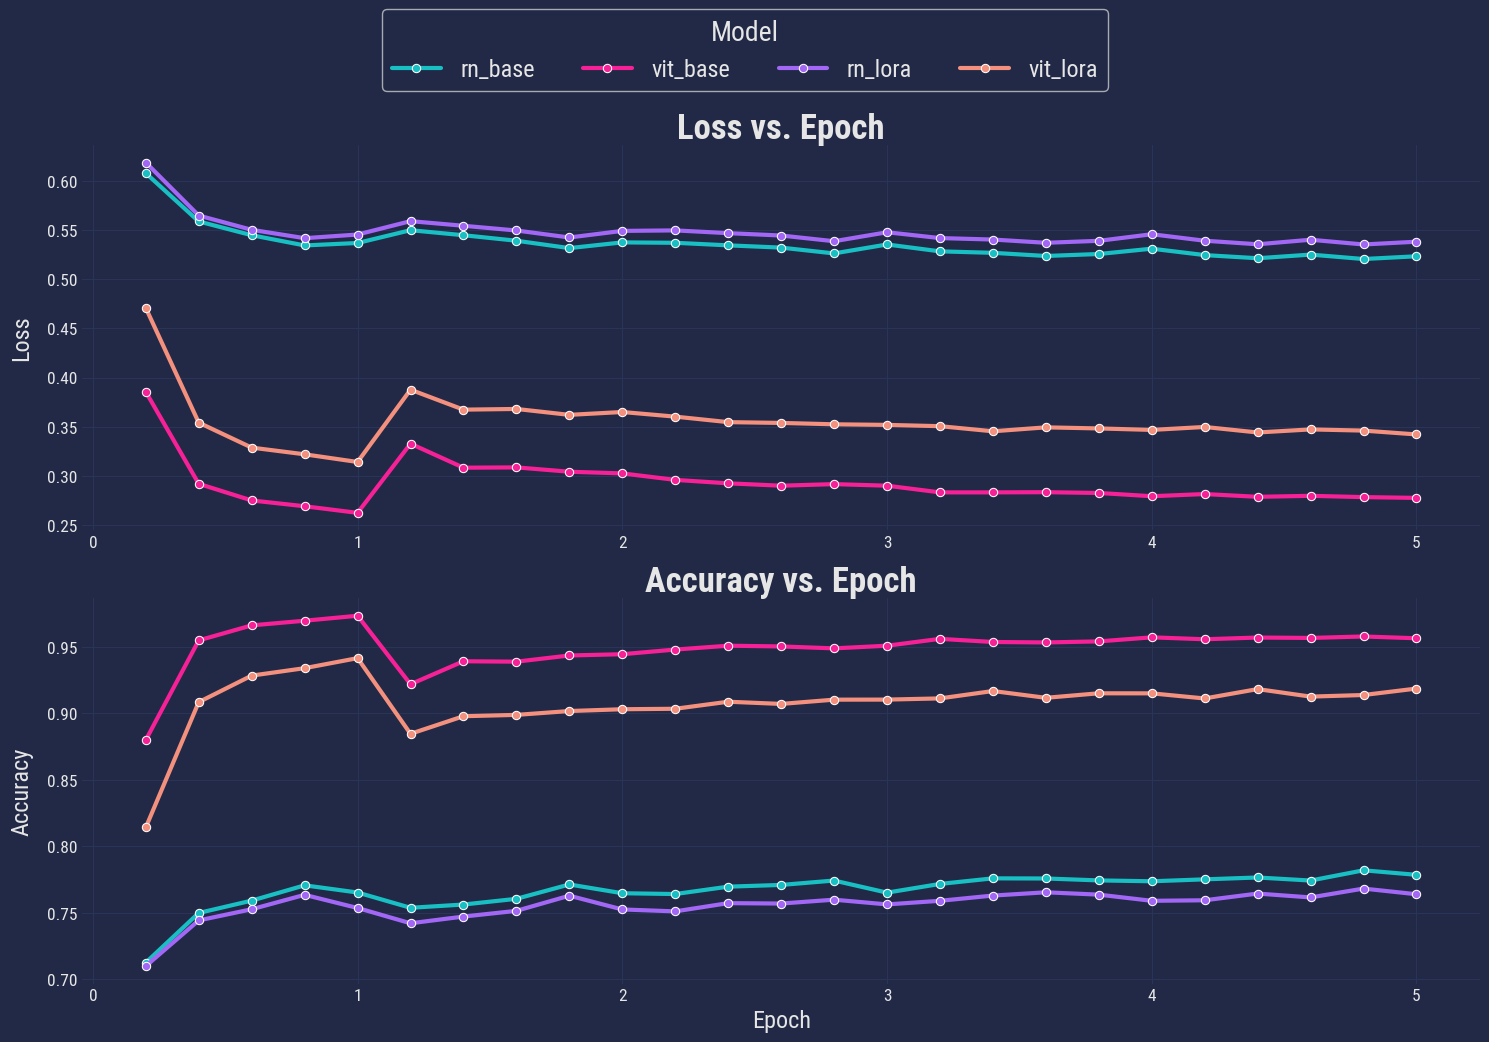

In [18]:
# Create a figure with 2 rows and 1 column
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Loss vs. Epoch (Top Plot)
sns.lineplot(data=data, x='Epoch', y='Loss', hue='Model', marker='o', ax=axes[0], linewidth=3)
axes[0].set_title('Loss vs. Epoch', fontsize=25, weight='bold', pad=5)
axes[0].set_xlabel('')
axes[0].set_ylabel('Loss', fontsize=17.5, labelpad=10)
axes[0].tick_params(axis='both', which='major', labelsize=12.5)
axes[0].grid(True)
axes[0].get_legend().remove()

# Accuracy vs. Epoch (Bottom Plot)
sns.lineplot(data=data, x='Epoch', y='Accuracy', hue='Model', marker='o', ax=axes[1], linewidth=3, legend=False)
axes[1].set_title('Accuracy vs. Epoch', fontsize=25, weight='bold', pad=5)
axes[1].set_xlabel('Epoch', fontsize=17.5)
axes[1].set_ylabel('Accuracy', fontsize=17.5, labelpad=10)
axes[1].tick_params(axis='both', which='major', labelsize=12.5)
axes[1].grid(True)

# Add a single legend for the figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Model', title_fontsize=20, fontsize=17.5, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4, frameon=True)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the legend at the top

# Show the plot
plt.show()

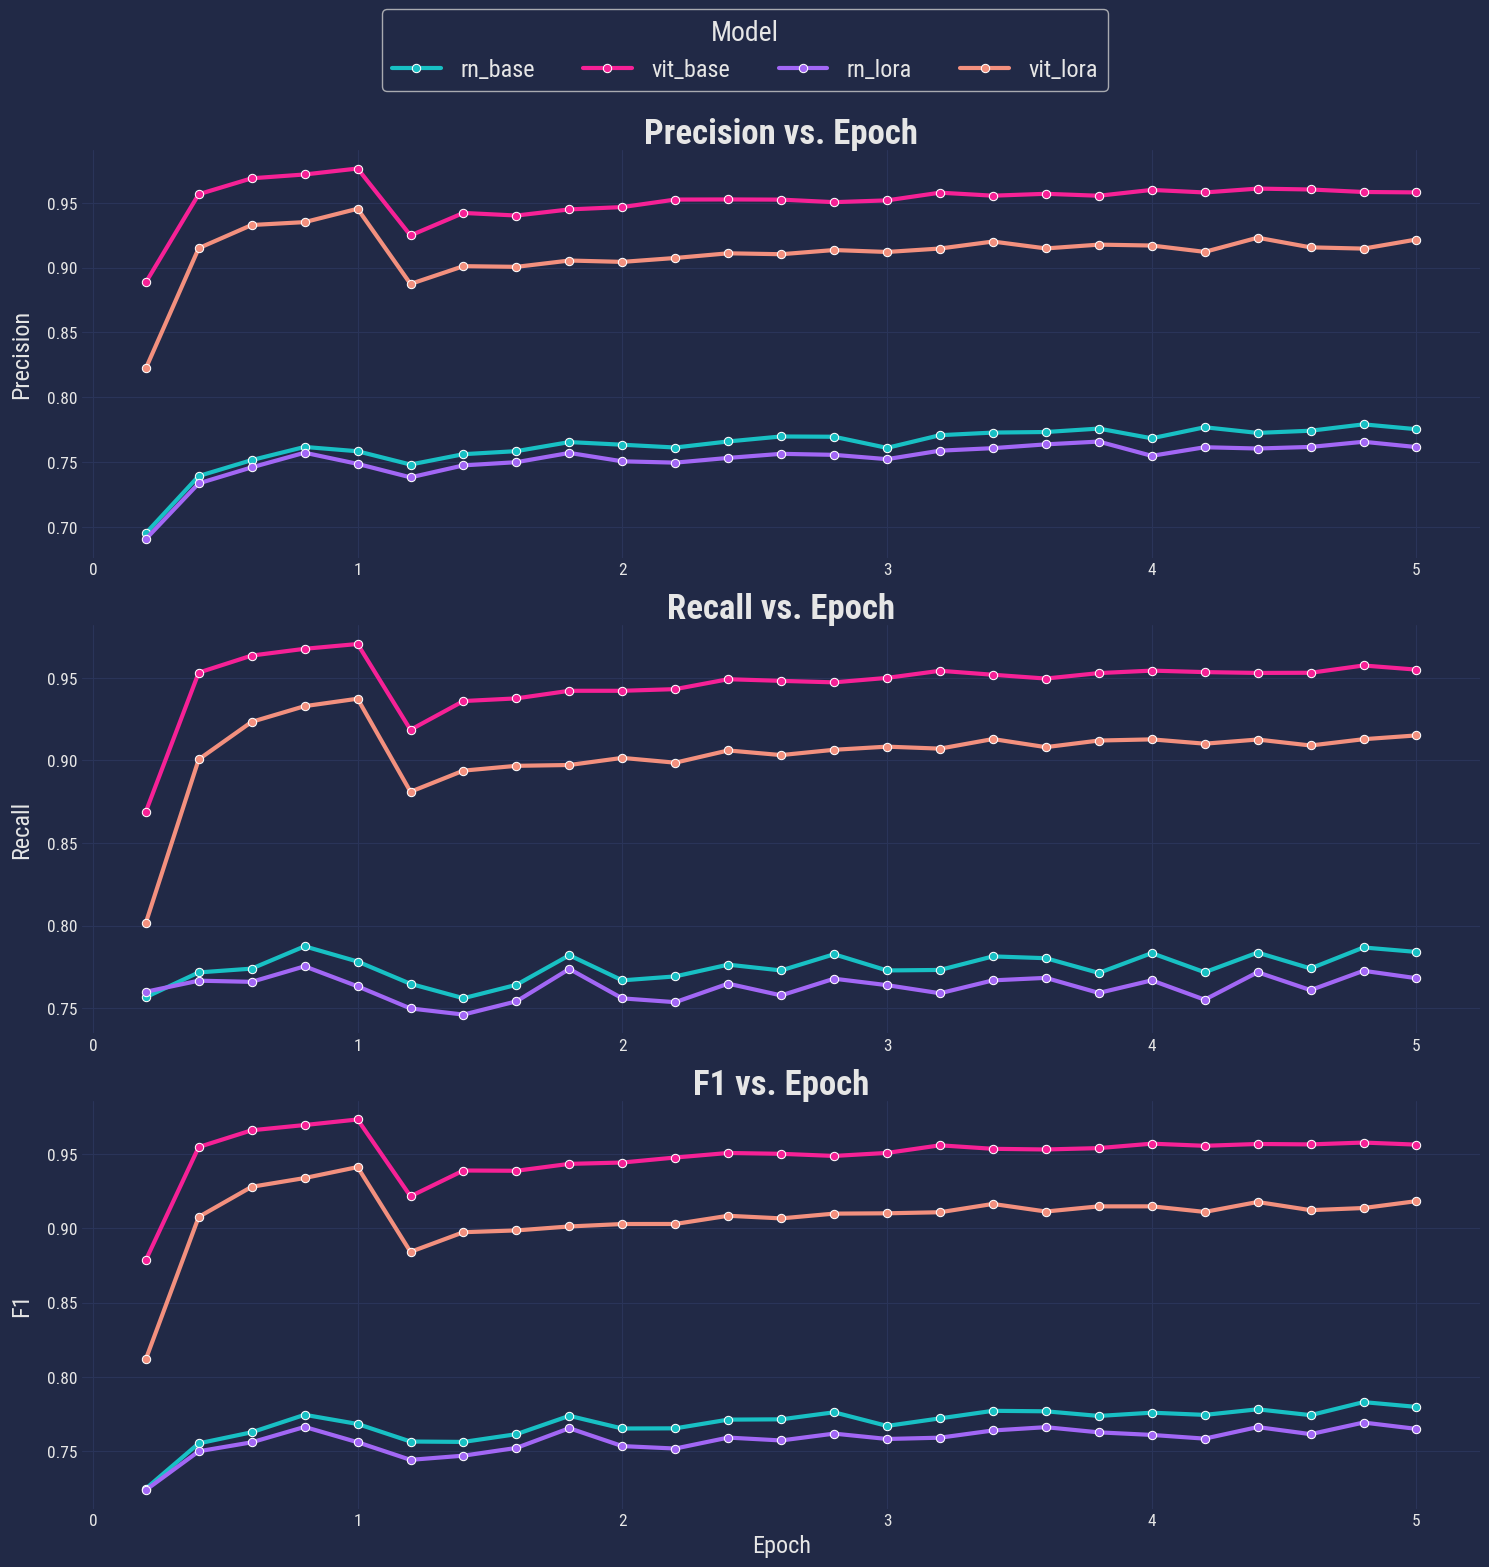

In [19]:
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

# Precision, Recall, F1-Score vs. Epoch
sns.lineplot(data=data, x='Epoch', y='Precision', hue='Model', marker='o', ax=axes[0], linewidth=3)
axes[0].set_title('Precision vs. Epoch', fontsize=25, weight='bold', pad=5)
axes[0].set_xlabel('')
axes[0].set_ylabel('Precision', fontsize=17.5, labelpad=10)
axes[0].tick_params(axis='both', which='major', labelsize=12.5)
axes[0].grid(True)
axes[0].get_legend().remove()

sns.lineplot(data=data, x='Epoch', y='Recall', hue='Model', marker='o', ax=axes[1], linewidth=3, legend=False)
axes[1].set_title('Recall vs. Epoch', fontsize=25, weight='bold', pad=5)
axes[1].set_xlabel('')
axes[1].set_ylabel('Recall', fontsize=17.5, labelpad=10)
axes[1].tick_params(axis='both', which='major', labelsize=12.5)
axes[1].grid(True)

sns.lineplot(data=data, x='Epoch', y='F1', hue='Model', marker='o', ax=axes[2], linewidth=3, legend=False)
axes[2].set_title('F1 vs. Epoch', fontsize=25, weight='bold', pad=5)
axes[2].set_xlabel('Epoch', fontsize=17.5)
axes[2].set_ylabel('F1', fontsize=17.5, labelpad=10)
axes[2].tick_params(axis='both', which='major', labelsize=12.5)
axes[2].grid(True)

# Add a single legend for the figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Model', title_fontsize=20, fontsize=17.5, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4, frameon=True)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Leave space for the legend at the top

# Show the plot
plt.show()

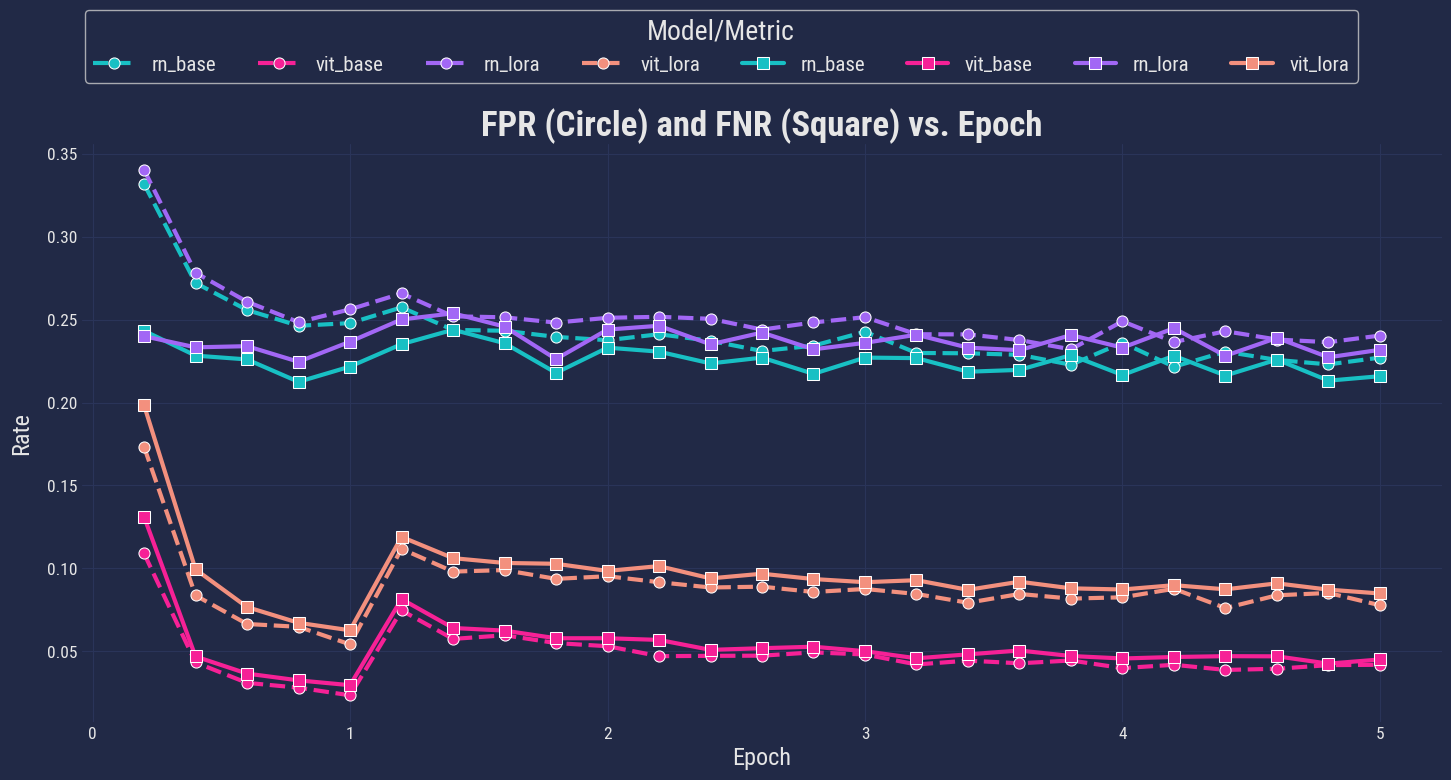

In [20]:
# Create the plot for FPR and FNR vs Epoch
plt.figure(figsize=(15, 8))

sns.lineplot(data=data, x="Epoch", y="FPR", hue="Model", marker="o", linestyle="--", markersize=8, linewidth=3)
sns.lineplot(data=data, x="Epoch", y="FNR", hue="Model", marker="s", markersize=8, linewidth=3)
plt.title("FPR (Circle) and FNR (Square) vs. Epoch", fontsize=25, weight="bold", pad=5)
plt.xlabel("Epoch", fontsize=17.5)
plt.ylabel("Rate", fontsize=17.5, labelpad=10)
plt.legend(title="Model/Metric", title_fontsize=20, fontsize=15, loc="upper center", bbox_to_anchor=(0.47, 1.25), ncol=8, frameon=True)
plt.grid(True)
plt.xticks(fontsize=12.5)
plt.yticks(fontsize=12.5)

# Adjust the layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

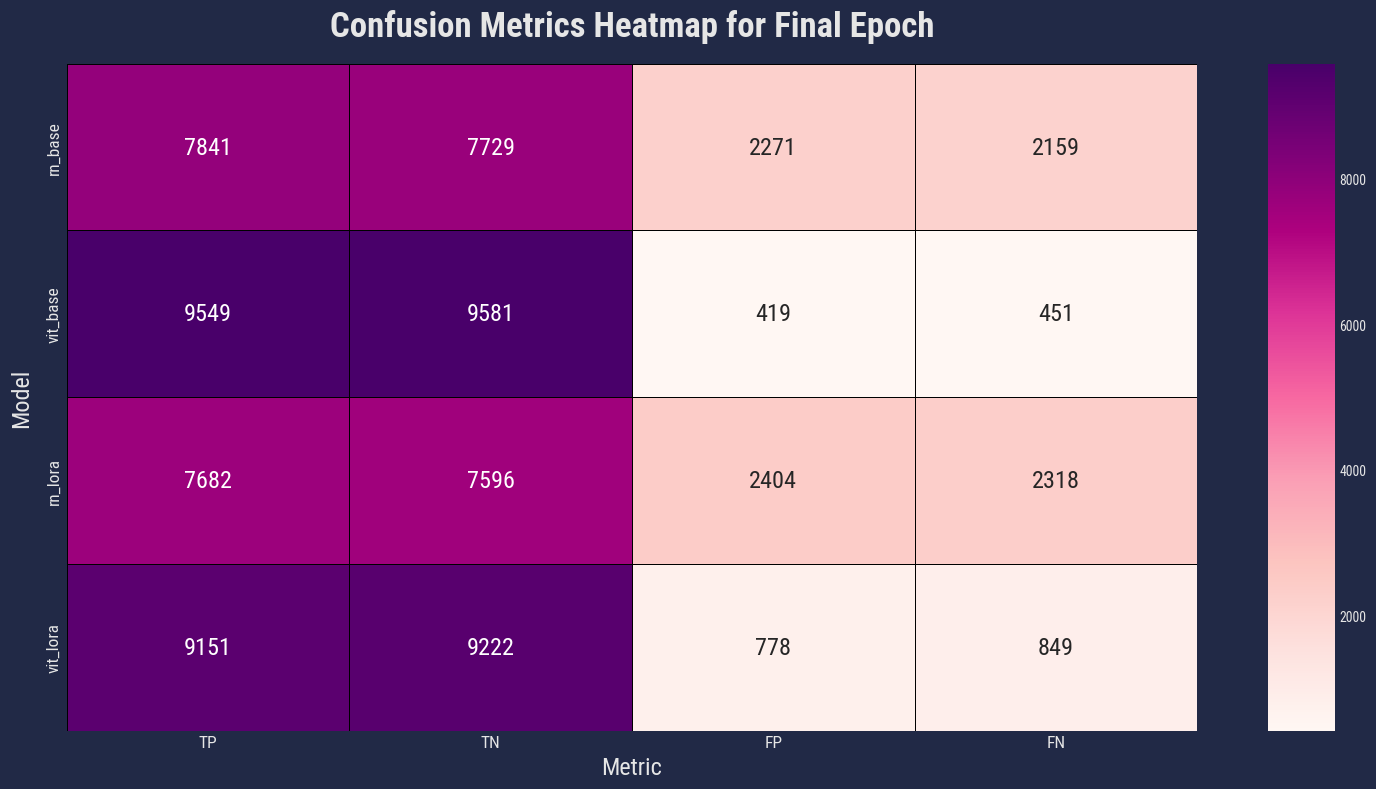

In [21]:
# Prepare the data for the heatmap (take the last epoch data)
final_epoch = data[data['Epoch'] == data['Epoch'].max()]
confusion_data = final_epoch[['Model', 'TP', 'TN', 'FP', 'FN']].set_index('Model')

# Create the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(confusion_data, annot=True, fmt="d", cmap="RdPu", cbar=True, linewidths=0.5, linecolor='black', annot_kws={"size": 17.5}, 
            cbar_kws={"aspect": 10})
plt.title('Confusion Metrics Heatmap for Final Epoch', fontsize=25, weight='bold', pad=20)
plt.ylabel('Model', fontsize=17.5, labelpad=10)
plt.xlabel('Metric', fontsize=17.5)
plt.xticks(fontsize=12.5)
plt.yticks(fontsize=12.5)

# Display the plot
plt.tight_layout()
plt.show()

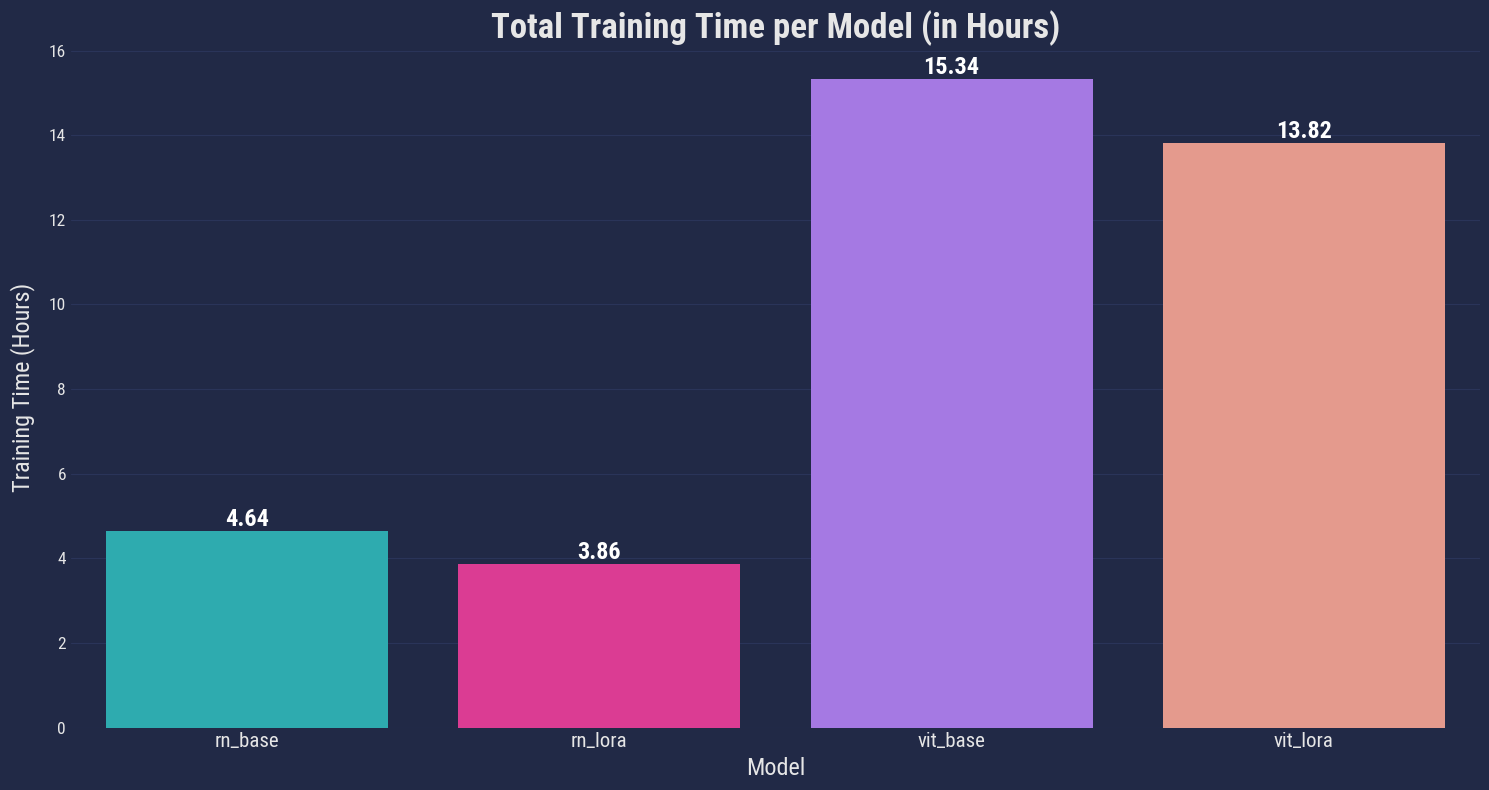

In [6]:
# Sum up the training time for each model and convert to hours
training_time_summary = data.groupby('Model')['Time'].sum() / 3600  # Convert seconds to hours

# Reset index for visualization
training_time_summary = training_time_summary.reset_index()
training_time_summary.columns = ['Model', 'Training Time (Hours)']

# Bar chart
plt.figure(figsize=(15, 8))
sns.barplot(data=training_time_summary, x='Model', y='Training Time (Hours)', hue='Model', dodge=False)

# Add numeric values on top of bars
for i, row in training_time_summary.iterrows():
    plt.text(i, row['Training Time (Hours)'], f"{row['Training Time (Hours)']:.2f}", 
             ha='center', va='bottom', color='white', fontsize=17.5, weight='bold')

# Chart customization
plt.title('Total Training Time per Model (in Hours)', fontsize=25, weight='bold')
plt.xlabel('Model', fontsize=17.5)
plt.ylabel('Training Time (Hours)', fontsize=17.5, labelpad=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=12.5)
plt.legend([], [], frameon=False)  # Hide the legend since hue is used for workaround
plt.grid(axis='y', alpha=1)

# Show the plot
plt.tight_layout()
plt.show()

## Validation statistic

### First evaluation

In [16]:
base_rn_training_args = TrainingArguments(
    output_dir="Model/rn/base",
    per_device_train_batch_size=256,
    num_train_epochs=5,
    save_strategy="epoch",
    fp16="True",
    logging_dir="logs",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

# Evaluate
base_rn_trainer.train(resume_from_checkpoint='Model/rn/base/checkpoint-395')
preds = base_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# True labels from the dataset
true_labels = preds.label_ids

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nClassification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

{'train_runtime': 0.0054, 'train_samples_per_second': 18656276.132, 'train_steps_per_second': 73692.291, 'train_loss': 0.0, 'epoch': 5.0}


100%|██████████| 2500/2500 [09:07<00:00,  4.57it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77     10000
           1       0.77      0.77      0.77     10000

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000


Confusion Matrix:
[[7707 2293]
 [2304 7696]]


In [13]:
base_vit_training_args = TrainingArguments(
    output_dir="Model/vit/base",
    per_device_train_batch_size=256,
    num_train_epochs=5,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

base_vit_trainer.train(resume_from_checkpoint='Model/vit/base/checkpoint-395')
preds = base_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)
true_labels = preds.label_ids

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

{'train_runtime': 0.1004, 'train_samples_per_second': 995860.143, 'train_steps_per_second': 3933.648, 'train_loss': 0.0, 'epoch': 5.0}


100%|██████████| 2500/2500 [34:36<00:00,  1.20it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     10000
           1       0.98      0.97      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000


Confusion Matrix:
[[9756  244]
 [ 286 9714]]


In [17]:
lora_rn_training_args = TrainingArguments(
    output_dir="Model/rn/lora",
    per_device_train_batch_size=256,
    num_train_epochs=5,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

lora_rn_trainer.train(resume_from_checkpoint='Model/rn/lora/checkpoint-395')
preds = lora_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

{'train_runtime': 0.0043, 'train_samples_per_second': 23463325.129, 'train_steps_per_second': 92680.134, 'train_loss': 0.0, 'epoch': 5.0}


100%|██████████| 2500/2500 [09:26<00:00,  4.41it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     10000
           1       0.97      0.02      0.03     10000

    accuracy                           0.51     20000
   macro avg       0.74      0.51      0.35     20000
weighted avg       0.74      0.51      0.35     20000


Confusion Matrix:
[[9995    5]
 [9825  175]]


In [18]:
lora_vit_training_args = TrainingArguments(
    output_dir="Model/vit/lora",
    per_device_train_batch_size=256,
    num_train_epochs=5,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

lora_vit_trainer.train(resume_from_checkpoint="Model/vit/lora/checkpoint-395")
preds = lora_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

{'train_runtime': 0.0031, 'train_samples_per_second': 31956601.905, 'train_steps_per_second': 126228.578, 'train_loss': 0.0, 'epoch': 5.0}


100%|██████████| 2500/2500 [32:45<00:00,  1.27it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     10000
           1       0.94      0.94      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000


Confusion Matrix:
[[9443  557]
 [ 614 9386]]


### Second evaluation

In [13]:
base_rn_training_args = TrainingArguments(
    output_dir="Model/rn/base",
    per_device_train_batch_size=256,
    num_train_epochs=10,
    save_strategy="epoch",
    fp16="True",
    logging_dir="logs",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

base_rn_trainer.train(resume_from_checkpoint='Model/rn/base/checkpoint-790')
preds = base_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# True labels from the dataset
true_labels = preds.label_ids

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

{'train_runtime': 0.113, 'train_samples_per_second': 1770196.674, 'train_steps_per_second': 6992.277, 'train_loss': 0.0, 'epoch': 10.0}


100%|██████████| 2500/2500 [10:39<00:00,  3.91it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.85      0.77     10000
           1       0.81      0.65      0.72     10000

    accuracy                           0.75     20000
   macro avg       0.76      0.75      0.75     20000
weighted avg       0.76      0.75      0.75     20000


Confusion Matrix:
[[8486 1514]
 [3479 6521]]


In [14]:
base_vit_training_args = TrainingArguments(
    output_dir="Model/vit/base",
    per_device_train_batch_size=256,
    num_train_epochs=10,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

base_vit_trainer.train(resume_from_checkpoint='Model/vit/base/checkpoint-790')
preds = base_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

{'train_runtime': 0.0092, 'train_samples_per_second': 21767107.79, 'train_steps_per_second': 85980.076, 'train_loss': 0.0, 'epoch': 10.0}


100%|██████████| 2500/2500 [36:10<00:00,  1.15it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     10000
           1       0.98      0.96      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000


Confusion Matrix:
[[9773  227]
 [ 361 9639]]


In [15]:
lora_rn_training_args = TrainingArguments(
    output_dir="Model/rn/lora",
    per_device_train_batch_size=256,
    num_train_epochs=10,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

lora_rn_trainer.train(resume_from_checkpoint='Model/rn/lora/checkpoint-790')
preds = lora_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

{'train_runtime': 0.0048, 'train_samples_per_second': 41566859.918, 'train_steps_per_second': 164189.097, 'train_loss': 0.0, 'epoch': 10.0}


100%|██████████| 2500/2500 [11:35<00:00,  3.59it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.67     10000
           1       0.97      0.02      0.04     10000

    accuracy                           0.51     20000
   macro avg       0.74      0.51      0.36     20000
weighted avg       0.74      0.51      0.36     20000


Confusion Matrix:
[[9994    6]
 [9784  216]]


In [16]:
lora_vit_training_args = TrainingArguments(
    output_dir="Model/vit/lora",
    per_device_train_batch_size=256,
    num_train_epochs=10,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

lora_vit_trainer.train(resume_from_checkpoint='Model/vit/lora/checkpoint-790')
preds = lora_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

{'train_runtime': 0.0048, 'train_samples_per_second': 41533930.782, 'train_steps_per_second': 164059.027, 'train_loss': 0.0, 'epoch': 10.0}


100%|██████████| 2500/2500 [36:04<00:00,  1.16it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     10000
           1       0.94      0.94      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000


Confusion Matrix:
[[9443  557]
 [ 618 9382]]


### Third evaluation

In [13]:
base_rn_training_args = TrainingArguments(
    output_dir="Model/rn/base",
    per_device_train_batch_size=256,
    num_train_epochs=15,
    save_strategy="epoch",
    fp16="True",
    logging_dir="logs",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

base_rn_trainer.train(resume_from_checkpoint='Model/rn/base/checkpoint-1185')
preds = base_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# True labels from the dataset
true_labels = preds.label_ids

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

{'train_runtime': 0.0983, 'train_samples_per_second': 3053378.565, 'train_steps_per_second': 12060.845, 'train_loss': 0.0, 'epoch': 15.0}


100%|██████████| 2500/2500 [09:47<00:00,  4.26it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.86      0.78     10000
           1       0.82      0.65      0.73     10000

    accuracy                           0.75     20000
   macro avg       0.76      0.75      0.75     20000
weighted avg       0.76      0.75      0.75     20000


Confusion Matrix:
[[8551 1449]
 [3489 6511]]


In [ ]:
base_vit_training_args = TrainingArguments(
    output_dir="Model/vit/base",
    per_device_train_batch_size=256,
    num_train_epochs=15,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

base_vit_trainer.train(resume_from_checkpoint='Model/vit/base/checkpoint-1185')
preds = base_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)


print("\nClassification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

{'train_runtime': 0.0065, 'train_samples_per_second': 46325425.226, 'train_steps_per_second': 182985.43, 'train_loss': 0.0, 'epoch': 15.0}


100%|██████████| 2500/2500 [32:56<00:00,  1.26it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     10000
           1       0.98      0.97      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000


Confusion Matrix:
[[9803  197]
 [ 324 9676]]


In [15]:
lora_rn_training_args = TrainingArguments(
    output_dir="Model/rn/lora",
    per_device_train_batch_size=256,
    num_train_epochs=15,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

lora_rn_trainer.train(resume_from_checkpoint='Model/rn/lora/checkpoint-1185')
preds = lora_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

{'train_runtime': 0.0079, 'train_samples_per_second': 38002210.746, 'train_steps_per_second': 150108.732, 'train_loss': 0.0, 'epoch': 15.0}


100%|██████████| 2500/2500 [08:11<00:00,  5.08it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.67     10000
           1       0.97      0.02      0.05     10000

    accuracy                           0.51     20000
   macro avg       0.74      0.51      0.36     20000
weighted avg       0.74      0.51      0.36     20000


Confusion Matrix:
[[9993    7]
 [9765  235]]


In [16]:
lora_vit_training_args = TrainingArguments(
    output_dir="Model/vit/lora",
    per_device_train_batch_size=256,
    num_train_epochs=15,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

lora_vit_trainer.train(resume_from_checkpoint="Model/vit/lora/checkpoint-1185")
preds = lora_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

{'train_runtime': 0.0037, 'train_samples_per_second': 80882638.041, 'train_steps_per_second': 319486.42, 'train_loss': 0.0, 'epoch': 15.0}


100%|██████████| 2500/2500 [32:06<00:00,  1.30it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     10000
           1       0.94      0.95      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000


Confusion Matrix:
[[9399  601]
 [ 543 9457]]


### Fourth evaluation

In [13]:
base_rn_training_args = TrainingArguments(
    output_dir="Model/rn/base",
    per_device_train_batch_size=256,
    num_train_epochs=20,
    save_strategy="epoch",
    fp16="True",
    logging_dir="logs",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

# Evaluate
base_rn_trainer.train(resume_from_checkpoint="Model/rn/base/checkpoint-1580")
preds = base_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# True labels from the dataset
true_labels = preds.label_ids

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

{'train_runtime': 0.0927, 'train_samples_per_second': 4312842.475, 'train_steps_per_second': 17035.728, 'train_loss': 0.0, 'epoch': 20.0}


100%|██████████| 2500/2500 [11:18<00:00,  3.69it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.85      0.78     10000
           1       0.82      0.66      0.73     10000

    accuracy                           0.76     20000
   macro avg       0.77      0.76      0.76     20000
weighted avg       0.77      0.76      0.76     20000


Confusion Matrix:
[[8528 1472]
 [3351 6649]]


In [14]:
base_vit_training_args = TrainingArguments(
    output_dir="Model/vit/base",
    per_device_train_batch_size=256,
    num_train_epochs=20,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

base_vit_trainer.train(resume_from_checkpoint='Model/vit/base/checkpoint-1580')
preds = base_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

{'train_runtime': 0.0045, 'train_samples_per_second': 88928315.488, 'train_steps_per_second': 351266.846, 'train_loss': 0.0, 'epoch': 20.0}


100%|██████████| 2500/2500 [33:40<00:00,  1.24it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     10000
           1       0.98      0.97      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000


Confusion Matrix:
[[9803  197]
 [ 278 9722]]


In [15]:
lora_rn_training_args = TrainingArguments(
    output_dir="Model/rn/lora",
    per_device_train_batch_size=256,
    num_train_epochs=20,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

lora_rn_trainer.train(resume_from_checkpoint='Model/rn/lora/checkpoint-1580')
preds = lora_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

{'train_runtime': 0.007, 'train_samples_per_second': 57297278.098, 'train_steps_per_second': 226324.248, 'train_loss': 0.0, 'epoch': 20.0}


100%|██████████| 2500/2500 [08:01<00:00,  5.19it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.67     10000
           1       0.97      0.03      0.05     10000

    accuracy                           0.51     20000
   macro avg       0.74      0.51      0.36     20000
weighted avg       0.74      0.51      0.36     20000


Confusion Matrix:
[[9992    8]
 [9746  254]]


In [14]:
lora_vit_training_args = TrainingArguments(
    output_dir="Model/vit/lora",
    per_device_train_batch_size=256,
    num_train_epochs=20,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

lora_vit_trainer.train(resume_from_checkpoint='Model/vit/lora/checkpoint-1580')

preds = lora_vit_trainer.predict(test_dataset=vit_train_dataset)


# Get predicted labels by selecting the class with the higher logit value

predicted_labels = np.argmax(preds.predictions[1], axis=1)


# Classification report (includes Precision, Recall, F1 score per class)

class_report = classification_report(true_labels, predicted_labels)


# Confusion matrix

conf_matrix = confusion_matrix(true_labels, predicted_labels)


print("\nClassification Report:")

print(class_report)


print("\nConfusion Matrix:")

print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

{'train_runtime': 0.0058, 'train_samples_per_second': 68697141.921, 'train_steps_per_second': 271353.711, 'train_loss': 0.0, 'epoch': 20.0}


100%|██████████| 2500/2500 [37:05<00:00,  1.12it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     10000
           1       0.94      0.95      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000


Confusion Matrix:
[[9416  584]
 [ 525 9475]]


### Fifth evaluation

In [13]:
base_rn_training_args = TrainingArguments(
    output_dir="Model/rn/base",
    per_device_train_batch_size=256,
    num_train_epochs=25,
    save_strategy="epoch",
    fp16="True",
    logging_dir="logs",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

# Evaluate
base_rn_trainer.train(resume_from_checkpoint='Model/rn/base/checkpoint-1975')
preds = base_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# True labels from the dataset
true_labels = preds.label_ids

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

{'train_runtime': 0.128, 'train_samples_per_second': 3906860.636, 'train_steps_per_second': 15432.1, 'train_loss': 0.0, 'epoch': 25.0}


100%|██████████| 2500/2500 [12:44<00:00,  3.27it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.87      0.78     10000
           1       0.83      0.64      0.72     10000

    accuracy                           0.75     20000
   macro avg       0.77      0.75      0.75     20000
weighted avg       0.77      0.75      0.75     20000


Confusion Matrix:
[[8678 1322]
 [3581 6419]]


In [14]:
base_vit_training_args = TrainingArguments(
    output_dir="Model/vit/base",
    per_device_train_batch_size=256,
    num_train_epochs=25,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

base_vit_trainer.train(resume_from_checkpoint='Model/vit/base/checkpoint-1975')

preds = base_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

{'train_runtime': 0.0037, 'train_samples_per_second': 136099162.827, 'train_steps_per_second': 537591.693, 'train_loss': 0.0, 'epoch': 25.0}


100%|██████████| 2500/2500 [35:34<00:00,  1.17it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     10000
           1       0.98      0.97      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000


Confusion Matrix:
[[9800  200]
 [ 276 9724]]


In [15]:
lora_rn_training_args = TrainingArguments(
    output_dir="Model/rn/lora",
    per_device_train_batch_size=256,
    num_train_epochs=25,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

lora_rn_trainer.train(resume_from_checkpoint='Model/rn/lora/checkpoint-1975')
preds = lora_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

{'train_runtime': 0.0041, 'train_samples_per_second': 122490041.47, 'train_steps_per_second': 483835.664, 'train_loss': 0.0, 'epoch': 25.0}


100%|██████████| 2500/2500 [08:24<00:00,  4.95it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.67     10000
           1       0.97      0.03      0.05     10000

    accuracy                           0.51     20000
   macro avg       0.74      0.51      0.36     20000
weighted avg       0.74      0.51      0.36     20000


Confusion Matrix:
[[9992    8]
 [9739  261]]


In [16]:
lora_vit_training_args = TrainingArguments(
    output_dir="Model/vit/lora",
    per_device_train_batch_size=256,
    num_train_epochs=25,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

lora_vit_trainer.train(resume_from_checkpoint='Model/vit/lora/checkpoint-1975')
preds = lora_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

{'train_runtime': 0.004, 'train_samples_per_second': 123806127.871, 'train_steps_per_second': 489034.205, 'train_loss': 0.0, 'epoch': 25.0}


100%|██████████| 2500/2500 [32:41<00:00,  1.27it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     10000
           1       0.94      0.95      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000


Confusion Matrix:
[[9440  560]
 [ 537 9463]]


### Interpratation

In [23]:
# Load the dataset
file_path = 'validation.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Compute additional metrics
data['Accuracy'] = (data['TP'] + data['TN']) / (data['TP'] + data['TN'] + data['FP'] + data['FN'])
data['Precision'] = data['TP'] / (data['TP'] + data['FP'])
data['Recall'] = data['TP'] / (data['TP'] + data['FN'])
data['F1'] = 2 * (data['Precision'] * data['Recall']) / (data['Precision'] + data['Recall'])
data['FPR'] = data['FP'] / (data['FP'] + data['TN'])
data['FNR'] = data['FN'] / (data['TP'] + data['FN'])

# Convert Epoch and Model for easier plotting
data['Epoch'] = data['Epoch'].astype(float)
data['Model'] = data['Model'].astype(str)

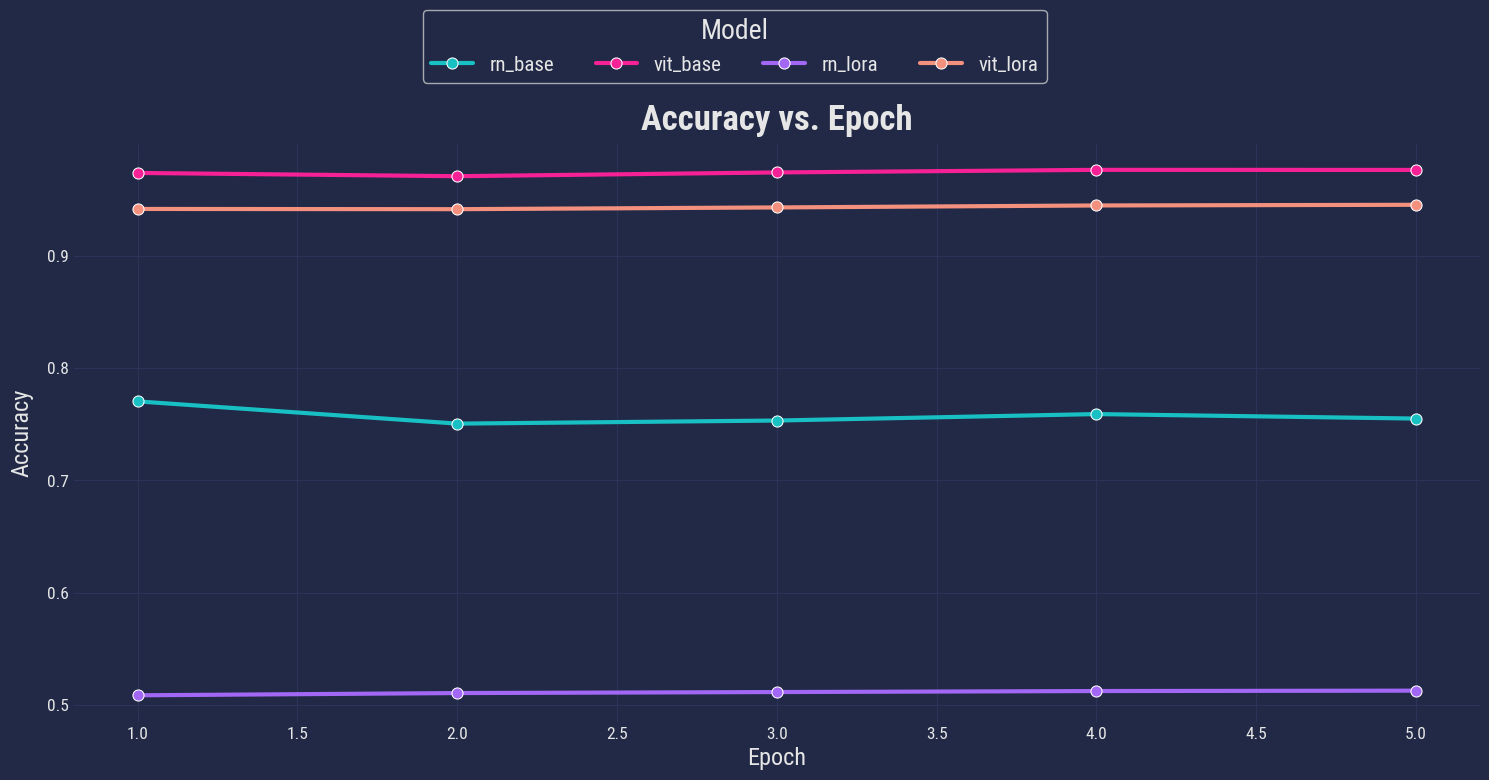

In [24]:
# Accuracy vs. Epoch
plt.figure(figsize=(15, 8))
sns.lineplot(data=data, x='Epoch', y='Accuracy', hue='Model', marker='o', markersize=8, linewidth=3)
plt.title('Accuracy vs. Epoch', fontsize=25, weight='bold', pad=10)
plt.xlabel('Epoch', fontsize=17.5)
plt.ylabel('Accuracy', fontsize=17.5, labelpad=10)
plt.legend(title='Model', title_fontsize=20, fontsize=15, loc="upper center", bbox_to_anchor=(0.47, 1.25), ncol=4, frameon=True)
plt.grid(True)
plt.xticks(fontsize=12.5)
plt.yticks(fontsize=12.5)

# Show the plot
plt.tight_layout()
plt.show()

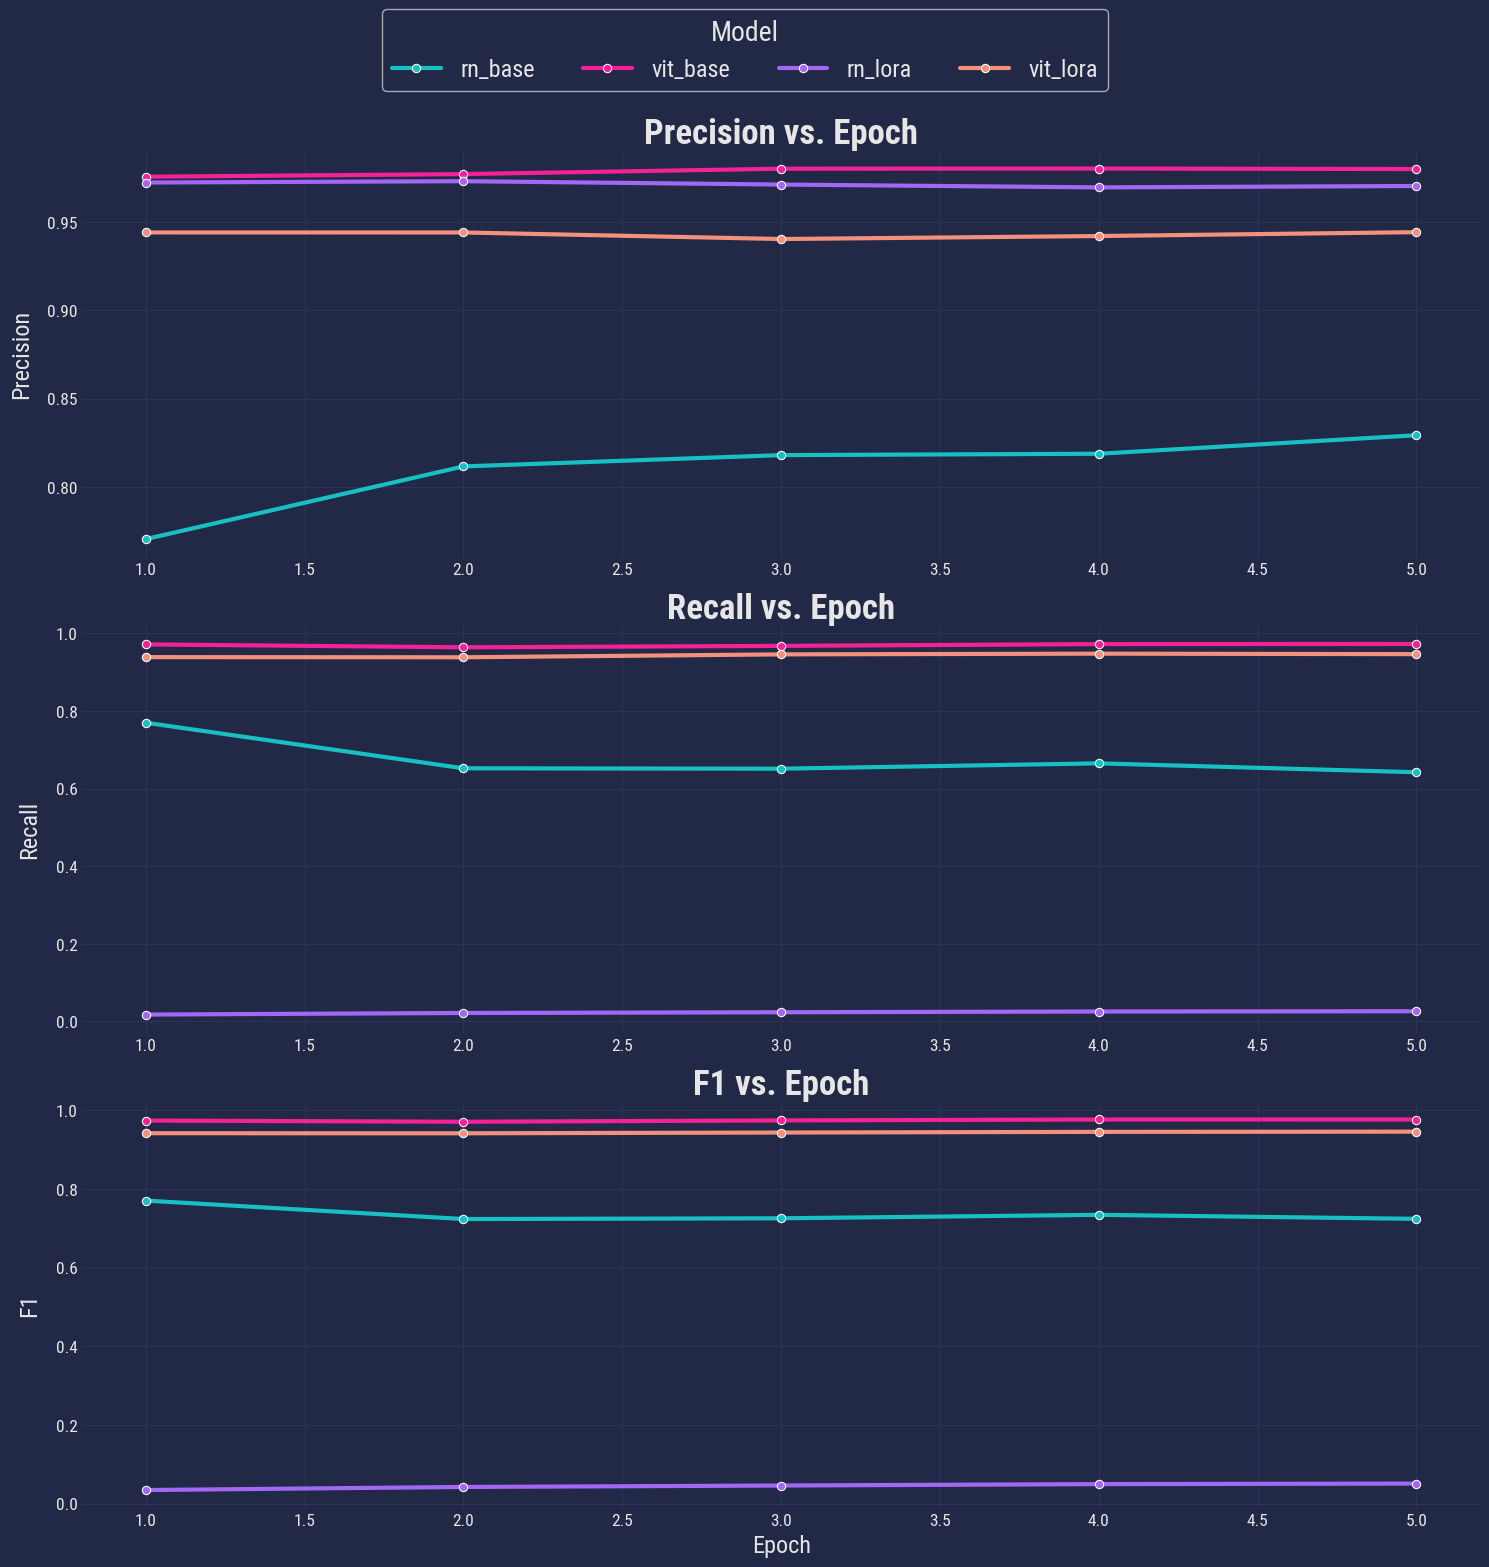

In [25]:
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

# Precision, Recall, F1-Score vs. Epoch
sns.lineplot(data=data, x='Epoch', y='Precision', hue='Model', marker='o', ax=axes[0], linewidth=3)
axes[0].set_title('Precision vs. Epoch', fontsize=25, weight='bold', pad=5)
axes[0].set_xlabel('')
axes[0].set_ylabel('Precision', fontsize=17.5, labelpad=10)
axes[0].tick_params(axis='both', which='major', labelsize=12.5)
axes[0].grid(True)
axes[0].get_legend().remove()

sns.lineplot(data=data, x='Epoch', y='Recall', hue='Model', marker='o', ax=axes[1], linewidth=3, legend=False)
axes[1].set_title('Recall vs. Epoch', fontsize=25, weight='bold', pad=5)
axes[1].set_xlabel('')
axes[1].set_ylabel('Recall', fontsize=17.5, labelpad=10)
axes[1].tick_params(axis='both', which='major', labelsize=12.5)
axes[1].grid(True)

sns.lineplot(data=data, x='Epoch', y='F1', hue='Model', marker='o', ax=axes[2], linewidth=3, legend=False)
axes[2].set_title('F1 vs. Epoch', fontsize=25, weight='bold', pad=5)
axes[2].set_xlabel('Epoch', fontsize=17.5)
axes[2].set_ylabel('F1', fontsize=17.5, labelpad=10)
axes[2].tick_params(axis='both', which='major', labelsize=12.5)
axes[2].grid(True)

# Add a single legend for the figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Model', title_fontsize=20, fontsize=17.5, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4, frameon=True)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Leave space for the legend at the top

# Show the plot
plt.show()

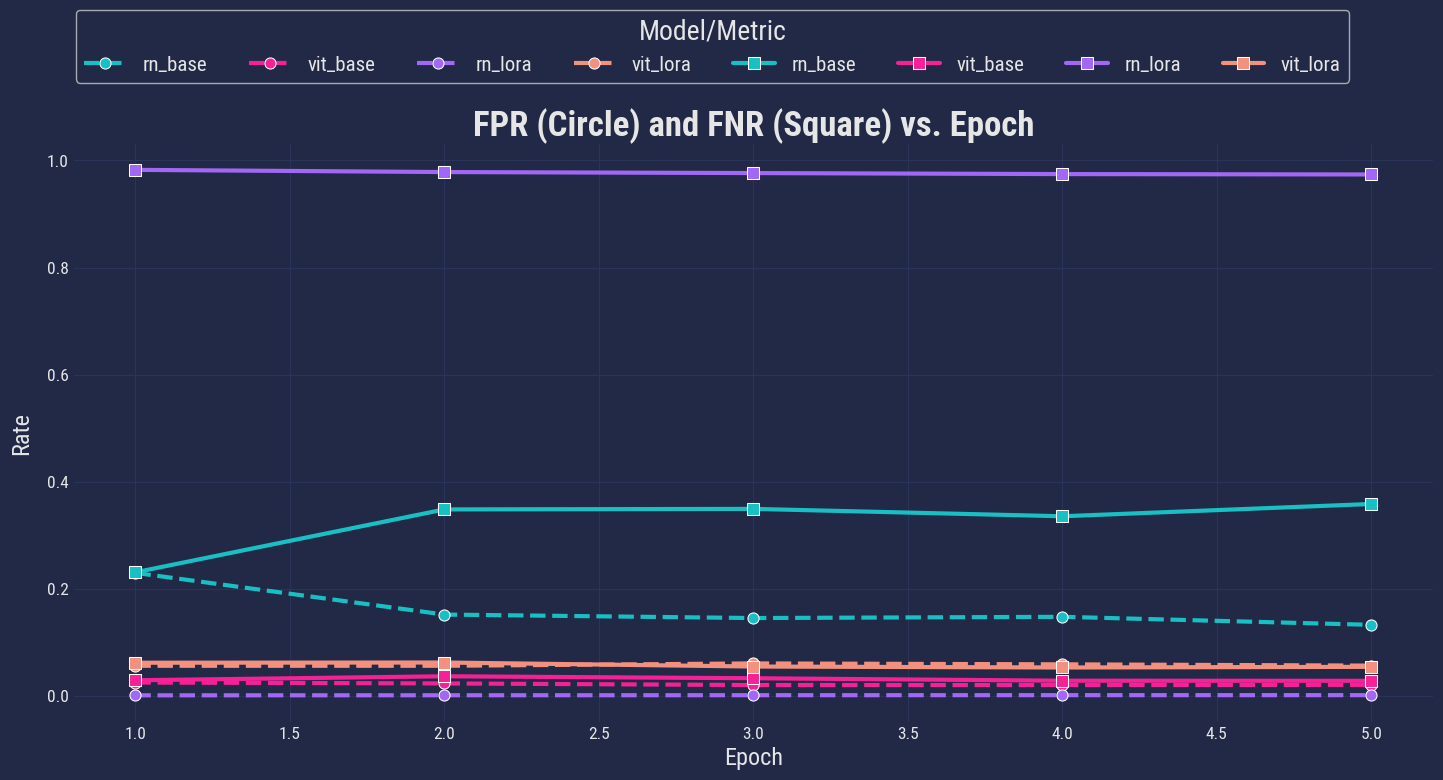

In [26]:
# Create the plot for FPR and FNR vs Epoch
plt.figure(figsize=(15, 8))

sns.lineplot(data=data, x="Epoch", y="FPR", hue="Model", marker="o", linestyle="--", markersize=8, linewidth=3)
sns.lineplot(data=data, x="Epoch", y="FNR", hue="Model", marker="s", markersize=8, linewidth=3)
plt.title("FPR (Circle) and FNR (Square) vs. Epoch", fontsize=25, weight="bold", pad=5)
plt.xlabel("Epoch", fontsize=17.5)
plt.ylabel("Rate", fontsize=17.5, labelpad=10)
plt.legend(title="Model/Metric", title_fontsize=20, fontsize=15, loc="upper center", bbox_to_anchor=(0.47, 1.25), ncol=8, frameon=True)
plt.grid(True)
plt.xticks(fontsize=12.5)
plt.yticks(fontsize=12.5)

# Adjust the layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

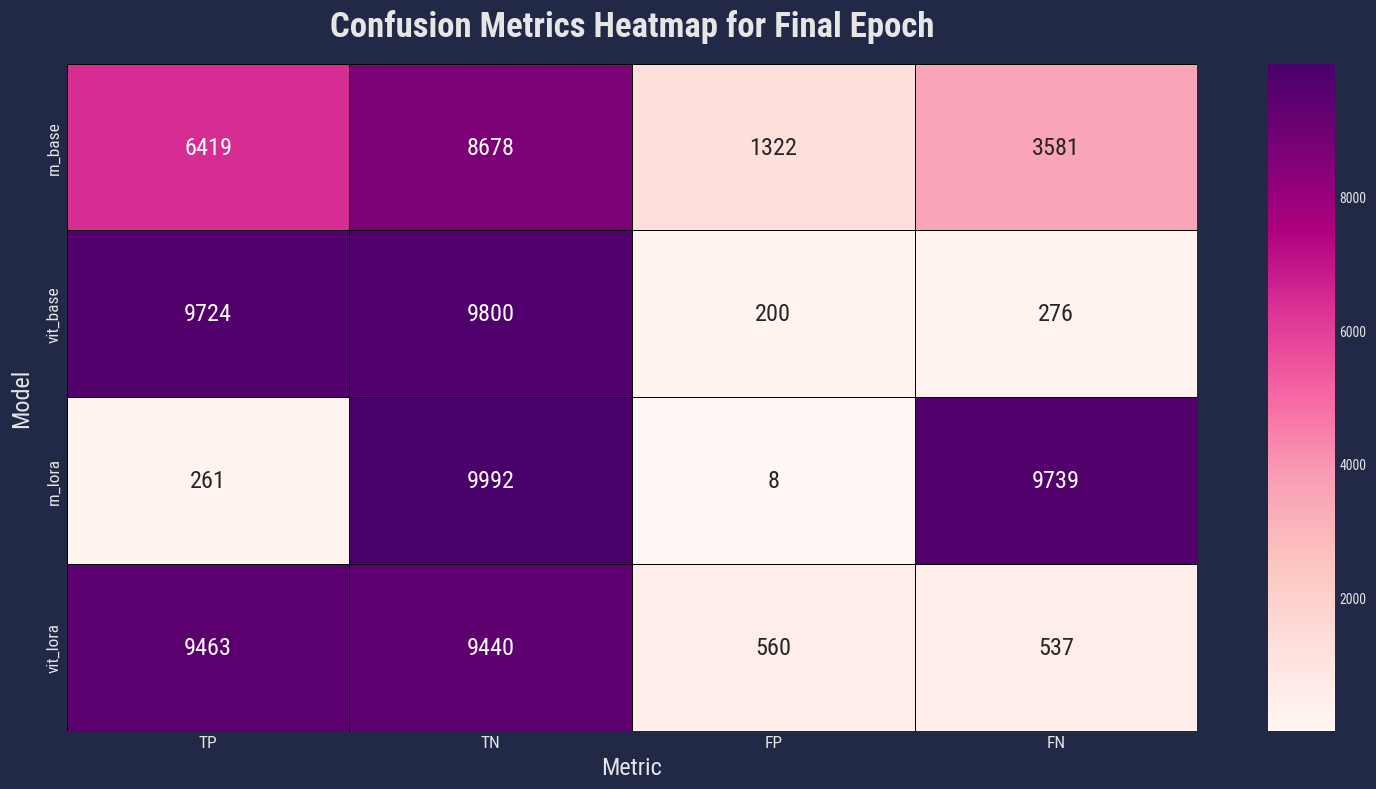

In [27]:
# Prepare the data for the heatmap (take the last epoch data)
final_epoch = data[data['Epoch'] == data['Epoch'].max()]
confusion_data = final_epoch[['Model', 'TP', 'TN', 'FP', 'FN']].set_index('Model')

# Create the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(confusion_data, annot=True, fmt="d", cmap="RdPu", cbar=True, linewidths=0.5, linecolor='black', annot_kws={"size": 17.5}, 
            cbar_kws={"aspect": 10})
plt.title('Confusion Metrics Heatmap for Final Epoch', fontsize=25, weight='bold', pad=20)
plt.ylabel('Model', fontsize=17.5, labelpad=10)
plt.xlabel('Metric', fontsize=17.5)
plt.xticks(fontsize=12.5)
plt.yticks(fontsize=12.5)

# Display the plot
plt.tight_layout()
plt.show()

## Test statistic

In [13]:
base_rn_training_args = TrainingArguments(
    output_dir="Model/rn/base",
    per_device_train_batch_size=256,
    num_train_epochs=25,
    save_strategy="epoch",
    fp16="True",
    logging_dir="logs",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

# Evaluate
base_rn_trainer.train(resume_from_checkpoint="Model/rn/base/checkpoint-1975")
preds = base_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# True labels from the dataset
true_labels = preds.label_ids

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

{'train_runtime': 0.1582, 'train_samples_per_second': 3160655.777, 'train_steps_per_second': 12484.59, 'train_loss': 0.0, 'epoch': 25.0}


100%|██████████| 2500/2500 [11:25<00:00,  3.65it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.87      0.78     10000
           1       0.83      0.64      0.72     10000

    accuracy                           0.75     20000
   macro avg       0.77      0.75      0.75     20000
weighted avg       0.77      0.75      0.75     20000


Confusion Matrix:
[[8671 1329]
 [3584 6416]]


In [14]:
base_vit_training_args = TrainingArguments(
    output_dir="Model/vit/base",
    per_device_train_batch_size=256,
    num_train_epochs=25,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

base_vit_trainer.train(resume_from_checkpoint="Model/vit/base/checkpoint-1975")
preds = base_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

{'train_runtime': 0.0038, 'train_samples_per_second': 130177032.899, 'train_steps_per_second': 514199.28, 'train_loss': 0.0, 'epoch': 25.0}


100%|██████████| 2500/2500 [37:27<00:00,  1.11it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     10000
           1       0.98      0.98      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000


Confusion Matrix:
[[9764  236]
 [ 245 9755]]


In [15]:
lora_rn_training_args = TrainingArguments(
    output_dir="Model/rn/lora",
    per_device_train_batch_size=256,
    num_train_epochs=25,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn,
)

lora_rn_trainer.train(resume_from_checkpoint="Model/rn/lora/checkpoint-1975")
preds = lora_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

{'train_runtime': 0.0073, 'train_samples_per_second': 68473960.884, 'train_steps_per_second': 270472.145, 'train_loss': 0.0, 'epoch': 25.0}


100%|██████████| 2500/2500 [11:29<00:00,  3.63it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.67     10000
           1       0.94      0.02      0.05     10000

    accuracy                           0.51     20000
   macro avg       0.72      0.51      0.36     20000
weighted avg       0.72      0.51      0.36     20000


Confusion Matrix:
[[9984   16]
 [9756  244]]


In [16]:
lora_vit_training_args = TrainingArguments(
    output_dir="Model/vit/lora",
    per_device_train_batch_size=256,
    num_train_epochs=25,
    save_strategy="epoch",
    logging_dir="logs",
    fp16="True",
    label_smoothing_factor=0.1,
    learning_rate=0.001,
    logging_strategy="epoch",
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn,
)

lora_vit_trainer.train(resume_from_checkpoint="Model/vit/lora/checkpoint-1975")
preds = lora_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

{'train_runtime': 0.0045, 'train_samples_per_second': 111178073.477, 'train_steps_per_second': 439153.39, 'train_loss': 0.0, 'epoch': 25.0}


100%|██████████| 2500/2500 [34:34<00:00,  1.21it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     10000
           1       0.95      0.95      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000


Confusion Matrix:
[[9450  550]
 [ 515 9485]]
